In [1]:
!pip -q install roboflow
!pip -q install ultralytics
! pip -q install ruamel.yaml
! wget https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8m-seg.pt

from roboflow import Roboflow
import sys
import ruamel.yaml
from ultralytics import YOLO
from pathlib import Path
import os
from collections import defaultdict
import copy
import math
import shutil
import numpy as np
import psutil
import gc
import matplotlib.pyplot as plt
import locale
from IPython.display import clear_output
import ctypes
import ctypes.util
import torch
import random


# deterministic set
torch.manual_seed(43)
random.seed(43)
np.random.seed(43)


rf = Roboflow(api_key="tD9RSesaXxGqmwVD6eVZ")
project = rf.workspace("hanyang-university-bd2kb").project("puddle-segmentation")
dataset = project.version(8).download("yolov8")


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab 4.0.5 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.0.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.0.0 requires jupyterlab<5.0.0a0,>=4.0.6, but you have jupyterlab 4.0.5 which is incompatible.
pytoolconfig 1.2.6 requires packaging>=22.0, but you have packaging 21.3 which is incompatible.
tensorflowjs 4.13.0 requires packaging~=23.1, but you have packaging 21.3 which is incompatible.
ydata-profiling 4.5.1 requires numpy<1.24,>=1.16.0, but you have numpy 1.24.3 which is incompatible.
--2023-12-02 19:16:27--  https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8m-seg.pt
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... conn

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3


loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.0.221, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to puddle-segmentation-8 in yolov8:: 100%|██████████| 4847/4847 [00:00<00:00, 9263.23it/s]


In [2]:
%cd /kaggle/working/puddle-segmentation-8

# trying to optimize RAM usage
gc.enable()

libc = ctypes.CDLL(ctypes.util.find_library('c'))
libc.malloc_trim(ctypes.c_int(0))

torch.set_num_threads(1)
os.environ["OMP_NUM_THREADS"] = "1"

/kaggle/working/puddle-segmentation-8


In [3]:
class YoloModel:
    def __init__(self, path_to_model: str, path_to_yaml: str,
                 train_perc: float, test_perc: float, val_perc: float,
                 ttvs_flag = 0, tp_flag = 0):
        """Инициализация переменных

        Args:
            path_to_model (str): путь до весов yolov8.pt
            path_to_yaml (str): путь до data.yaml файла датасета
            train_perc (float): доля тренировочных данных 
            test_perc (float): доля тестовых данных
            val_perc (float): доля валидационных данных
        """        
        self.path_to_model = path_to_model
        self.path_to_yaml = path_to_yaml
        self.train_path = Path('train') if os.path.exists(Path('train')) else None
        self.test_path = Path('test') if os.path.exists(Path('test')) else None
        self.val_path = Path('valid') if os.path.exists(Path('valid')) else None
        self.train_perc = train_perc
        self.test_perc = test_perc
        self.val_perc = val_perc
        
        self.ttvs_flag = ttvs_flag
        self.tp_flag = tp_flag
        
        self.ram_usage = []
        
        assert self.train_path != None, 'Директория train отсутствует'
        if (self.val_path == None):
            os.mkdir("valid", mode=0o777)
            os.mkdir("valid/images", mode=0o777)
            os.mkdir("valid/labels", mode=0o777)
            self.val_path = Path("valid")
        if (self.test_path == None):
            os.mkdir("test", mode=0o777)
            os.mkdir("test/images", mode=0o777)
            os.mkdir("test/labels", mode=0o777)
            self.test_path = Path("test")
    
    def get_ram_usage(self,):
        """Gets the current RAM usage of the system.

        Returns:
            float: RAM usage in GB.
        """
        return psutil.virtual_memory().used / 1e9

    def train(self, folder_name: str, iters: int) -> YOLO: 
        """Инициализация модели и обучение

        Args:
            folder_name (str): название директории с частью данных
            iters (int): кол-во интераций

        Returns:
            YOLO: экземпляр обученной модели
        """        
        # Корректируем data.yaml файл
        yaml = ruamel.yaml.YAML()
        # yaml.preserve_quotes = True
        with open('data.yaml', 'r+') as fp:
            data = yaml.load(fp)
            for elem in data:
                if elem == 'train':
                    data[elem] = './'+folder_name+'/train/images'
                elif elem == 'val':
                    data[elem] = f"./valid_{folder_name.split('_')[1]}/images"
                elif elem == 'test':
                    data[elem] = f"./test_{folder_name.split('_')[1]}/images"
            fp.truncate(0)
            fp.seek(0)
            yaml.dump(data, fp)
        self.ram_usage.append(self.get_ram_usage())
        model = YOLO(self.path_to_model)
        model.train(
            # Random Seed parameters
            deterministic=True,
            seed=43,
            data=self.path_to_yaml, 
            pretrained=True,
            exist_ok=True,
            epochs=iters,
            optimizer="SGD",
            device=0,)
        
        return model
    
    def retrain(self, folder_name: str, iters: int,) -> YOLO:
        """Обучение модели на всех предыдущих частях данных для профилакти просадки метрики

        Args:
            folder_name (str): название директории с частью данных
            iters (int): кол-во интераций

        Returns:
            YOLO: экземпляр обученной модели
        """        
        os.mkdir("retrain", mode=0o777)
        os.mkdir("retrain/train", mode=0o777)
        os.mkdir("retrain/train/images", mode=0o777)
        os.mkdir("retrain/train/labels", mode=0o777)

        # собираем список всех кусков данных до нашего folder_name
        folder_num = np.arange(1, int(folder_name.split('_')[-1]) + 1)
        cls = folder_name.split("_")[1]
        source_pathes = [f"temp_{cls}_{i}" for i in folder_num]

        # копируем все собранные куски данных в папку retrain
        for path in source_pathes:
            # собираем все файлы
            all_images_train = os.listdir(path+"/train/images")
            all_labels_train = os.listdir(path+"/train/labels")

            for image in all_images_train:
                shutil.copyfile(path+"/train/images/" + image,
                                "retrain/train/images/" + image)
            for label in all_labels_train:
                shutil.copyfile(path+"/train/labels/" + label,
                                "retrain/train/labels/" + label)

        # Корректируем data.yaml файл
        yaml = ruamel.yaml.YAML()
        with open('data.yaml', 'r+') as fp:
            data = yaml.load(fp)
            for elem in data:
                if elem == 'train':
                    data[elem] = 'retrain/train/images'
                elif elem == 'val':
                    data[elem] = f"./valid_{folder_name.split('_')[1]}/images"
                elif elem == 'test':
                    data[elem] = f"./test_{folder_name.split('_')[1]}/images"
            fp.truncate(0)
            fp.seek(0)
            yaml.dump(data, fp)
        
        self.ram_usage.append(self.get_ram_usage())
        # load a pretrained model (recommended for training)
        model = YOLO(self.path_to_model)
        model.train(# Random Seed parameters
            deterministic=True,
            seed=43,
            data=self.path_to_yaml, 
            pretrained=True,
            exist_ok=True,
            epochs=iters,
            optimizer="SGD",
            device=0,)
        
        return model
    
    def test(self, folder_name: str, model: YOLO):
        """Тестирование модели

        Args:
            model (YOLO): экземпляр обученной модели

        Returns:
            _type_: _description_
        """        
        # Корректируем data.yaml файл
        yaml = ruamel.yaml.YAML()
        with open('data.yaml', 'r+') as fp:
            data = yaml.load(fp)
            for elem in data:
                if elem == 'train':
                    data[elem] = 'retrain/train/images'
                elif elem == 'val':
                    data[elem] = f"./valid_{folder_name.split('_')[1]}/images"
                elif elem == 'test':
                    data[elem] = f"./test_{folder_name.split('_')[1]}/images"
            fp.truncate(0)
            fp.seek(0)
            yaml.dump(data, fp)
            
        metrics = model.val(data=self.path_to_yaml, split="test")
        return metrics
    
    def train_test_val_split(self, keep_perc: float):
        """Разделение изначального датасета на заданные доли train/test/val. Удаление 1-keep_perc доли данных 

        Args:
            keep_perc (float): доля данных, которую нужно оставить
        """        
        # создаем директории для объединения всех файлов
        os.mkdir("temp", mode=0o777)
        os.mkdir("temp/images", mode=0o777)
        os.mkdir("temp/labels", mode=0o777)
            
        source_pathes = (self.train_path / 'images', self.train_path / 'labels',\
                        self.test_path / 'images', self.test_path / 'labels',\
                        self.val_path / 'images', self.val_path / 'labels',)
        destination = Path('temp')

        for path in source_pathes:
            # собираем все файлы
            allfiles = os.listdir(path)
            # итерируем по всем файлам, чтобы переместить их в папку назначения
            sub_folder = path.name # images or labels
            for f in allfiles:
                src_path = os.path.join(path, f)
                dst_path = os.path.join(destination / sub_folder, f)
                os.rename(src_path, dst_path)
        total_num = len(allfiles)
        # Создаем словарь, где ключ - метка класса, значение - множество путей к label файлам данного класса
        classes = defaultdict(set)
        empty_count = 0
        for txt_path in Path("temp/labels").glob("*.txt"):
            with txt_path.open() as f:
                text = f.read()
                # Каждому объекту на изображении соотвествует одна строка, где первое значение - метка класса,
                # а остальное - координаты сегментации
                for obj in text.split('\n'):
                    if len(obj) > 0:
                        classes[obj.split()[0]].add(txt_path)
                    else:
                        print(f"Пустой файл: {txt_path}")
                        empty_count += 1
        print(f"Кол-во пустых файлов - {empty_count}")
        # Оставляем указанный процент данных
        for cls, pathes in zip(list(classes.keys()), list(classes.values())):
            num_files = len(pathes)
            num_to_del = num_files*(1-keep_perc)
            for i, file_path in enumerate(pathes.copy()):
                if i+1 >= num_to_del:
                    break
                f = file_path.name.split('.')[:-1]
                f.append('jpg')
                try:
                    Path("temp",'images',".".join(f)).unlink()
                    file_path.unlink()
                except OSError as e:
                    # Файл не найден (скорее всего имеет несколько классов и был уже перемещен)
                    pass
                classes[cls].remove(file_path)
        for cls in classes.keys():
            os.mkdir(f"valid_{cls}", mode=0o777)
            os.mkdir(f"test_{cls}", mode=0o777)


            os.mkdir(f"valid_{cls}/labels", mode=0o777)
            os.mkdir(f"valid_{cls}/images", mode=0o777)
            os.mkdir(f"test_{cls}/labels", mode=0o777)
            os.mkdir(f"test_{cls}/images", mode=0o777)
        # Распределяем данные по директориям train, test, val с учетом указанных пропорций
        class_copy = copy.deepcopy(classes)
        for cls, pathes in zip(list(classes.keys()), list(classes.values())):
            num_files = len(class_copy[cls])
            num_to_mv_train = int(num_files * self.train_perc)
            num_to_mv_test = int(num_files * self.test_perc)
            num_to_mv_val = int(num_files * self.val_perc)
            # print(num_files, num_to_mv, len(pathes))
            temp_dict_name = "train"
            for i, file_path in enumerate(pathes.copy()):
                if i+1 > num_to_mv_train and i+1 < num_to_mv_val + num_to_mv_train:
                    temp_dict_name = f"valid_{cls}"
                elif i+1 > num_to_mv_val + num_to_mv_train:
                    temp_dict_name = f"test_{cls}"
                f = file_path.name.split('.')[:-1]
                f.append('jpg')
                shutil.copyfile(Path("temp", "images", ".".join(f)),
                                Path(temp_dict_name, "images").joinpath(Path("train", "images", ".".join(f)).name))
                shutil.copyfile(file_path,
                                Path(temp_dict_name, "labels").joinpath(file_path.name))
                if temp_dict_name != "train":
                    # remove another classes in label file
                    orig_lines = [line.strip() for line in open(Path(temp_dict_name, "labels").joinpath(file_path.name))]
                    new_lines = [l for l in orig_lines if l.split()[0] == str(cls)]

                    with open(Path(temp_dict_name, "labels").joinpath(file_path.name), 'w') as fp:
                        print(*new_lines, sep='\n', file=fp)
                classes[cls].remove(file_path)
            dir_path = f"valid_{cls}/images"
            print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
            dir_path = f"test_{cls}/images"
            print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
        dir_path = f"train/labels"
        print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]), "\n")
        
        shutil.rmtree("temp")
    
    def __train_set_of(self,n):
        x = []
        temp = 2
        while temp < n:
            x.append(temp)
            if temp < 10:
                temp+=2
            elif temp >= 10 and temp < 30:
                temp += 3
            elif temp >= 30 and temp < 100:
                temp += 5
            elif temp >= 100 and temp < 200:
                temp += 10
            elif temp >= 200 and temp < 300:
                temp += 50
            elif temp >= 300 and temp < 500:
                temp +=100
            elif temp >= 500:
                temp += 500
        if x[-1] != n:
            x.append(n)
            
        return x


    def take_piece(self, piece_perc: float = None, fib_flag:bool = False) -> (dict, dict):
        """Разделение исходного датасета на части равные доле piece_perc по директориям temp_{n}, n = {1..1/piece_perc}

        Args:
            piece_perc (float): доля части данных, на которые нужно поделить датасет
        """

        source_pathes = (self.train_path / 'images', self.train_path / 'labels')
        
        # Создаем словарь, где ключ - метка класса, значение - множество путей к label файлам данного класса
        classes = defaultdict(set)
        empty_count = 0
        for txt_path in Path("train/labels").glob("*.txt"):
            with txt_path.open() as f:
                text = f.read()
                # Каждому объекту на изображении соотвествует одна строка, где первое значение - метка класса,
                # а остальное - координаты сегментации
                for obj in text.split('\n'):
                    if len(obj) > 0:
                        classes[obj.split()[0]].add(txt_path)
                    else:
                        print(f"Пустой файл: {txt_path}")
                        empty_count += 1
                        
        print(f"Кол-во пустых файлов - {empty_count}")
        d_c = {key: len(value) for key, value in zip(classes.keys(), classes.values())}
        print(*[f"Класс {key} содержит {value} объекта(-ов)\n" for key, value in zip(d_c.keys(), d_c.values())])
        
        cls_tl_dict = defaultdict(list) # key - class, value - result of __train_set_of(n)
        cls_fif_dict = defaultdict(int) # key - class, value - num folders
        # Разделить сначала по классам, а потом внутри класса разделить по __train_set_of
        for cls in classes.keys():
            print(f"Класс {cls}")
            total_num = len(classes[cls])
            print(f"\tКол-во train класса {cls}: {total_num}")
            if fib_flag == True:
                n = total_num
                train_list = self.__train_set_of(n)
                files_in_folder = []
                for i in range(len(train_list)):
                    if i == 0:
                        files_in_folder.append(train_list[i])
                        continue
                    files_in_folder.append(train_list[i] - train_list[i-1])
                print(f"\tКоличество данных (train) на каждой итерации класса {cls}: {train_list}")
                cls_tl_dict[cls] = train_list
                cls_fif_dict[cls] = len(files_in_folder)

            if fib_flag == True:
                self.num_folders = len(files_in_folder)
                print(f"\tКол-во директорий для класса {cls}: {self.num_folders} ")
            else:
                self.num_folders = 1 / piece_perc
            for folder in range(int(self.num_folders)):
                os.mkdir(f"temp_{cls}_{folder+1}", mode=0o777)

                os.mkdir(f"temp_{cls}_{folder+1}/train", mode=0o777)

                os.mkdir(f"temp_{cls}_{folder+1}/train/labels", mode=0o777)
                os.mkdir(f"temp_{cls}_{folder+1}/train/images", mode=0o777)
            
            # Распределяем данные по директориям  
            class_copy = copy.deepcopy(classes)
            for f_i, folder in enumerate(range(int(self.num_folders))):
                folder_name = f"temp_{cls}_{folder+1}"
                num_to_mv_train = int(num_files * piece_perc) if fib_flag == False else files_in_folder[f_i]
                print(f"\tnum_to_mv_train {num_to_mv_train}, folder {folder}, cls {cls}")
                # print(num_files, num_to_mv, len(pathes))
                temp_dict_name = "train"
                for i, file_path in enumerate(classes[cls].copy()):
                    if i+1 > num_to_mv_train:
                        break
                    f = file_path.name.split('.')[:-1]
                    f.append('jpg')
                    shutil.copyfile(Path("train", "images", ".".join(f)),
                                    Path(folder_name, temp_dict_name, "images").joinpath(Path("train", "images", ".".join(f)).name))
                    shutil.copyfile(file_path,
                                    Path(folder_name, temp_dict_name, "labels").joinpath(file_path.name))
                    # remove another classes in label file
                    orig_lines = [line.strip() for line in open(Path(folder_name, temp_dict_name, "labels").joinpath(file_path.name))]
                    new_lines = [l for l in orig_lines if l.split()[0] == str(cls)]

                    with open(Path(folder_name, temp_dict_name, "labels").joinpath(file_path.name), 'w') as fp:
                        print(*new_lines, sep='\n', file=fp)
                    classes[cls].remove(file_path)
            for folder in range(int(self.num_folders)):
                dir_path = f"temp_{cls}_{folder+1}/train/labels"
                print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
                dir_path = f"temp_{cls}_{folder+1}/train/images"
                print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]), "\n")
        return cls_tl_dict, cls_fif_dict
    
    def plot_result(self, result_dict: dict, color_dict = "green", fib_list:list = None):
        '''Функция для отрисовки графиков зависимости метрик от размера обучающей выборки

        Args:
            result_dict (dict): словарь с метриками {доля данных: массив метрик}
            color_dict (dict): словарь с индикаторами повторного обучения
        '''
        metrics_names = ("mAP","mAP50", "mAP75")
        colors = list(color_dict.values()) if color_dict != 'green' else color_dict
        if fib_list == None:
            for i, metric in enumerate(metrics_names):
                plt.scatter(list(result_dict.keys()), [j[i] for j in result_dict.values()], color=colors, zorder=1)
                plt.plot(list(result_dict.keys()), [j[i] for j in result_dict.values()], linestyle='-')
                plt.ylabel(metric)
                plt.xlabel("Num files (train)")
                plt.xticks(ticks=list(result_dict.keys())) 
                plt.show()
        else:
            for i, metric in enumerate(metrics_names):
                plt.scatter(fib_list, [j[i] for j in result_dict.values()], color=colors, zorder=1)
                plt.plot(fib_list, [j[i] for j in result_dict.values()], linestyle='-')
                plt.ylabel(metric)
                plt.xlabel("Num files (train)")
                plt.xticks(ticks=list(fib_list)) 
                plt.show()

    def plot_ram_usage(self,):
        '''Функция для отрисовки использования RAM в процессе обучения'''
        plt.plot(self.ram_usage, marker='o', linestyle='-', color='b')
        plt.xlabel('Iteration')
        plt.ylabel('RAM Usage (GB)')
        plt.title('RAM Usage During Training')
        plt.show()
    
    def __early_stopping(self, result_dict: dict, prev_num: int, threshold: float) -> bool:
        keys_sorted = sorted(result_dict.keys())
        prev_results = np.array([result_dict[i][0] for i in keys_sorted[-prev_num-1:-1]])
        res = result_dict[keys_sorted[-1]][0] - prev_results
        print(f"Progress for {prev_num} last iterations with {threshold} threshold = {np.sum(res)}")
        if np.sum(res) < threshold:
            return True
        else:
            return False
    
    def increm_learning(self, keep_perc: float, iters: int, piece_perc:float = None, fib_flag:bool = None, prev_num:int = 3, threshold:float = 0.01) -> (list,list):
        os.environ['WANDB_DISABLED'] = 'true'
        # делим датасет на тренировочную/тестовую/валидационную выборку
        if self.ttvs_flag == 0:
            self.train_test_val_split(keep_perc)
            self.ttvs = 1
        if self.tp_flag == 0:
            cls_tl_dict, cls_fif_dict = self.take_piece(piece_perc, fib_flag)
            self.tp = 1
        else:
            assert fib_flag == False
            self.num_folders = 1 / piece_perc
        # путь к изначальным весам yolov8 для повторного обучения при понижении метрики
        native_path_to_model = self.path_to_model
        # словарь с метриками {доля данных: массив метрик}
        # Инкрементальное обучение 
        for cls in cls_tl_dict.keys():
            result_dict = defaultdict(list)
            # словарь с индикаторами повторного обучения
            color_dict = defaultdict(str)
            # переменная для отслеживания максимального map в целях профилактики просадок метрики
            max_map = 0
            self.path_to_model = native_path_to_model
            for folder in range(cls_fif_dict[cls]):
                if (folder > prev_num):
                    if self.__early_stopping(result_dict, prev_num, threshold):
                        break
                libc = ctypes.CDLL(ctypes.util.find_library('c'))
                libc.malloc_trim(ctypes.c_int(0))

                torch.set_num_threads(1)
                folder_name = f"temp_{cls}_{folder+1}"
                # дообучаем модель
                model = self.train(folder_name, iters)
                # тестируем модель
                metrics = self.test(folder_name, model)
                # проверяем, что метрика улучшается
                if metrics.seg.map > max_map:
                    max_map = metrics.seg.map
                    # заносим метрики в словарь
                    result_dict[folder].append(metrics.seg.map)
                    result_dict[folder].append(metrics.seg.map50)
                    result_dict[folder].append(metrics.seg.map75)
                    color_dict[folder] = "green"
#                     clear_output(wait=True)
                    del(model)
                    del(metrics)
                    gc.collect()
                    self.path_to_model = "./runs/segment/train/weights/last.pt"
                else:
                    self.path_to_model = native_path_to_model
                    # дообучаем модель
                    model = self.retrain(folder_name, iters)
                    # тестируем модель
                    metrics = self.test(folder_name, model)
                    if metrics.seg.map > max_map:
                        max_map = metrics.seg.map
                    # заносим метрики в словарь
                    result_dict[folder].append(metrics.seg.map)
                    result_dict[folder].append(metrics.seg.map50)
                    result_dict[folder].append(metrics.seg.map75)
                    color_dict[folder] = "blue"
#                     clear_output(wait=True)
                    del(model)
                    del(metrics)
                    gc.collect()
                    self.path_to_model = "./runs/segment/train/weights/last.pt"
                    shutil.rmtree("retrain")
                
            print(f"Итоговый результат (инкрементальное обучение) для класса {cls}: \n {result_dict}")
            print(f"Количество данных (train) для класса {cls}: {cls_tl_dict[cls]}")
            self.plot_result(result_dict, color_dict) if fib_flag == False else self.plot_result(result_dict, color_dict, cls_tl_dict[cls][:len(result_dict.keys())])

    def base_learning(self, keep_perc: float, piece_perc: float, iters: int):
        os.environ['WANDB_DISABLED'] = 'true'
        # делим датасет на тренировочную/тестовую/валидационную выборку
        if self.ttvs_flag == 0:
            self.train_test_val_split(keep_perc)
            self.ttvs = 1
        if self.tp_flag == 0:
            self.take_piece(piece_perc)
            self.tp_flag = 1
        else: 
            self.num_folders = 1 / piece_perc
        # путь к изначальным весам yolov8 для повторного обучения при понижении метрики
        native_path_to_model = self.path_to_model
        # словарь с метриками {доля данных: массив метрик}
        result_dict = {k_p:[] for k_p in range(int(self.num_folders))}
        
        for folder in range(int(self.num_folders)):
            folder_name = f"temp_{folder+1}"
            # дообучаем модель
            model = self.retrain(folder_name, iters)
            # тестируем модель
            metrics = self.test(model)
            # заносим метрики в словарь
            result_dict[folder].append(metrics.seg.map)
            result_dict[folder].append(metrics.seg.map50)
            result_dict[folder].append(metrics.seg.map75)
            clear_output(wait=True)
            del(model)
            del(metrics)
            gc.collect()
            shutil.rmtree("retrain")
            
        print(f"Итоговый результат (базовое обучение): \n {result_dict}")
        self.plot_result(result_dict)
        
        return result_dict

Пустой файл: temp/labels/image1712_jpeg_jpg.rf.cd253201a1e39224af7ac10a51f12418.txt
Пустой файл: temp/labels/image88_jpeg_jpg.rf.0321e07f5c0ce99e1d79187fd033cd2b.txt
Пустой файл: temp/labels/image1262_jpeg_jpg.rf.f6a8e4b4c0eb096527a742a41303d802.txt
Пустой файл: temp/labels/image19_jpeg_jpg.rf.5b1c01c0e5778c81a7002d3c74a700ab.txt
Пустой файл: temp/labels/KakaoTalk_20230303_155124767_05_jpg.rf.462d7aa0eea136c4312720cdd11ca6ce.txt
Пустой файл: temp/labels/image338_jpeg_jpg.rf.07290b77d8614388be0b6c5b477f26a0.txt
Пустой файл: temp/labels/image1448_jpeg_jpg.rf.3f5fe2090c8f83954eb4f85fd33640e2.txt
Пустой файл: temp/labels/image1448_jpeg_jpg.rf.1fac25f8cfc0311e0760a5ed6eac65ff.txt
Пустой файл: temp/labels/image88_jpeg_jpg.rf.253074927d14756c8d4973890e49988d.txt
Пустой файл: temp/labels/KakaoTalk_20230426_113303172_04_jpg.rf.84776f54da07a3a109e2a92b854a78c2.txt
Пустой файл: temp/labels/KakaoTalk_20230112_175920520_mp4-1_jpg.rf.04d9f2e8993ecb9e8302e106c7aa5294.txt
Пустой файл: temp/labels/imag

100%|██████████| 755k/755k [00:00<00:00, 14.3MB/s]
2023-12-02 19:16:44,695	INFO util.py:129 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-12-02 19:16:46,280	INFO util.py:129 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 68.6MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_1/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 136.06it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<00:00, 910.50it/s]

val: New cache created: /kaggle/working/puddle-segmentation-8/valid_0/labels.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      1.59G      1.012      2.363      4.589      1.308          6        640: 100%|██████████| 1/1 [00:03<00:00,  3.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379     0.0585      0.095     0.0205     0.0072     0.0333     0.0554     0.0102     0.0032



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.59G      1.528      2.979      5.397      1.744          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.50it/s]

                   all        240        379     0.0593     0.0923     0.0203    0.00693     0.0352     0.0528    0.00958      0.003



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.61G     0.8278      2.328      8.971      1.445          1        640: 100%|██████████| 1/1 [00:00<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.49it/s]

                   all        240        379     0.0588     0.0976     0.0205    0.00702     0.0397     0.0528     0.0097    0.00294



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.59G      1.301       3.34      6.921      1.522          1        640: 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.49it/s]

                   all        240        379     0.0623      0.103     0.0206    0.00698     0.0365     0.0554    0.00922     0.0029



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       1.6G     0.9385      2.367      4.779      1.172          4        640: 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.50it/s]

                   all        240        379      0.066      0.103     0.0205    0.00709     0.0396     0.0528     0.0095    0.00287



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


                   all        240        379     0.0589      0.095     0.0202    0.00713     0.0329     0.0554     0.0104    0.00322
Speed: 1.1ms preprocess, 13.1ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▇▃▇█▁
wandb:        metrics/mAP50(M) ▇▃▄▁█
wandb:     metrics/mAP50-95(B) █▁▃▂▆
wandb:     metrics/mAP50-95(M) █▃▂▁█
wandb:    metrics/precision(B) ▁▃▂█▂
wandb:    metrics/precision(M) ▁▃█▅▁
wandb:       metrics/recall(B) ▃▁▅█▃
wandb:       metrics/recall(M) █▁▁██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃█▁▆▂
wandb:          train/cls_loss ▁▂█▅▁
wandb:          train/dfl_loss ▃█▄▅▁
wandb:          train/seg_loss ▁▆▁█▁
wandb:            val/box_loss ▁▄▇▆█
wandb:            val/cls_loss ▃▄▁▅█
wandb:            val/dfl_loss ▁▃▅▆█
wandb:            val/seg_loss ▁▃▅▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<00:00, 887.03it/s]

val: New cache created: /kaggle/working/puddle-segmentation-8/test_0/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.38it/s]


                   all        241        369     0.0724     0.0813     0.0249       0.01     0.0688      0.065     0.0154    0.00577
Speed: 1.5ms preprocess, 28.6ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_2/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 1364.67it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.74G      2.273      7.549      3.617      2.279          5        640: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        379     0.0548     0.0897     0.0184    0.00625      0.047     0.0528    0.00724    0.00258



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.57G      1.915      9.911      4.139      2.113          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

                   all        240        379      0.054     0.0871      0.018     0.0062     0.0434     0.0554    0.00688    0.00263



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.57G      3.149      7.572      5.625      2.612          3        640: 100%|██████████| 1/1 [00:00<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]

                   all        240        379     0.0594     0.0807     0.0186    0.00648     0.0434     0.0475    0.00719    0.00249



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.61G       2.45      9.039      4.758      2.783          6        640: 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379     0.0643     0.0897      0.018    0.00645     0.0404     0.0475    0.00739    0.00243



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.58G      3.939      9.827      7.902      3.613          2        640: 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        240        379     0.0707     0.0818     0.0193    0.00653     0.0456     0.0528    0.00798    0.00253



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


                   all        240        379     0.0714     0.0844     0.0191    0.00643     0.0452     0.0528    0.00809    0.00252
Speed: 1.3ms preprocess, 13.4ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▄▁▅▁█
wandb:        metrics/mAP50(M) ▃▁▃▄█
wandb:     metrics/mAP50-95(B) ▂▁█▇▇
wandb:     metrics/mAP50-95(M) ▆█▃▁▄
wandb:    metrics/precision(B) ▁▁▃▅█
wandb:    metrics/precision(M) █▄▄▁▆
wandb:       metrics/recall(B) █▆▁█▄
wandb:       metrics/recall(M) ▆█▁▁▆
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▂▁▅▃█
wandb:          train/cls_loss ▁▂▄▃█
wandb:          train/dfl_loss ▂▁▃▄█
wandb:          train/seg_loss ▁█▁▅█
wandb:            val/box_loss █▃▂▃▁
wandb:            val/cls_loss █▆▂▃▁
wandb:            val/dfl_loss ▁▃▅▆█
wandb:            val/seg_loss ▁▃▄▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.35it/s]


                   all        241        369     0.0561      0.108     0.0216    0.00732     0.0399     0.0596    0.00905    0.00301
Speed: 1.3ms preprocess, 29.0ms inference, 0.0ms loss, 5.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 1120.50it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.67G      2.294      10.16      4.369      2.269          7        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]

                   all        240        379     0.0608      0.095     0.0196    0.00709     0.0341     0.0528    0.00996    0.00319



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.94G      2.222      8.599      5.272      2.264          7        640: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]

                   all        240        379     0.0567      0.103     0.0195    0.00684     0.0342      0.058    0.00967    0.00312



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.84G      1.981      5.467      4.985      1.932          7        640: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.40it/s]

                   all        240        379     0.0606      0.106     0.0201    0.00683     0.0367     0.0554    0.00975    0.00309



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.84G          2      6.857      6.861      2.127          5        640: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        240        379     0.0603     0.0976     0.0198    0.00683     0.0415     0.0607    0.00997    0.00316



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.84G      1.437       4.44      5.155      1.463          7        640: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379     0.0587     0.0961     0.0197    0.00677     0.0408     0.0589    0.00977    0.00306



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


                   all        240        379     0.0578     0.0976     0.0198    0.00709     0.0336     0.0554       0.01    0.00322
Speed: 1.2ms preprocess, 13.4ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▂▁█▅▅
wandb:        metrics/mAP50(M) ▇▁▃▇█
wandb:     metrics/mAP50-95(B) █▁▁▁█
wandb:     metrics/mAP50-95(M) ▆▃▁▅█
wandb:    metrics/precision(B) █▁█▇▃
wandb:    metrics/precision(M) ▁▁▄█▁
wandb:       metrics/recall(B) ▁▆█▃▃
wandb:       metrics/recall(M) ▁▆▃█▃
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▇▅▆▁
wandb:          train/cls_loss ▁▄▃█▃
wandb:          train/dfl_loss ██▅▇▁
wandb:          train/seg_loss █▆▂▄▁
wandb:            val/box_loss ▁▂▄▅█
wandb:            val/cls_loss ▁▅▄▇█
wandb:            val/dfl_loss ▁▄▅▇█
wandb:            val/seg_loss ▁▃▅▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.37it/s]


                   all        241        369     0.0699      0.084     0.0251     0.0101     0.0621     0.0678     0.0149    0.00578
Speed: 1.2ms preprocess, 28.5ms inference, 0.0ms loss, 5.5ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_3/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 3359.47it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.99G      2.197      5.385      2.904      2.333          7        640: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.40it/s]

                   all        240        379     0.0491        0.1     0.0178    0.00616     0.0355     0.0528    0.00655    0.00256



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.59G      2.429      5.514      4.684      2.881          5        640: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]

                   all        240        379     0.0482        0.1     0.0176    0.00624     0.0386     0.0501    0.00686    0.00259



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.48G      2.737      6.333      4.541      2.915          4        640: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379      0.054        0.1     0.0184    0.00626     0.0439      0.058    0.00731    0.00257



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       1.5G      2.397      6.133      3.396      2.349          6        640: 100%|██████████| 1/1 [00:00<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379     0.0582      0.106     0.0182    0.00636     0.0431     0.0554    0.00744    0.00264



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.46G      2.686       6.72      5.126       3.59          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

                   all        240        379     0.0553        0.1     0.0185     0.0064      0.045     0.0396    0.00757     0.0028



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


                   all        240        379     0.0535     0.0976     0.0183    0.00641     0.0511     0.0475    0.00747    0.00279
Speed: 1.4ms preprocess, 13.2ms inference, 0.0ms loss, 5.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▂▁█▆▇
wandb:        metrics/mAP50(M) ▁▃▇██
wandb:     metrics/mAP50-95(B) ▁▃▄▇█
wandb:     metrics/mAP50-95(M) ▁▂▁▃█
wandb:    metrics/precision(B) ▂▁▅█▅
wandb:    metrics/precision(M) ▁▂▅▄█
wandb:       metrics/recall(B) ▃▃▃█▁
wandb:       metrics/recall(M) ▄▃█▆▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▄█▄▇
wandb:          train/cls_loss ▁▇▆▃█
wandb:          train/dfl_loss ▁▄▄▁█
wandb:          train/seg_loss ▁▂▆▅█
wandb:            val/box_loss ▆█▁▅▂
wandb:            val/cls_loss █▆▄▁▁
wandb:            val/dfl_loss ▁▇▁▆█
wandb:            val/seg_loss ▂▄▁▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


                   all        241        369     0.0564      0.125     0.0227    0.00773     0.0384     0.0515     0.0101    0.00358
Speed: 1.2ms preprocess, 28.6ms inference, 0.0ms loss, 6.2ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 6 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6/6 [00:00<00:00, 919.30it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.52G      1.157      4.713      4.551      1.605          9        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]

                   all        240        379     0.0579     0.0923     0.0199    0.00704      0.034      0.058     0.0101    0.00318



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.94G       1.64      6.087      4.584      1.864         14        640: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        379     0.0604        0.1     0.0202    0.00701     0.0414      0.066       0.01    0.00311



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.94G      1.331      4.427       4.12      1.698         13        640: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]

                   all        240        379     0.0595      0.102     0.0197    0.00685     0.0432     0.0607    0.00981    0.00307



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.94G      1.865      9.496      4.851      2.253          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        379     0.0543        0.1     0.0196    0.00679      0.034     0.0554    0.00927    0.00296



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.94G      1.587      3.478      4.718       1.81         11        640: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

                   all        240        379     0.0593      0.095     0.0203    0.00676      0.039     0.0554    0.00921      0.003



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


                   all        240        379     0.0586     0.0923     0.0199    0.00704     0.0328     0.0554     0.0101    0.00318
Speed: 1.2ms preprocess, 13.3ms inference, 0.0ms loss, 6.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▄█▂▁▄
wandb:        metrics/mAP50(M) █▇▆▁█
wandb:     metrics/mAP50-95(B) █▇▃▁█
wandb:     metrics/mAP50-95(M) █▆▄▁█
wandb:    metrics/precision(B) ▅█▇▁▆
wandb:    metrics/precision(M) ▂▇█▂▁
wandb:       metrics/recall(B) ▁▇█▇▁
wandb:       metrics/recall(M) ▃█▅▁▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▆▃█▅
wandb:          train/cls_loss ▅▅▁█▇
wandb:          train/dfl_loss ▁▄▂█▃
wandb:          train/seg_loss ▂▄▂█▁
wandb:            val/box_loss ▁▁▃▆█
wandb:            val/cls_loss ▁▂▂▅█
wandb:            val/dfl_loss ▁▃▅▇█
wandb:            val/seg_loss ▁▃▅▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.37it/s]


                   all        241        369     0.0687     0.0813     0.0248    0.00992     0.0719     0.0623     0.0152    0.00567
Speed: 1.4ms preprocess, 28.6ms inference, 0.0ms loss, 5.6ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_4/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 4718.00it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_4/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.99G      2.944      3.726       4.97      2.611          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        379     0.0521     0.0871     0.0172    0.00618     0.0434     0.0475    0.00663    0.00261



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.58G      2.965      4.222      4.538      2.568          4        640: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]

                   all        240        379     0.0554     0.0818     0.0176    0.00605     0.0408     0.0528    0.00705    0.00251



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5       1.6G      2.884      3.537      5.319      2.222          4        640: 100%|██████████| 1/1 [00:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379     0.0496     0.0792     0.0171    0.00603     0.0392      0.058    0.00731     0.0025



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.59G      2.553      4.946      6.265      2.272          4        640: 100%|██████████| 1/1 [00:00<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379     0.0523     0.0871     0.0178    0.00607      0.043     0.0501    0.00671     0.0024



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.58G      1.986      5.324      7.182      2.795          3        640: 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379     0.0503     0.0818     0.0182    0.00603     0.0392     0.0422    0.00676    0.00243



5 epochs completed in 0.011 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


                   all        240        379     0.0538     0.0897     0.0177    0.00621     0.0434     0.0475    0.00653     0.0026
Speed: 1.7ms preprocess, 13.4ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▂▆▁█▇
wandb:        metrics/mAP50(M) ▂▆█▃▁
wandb:     metrics/mAP50-95(B) ▇▂▁▃█
wandb:     metrics/mAP50-95(M) █▅▄▁█
wandb:    metrics/precision(B) ▄█▁▄▆
wandb:    metrics/precision(M) █▄▁▇█
wandb:       metrics/recall(B) ▆▃▁▆█
wandb:       metrics/recall(M) ▁▅█▃▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ██▇▅▁
wandb:          train/cls_loss ▂▁▃▆█
wandb:          train/dfl_loss ▆▅▁▂█
wandb:          train/seg_loss ▂▄▁▇█
wandb:            val/box_loss ▆█▆▁▃
wandb:            val/cls_loss █▅▃▂▁
wandb:            val/dfl_loss ▁▇▆▇█
wandb:            val/seg_loss ▁▄▆▇█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


                   all        241        369      0.052      0.117     0.0204    0.00675     0.0363     0.0542    0.00813    0.00273
Speed: 1.3ms preprocess, 28.7ms inference, 0.0ms loss, 5.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 8 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8/8 [00:00<00:00, 922.66it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.44G      1.957      4.195      4.435      1.921         19        640: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]

                   all        240        379     0.0588      0.095     0.0204    0.00719     0.0335     0.0528     0.0102    0.00319



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.65G      2.017      4.381      4.784      1.973         15        640: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        379     0.0604     0.0976     0.0204    0.00692     0.0373     0.0475    0.00959    0.00305



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.56G      1.785      5.034      4.536      2.133         19        640: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        379     0.0562     0.0976     0.0205    0.00706     0.0413      0.058    0.00988    0.00303



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G      2.336      5.854      4.547      2.362         14        640: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379     0.0579        0.1     0.0207    0.00711     0.0401      0.058    0.00938    0.00301



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.55G      1.913      4.804      4.932      2.299         14        640: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379     0.0579     0.0923     0.0198    0.00682      0.039     0.0528    0.00949    0.00297



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


                   all        240        379     0.0576     0.0923     0.0205    0.00722     0.0338     0.0528     0.0102    0.00317
Speed: 1.5ms preprocess, 13.5ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▁▄█▄
wandb:        metrics/mAP50(M) █▃▅▁█
wandb:     metrics/mAP50-95(B) ▇▁▄▅█
wandb:     metrics/mAP50-95(M) █▃▂▁▇
wandb:    metrics/precision(B) ▅█▁▄▃
wandb:    metrics/precision(M) ▁▄█▇▁
wandb:       metrics/recall(B) ▃▆▆█▁
wandb:       metrics/recall(M) ▅▁██▅
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃▄▁█▃
wandb:          train/cls_loss ▁▆▂▃█
wandb:          train/dfl_loss ▁▂▄█▇
wandb:          train/seg_loss ▁▂▅█▄
wandb:            val/box_loss ▁▁▂▅█
wandb:            val/cls_loss ▅▁▅▆█
wandb:            val/dfl_loss ▁▂▄▆█
wandb:            val/seg_loss ▁▃▄▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.35it/s]


                   all        241        369     0.0715      0.084     0.0251     0.0102     0.0748     0.0705     0.0157    0.00596
Speed: 1.6ms preprocess, 28.6ms inference, 0.0ms loss, 6.0ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_5/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 773.57it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_5/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.62G      1.583      2.798      4.414      1.728          7        640: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.40it/s]

                   all        240        379     0.0494     0.0871      0.017    0.00591     0.0462     0.0501    0.00653    0.00239



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.57G      1.948      4.019      5.162      2.514          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.40it/s]

                   all        240        379     0.0515     0.0818     0.0171     0.0059     0.0414     0.0528    0.00689    0.00233



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.58G      1.383      8.706      6.231      1.914          2        640: 100%|██████████| 1/1 [00:00<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        240        379     0.0491     0.0844     0.0168    0.00573     0.0438      0.066    0.00716    0.00237



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       1.6G      1.569      3.667      6.464      2.126          3        640: 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        240        379     0.0488      0.103     0.0166    0.00562     0.0372     0.0554    0.00678    0.00217



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       1.6G      1.064      4.071      4.141      1.637          4        640: 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        379     0.0495     0.0897     0.0168    0.00559     0.0395     0.0528    0.00655    0.00216



5 epochs completed in 0.011 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


                   all        240        379     0.0494     0.0871     0.0168    0.00589     0.0491     0.0554     0.0066     0.0024
Speed: 1.4ms preprocess, 13.5ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▆█▃▁▄
wandb:        metrics/mAP50(M) ▁▅█▄▂
wandb:     metrics/mAP50-95(B) ██▄▁█
wandb:     metrics/mAP50-95(M) █▆▇▁█
wandb:    metrics/precision(B) ▃█▂▁▂
wandb:    metrics/precision(M) ▆▃▅▁█
wandb:       metrics/recall(B) ▃▁▂█▃
wandb:       metrics/recall(M) ▁▂█▃▃
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▅█▄▅▁
wandb:          train/cls_loss ▂▄▇█▁
wandb:          train/dfl_loss ▂█▃▅▁
wandb:          train/seg_loss ▁▂█▂▃
wandb:            val/box_loss ▁▄▄▆█
wandb:            val/cls_loss █▆▅▁▁
wandb:            val/dfl_loss ▁▃▄▇█
wandb:            val/seg_loss ▁▅▆▇█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.31it/s]


                   all        241        369     0.0487      0.136       0.02    0.00648     0.0343     0.0434    0.00767    0.00254
Speed: 1.4ms preprocess, 28.7ms inference, 0.0ms loss, 5.5ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 957.36it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.65G      2.232      5.639      4.349       2.19         26        640: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.33it/s]

                   all        240        379     0.0572     0.0897       0.02    0.00697     0.0337     0.0528     0.0101    0.00312



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.42G      1.936      5.194      4.461      2.087         29        640: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]

                   all        240        379     0.0586      0.095     0.0203    0.00701     0.0401      0.058    0.00994    0.00311



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.26G      2.226      6.015      4.862      2.178         21        640: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        379     0.0597        0.1     0.0205    0.00703      0.042      0.058    0.00981    0.00311



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      5.25G      1.804      4.228      4.497      2.039         16        640: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.40it/s]

                   all        240        379     0.0577      0.111     0.0197    0.00688      0.037      0.058    0.00942    0.00302



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      5.27G      1.705      5.256       4.78      1.892         22        640: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]

                   all        240        379      0.061      0.108       0.02    0.00686     0.0353     0.0554    0.00961    0.00299



5 epochs completed in 0.013 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


                   all        240        379     0.0584     0.0976     0.0203    0.00698     0.0411     0.0554     0.0096    0.00307
Speed: 1.2ms preprocess, 13.4ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▄▆█▁▇
wandb:        metrics/mAP50(M) █▆▅▁▃
wandb:     metrics/mAP50-95(B) ▅▇█▁▆
wandb:     metrics/mAP50-95(M) █▇▇▁▄
wandb:    metrics/precision(B) ▁▅█▂▄
wandb:    metrics/precision(M) ▁▆█▄▇
wandb:       metrics/recall(B) ▁▃▄█▄
wandb:       metrics/recall(M) ▁███▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄█▂▁
wandb:          train/cls_loss ▁▃█▃▇
wandb:          train/dfl_loss █▆█▄▁
wandb:          train/seg_loss ▇▅█▁▅
wandb:            val/box_loss ▁▁▂▆█
wandb:            val/cls_loss ▃▁█▃▇
wandb:            val/dfl_loss ▁▂▄▆█
wandb:            val/seg_loss ▁▃▅▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


                   all        241        369     0.0723     0.0921     0.0256     0.0099     0.0565     0.0678      0.015    0.00573
Speed: 1.3ms preprocess, 28.7ms inference, 0.0ms loss, 6.0ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_6/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 1201.69it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_6/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       5.9G      1.589       4.89      3.408      1.843         11        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        379      0.055     0.0891     0.0183    0.00616     0.0463     0.0554    0.00694    0.00265



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.16G      1.705      7.225      3.297      2.205          8        640: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]

                   all        240        379     0.0575     0.0818     0.0179    0.00611     0.0487     0.0607    0.00756    0.00257



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.05G      1.962      6.551      3.977      2.172          8        640: 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]

                   all        240        379     0.0638     0.0871      0.019    0.00624     0.0445     0.0607    0.00782    0.00255



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.04G      2.321      4.908      4.819      2.338          6        640: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379     0.0634     0.0739     0.0195    0.00643     0.0482     0.0571      0.008    0.00259



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.07G      2.514      5.892      3.732      2.473         11        640: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379     0.0722     0.0792     0.0196     0.0064     0.0506      0.058    0.00823    0.00259



5 epochs completed in 0.013 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


                   all        240        379     0.0693     0.0765     0.0194    0.00641     0.0504      0.058    0.00813    0.00256
Speed: 1.6ms preprocess, 13.5ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▃▁▆██
wandb:        metrics/mAP50(M) ▁▅▆▇█
wandb:     metrics/mAP50-95(B) ▂▁▄██
wandb:     metrics/mAP50-95(M) █▂▁▄▁
wandb:    metrics/precision(B) ▁▂▅▅█
wandb:    metrics/precision(M) ▃▆▁▅█
wandb:       metrics/recall(B) █▅▇▁▂
wandb:       metrics/recall(M) ▁██▃▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▂▄▇█
wandb:          train/cls_loss ▂▁▄█▃
wandb:          train/dfl_loss ▁▅▅▇█
wandb:          train/seg_loss ▁█▆▁▄
wandb:            val/box_loss █▆▂▁▁
wandb:            val/cls_loss █▂▃▂▁
wandb:            val/dfl_loss ▅█▃▁▄
wandb:            val/seg_loss ▁▃▄▅█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.35it/s]


                   all        241        369     0.0601      0.122     0.0217    0.00713     0.0398     0.0678    0.00902    0.00294
Speed: 1.4ms preprocess, 28.9ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 13 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13/13 [00:00<00:00, 938.53it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.15G      1.565      3.529       5.05      1.654         24        640: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.33it/s]

                   all        240        379     0.0568     0.0897     0.0202    0.00709     0.0334     0.0528     0.0099     0.0031



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.08G      2.249      5.767       4.46      2.208         31        640: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]

                   all        240        379     0.0587     0.0923     0.0202    0.00701     0.0373     0.0554    0.00965    0.00302



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      6.96G      1.912      6.373      4.036      2.114         31        640: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]

                   all        240        379     0.0589     0.0976     0.0203    0.00707     0.0396      0.058    0.00984    0.00316



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      6.96G      2.325      6.506      4.949      2.433         26        640: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        240        379     0.0599      0.108     0.0198    0.00683     0.0368     0.0554    0.00918      0.003



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      6.94G      1.808      5.187      4.571      2.058         26        640: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]

                   all        240        379     0.0567        0.1     0.0198    0.00686     0.0354      0.058    0.00923    0.00298



5 epochs completed in 0.013 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


                   all        240        379     0.0575      0.095     0.0204    0.00706     0.0416      0.058    0.00974    0.00316
Speed: 1.4ms preprocess, 13.6ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▆▆▇▁█
wandb:        metrics/mAP50(M) █▆▇▁▆
wandb:     metrics/mAP50-95(B) █▆▇▁▇
wandb:     metrics/mAP50-95(M) ▅▂█▁█
wandb:    metrics/precision(B) ▁▅▆█▃
wandb:    metrics/precision(M) ▁▄▆▄█
wandb:       metrics/recall(B) ▁▂▄█▃
wandb:       metrics/recall(M) ▁▅█▅█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▇▄█▃
wandb:          train/cls_loss █▄▁▇▅
wandb:          train/dfl_loss ▁▆▅█▅
wandb:          train/seg_loss ▁▆██▅
wandb:            val/box_loss ▁▂▁▄█
wandb:            val/cls_loss ▃▁▂▄█
wandb:            val/dfl_loss ▁▃▄▆█
wandb:            val/seg_loss ▁▃▅▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.32it/s]


                   all        241        369     0.0734     0.0921     0.0246    0.00975     0.0651     0.0678     0.0151    0.00574
Speed: 1.3ms preprocess, 28.7ms inference, 0.0ms loss, 6.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_7/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 1794.74it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_7/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.78G      2.561      5.319      3.932      2.362         15        640: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.40it/s]

                   all        240        379     0.0475     0.0765     0.0176    0.00611     0.0409     0.0475    0.00685    0.00259



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.17G      2.474      7.836      4.331      2.311          7        640: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        379     0.0506     0.0739     0.0174    0.00608     0.0435     0.0528    0.00708    0.00259



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.07G      2.442      6.669      4.637      2.347         10        640: 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.40it/s]

                   all        240        379      0.051     0.0765     0.0171    0.00599     0.0449      0.058     0.0073    0.00251



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.04G      2.219      5.156      3.812      2.321          8        640: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.40it/s]

                   all        240        379     0.0589     0.0739     0.0179      0.006      0.045     0.0528    0.00781    0.00256



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.11G      2.718      5.049      3.923      2.349         20        640: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]

                   all        240        379     0.0595     0.0844      0.018    0.00603     0.0431     0.0475    0.00747    0.00246



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


                   all        240        379     0.0595     0.0792     0.0179    0.00609     0.0468     0.0607    0.00804    0.00262
Speed: 1.4ms preprocess, 13.5ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▅▃▁██
wandb:        metrics/mAP50(M) ▁▂▄▇█
wandb:     metrics/mAP50-95(B) █▆▁▂▇
wandb:     metrics/mAP50-95(M) ▆▆▁▄█
wandb:    metrics/precision(B) ▁▃▃██
wandb:    metrics/precision(M) ▁▄▆▆█
wandb:       metrics/recall(B) ▅▁▅▁█
wandb:       metrics/recall(M) ▁▄▇▄█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▆▅▄▁█
wandb:          train/cls_loss ▂▅█▁▂
wandb:          train/dfl_loss █▁▆▂▆
wandb:          train/seg_loss ▂█▅▁▁
wandb:            val/box_loss ▆▅▂▁█
wandb:            val/cls_loss █▅▅▁▂
wandb:            val/dfl_loss ▁▂▃▄█
wandb:            val/seg_loss ▁▂▄▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.32it/s]


                   all        241        369      0.056      0.106     0.0201    0.00672     0.0461     0.0569    0.00844    0.00279
Speed: 1.2ms preprocess, 28.8ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 16 images, 0 backgrounds, 0 corrupt: 100%|██████████| 16/16 [00:00<00:00, 1155.79it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.32G      1.927      4.835      4.425      2.009         38        640: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]

                   all        240        379     0.0587     0.0923     0.0201    0.00714     0.0335     0.0501    0.00994     0.0031



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.53G      1.961      5.108      4.138      2.061         44        640: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]

                   all        240        379     0.0584     0.0923     0.0201    0.00683     0.0397     0.0528    0.00957    0.00299



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.45G      2.049      5.045      4.145      2.039         53        640: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]

                   all        240        379     0.0563     0.0923     0.0202    0.00693     0.0471     0.0528    0.00951    0.00302



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.12G      1.605       4.86        3.8      1.889         47        640: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]

                   all        240        379     0.0548     0.0976       0.02    0.00709     0.0385     0.0607    0.00959    0.00306



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.11G      1.758       4.28      4.493      1.892         42        640: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        240        379     0.0591      0.111       0.02     0.0069      0.038     0.0554    0.00906     0.0029



5 epochs completed in 0.013 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


                   all        240        379     0.0569     0.0897       0.02    0.00711     0.0328     0.0501    0.00991    0.00309
Speed: 1.4ms preprocess, 13.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▆▅█▁▁
wandb:        metrics/mAP50(M) █▂▁▂▇
wandb:     metrics/mAP50-95(B) █▁▃▇▇
wandb:     metrics/mAP50-95(M) █▁▃▅▇
wandb:    metrics/precision(B) █▇▄▁▅
wandb:    metrics/precision(M) ▁▄█▄▁
wandb:       metrics/recall(B) ▃▃▃█▁
wandb:       metrics/recall(M) ▁▃▃█▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▆▇█▁▃
wandb:          train/cls_loss ▇▄▄▁█
wandb:          train/dfl_loss ▆█▇▁▁
wandb:          train/seg_loss ▆█▇▆▁
wandb:            val/box_loss ▃▁▆▄█
wandb:            val/cls_loss ▂▁▃▅█
wandb:            val/dfl_loss ▁▂▅▅█
wandb:            val/seg_loss ▁▃▅▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


                   all        241        369     0.0702     0.0867     0.0248     0.0101     0.0733     0.0705     0.0156    0.00585
Speed: 1.2ms preprocess, 28.6ms inference, 0.0ms loss, 5.6ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_8/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 1050.50it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_8/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.84G      2.057      6.556      3.369      1.984         13        640: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        379     0.0609     0.0844     0.0176    0.00637     0.0481      0.058    0.00758    0.00278



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.16G      1.656       7.79      4.197      2.035          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]

                   all        240        379      0.057     0.0739     0.0166    0.00593     0.0509     0.0528    0.00726    0.00245



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.05G      2.402      5.829      4.864      2.186          7        640: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.40it/s]

                   all        240        379     0.0508     0.0818     0.0179    0.00611     0.0485     0.0528    0.00702    0.00245



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.03G      2.851      7.075      4.343      2.793          5        640: 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        240        379     0.0539     0.0792     0.0163    0.00585     0.0446     0.0501    0.00646    0.00229



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.04G      1.701      6.886       3.62      1.897          8        640: 100%|██████████| 1/1 [00:00<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        240        379     0.0647     0.0792     0.0174    0.00588     0.0423     0.0501    0.00658    0.00219



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


                   all        240        379     0.0569     0.0818     0.0177    0.00633     0.0474     0.0554    0.00747    0.00275
Speed: 1.2ms preprocess, 13.6ms inference, 0.0ms loss, 6.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▇▂█▁▇
wandb:        metrics/mAP50(M) █▆▅▁▇
wandb:     metrics/mAP50-95(B) █▂▅▁▇
wandb:     metrics/mAP50-95(M) █▃▃▁█
wandb:    metrics/precision(B) █▅▁▃▅
wandb:    metrics/precision(M) ▅█▅▁▄
wandb:       metrics/recall(B) █▁▆▅▆
wandb:       metrics/recall(M) █▃▃▁▆
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃▁▅█▁
wandb:          train/cls_loss ▁▅█▆▂
wandb:          train/dfl_loss ▂▂▃█▁
wandb:          train/seg_loss ▄█▁▅▅
wandb:            val/box_loss ▁▇█▃▄
wandb:            val/cls_loss █▂▂▁▁
wandb:            val/dfl_loss ▁▅█▇█
wandb:            val/seg_loss ▁▃▅▇█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.32it/s]


                   all        241        369     0.0511      0.125     0.0206    0.00679     0.0343     0.0569    0.00781    0.00265
Speed: 1.6ms preprocess, 28.9ms inference, 0.0ms loss, 6.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<00:00, 1028.94it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.38G      2.451      7.487      4.571      2.395          5        640: 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.28it/s]

                   all        240        379     0.0631        0.1     0.0198    0.00695     0.0399      0.058    0.00981     0.0031



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.61G       2.08      6.107      3.563      2.157          9        640: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]

                   all        240        379     0.0587      0.111     0.0194    0.00677     0.0374      0.058     0.0092    0.00296



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.45G      2.099      8.208      5.166      2.278          6        640: 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        240        379     0.0611      0.121     0.0203    0.00696     0.0337     0.0607    0.00899    0.00291



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.17G      2.354      5.347      4.631      2.645          4        640: 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]

                   all        240        379     0.0646      0.113     0.0196     0.0067     0.0354     0.0554    0.00906    0.00289



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.56G       2.51      7.829      5.773      2.608          3        640: 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]

                   all        240        379     0.0627      0.106     0.0197    0.00673     0.0376     0.0633    0.00944    0.00297



5 epochs completed in 0.013 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


                   all        240        379     0.0611     0.0976     0.0198    0.00693     0.0398      0.058    0.00981    0.00308
Speed: 1.5ms preprocess, 13.3ms inference, 0.0ms loss, 5.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▄
wandb:                  lr/pg2 ▁▆█▇▄
wandb:        metrics/mAP50(B) ▄▁█▃▄
wandb:        metrics/mAP50(M) █▃▁▂█
wandb:     metrics/mAP50-95(B) █▃█▁▇
wandb:     metrics/mAP50-95(M) █▃▂▁▇
wandb:    metrics/precision(B) ▆▁▄█▄
wandb:    metrics/precision(M) █▅▁▃█
wandb:       metrics/recall(B) ▂▅█▆▁
wandb:       metrics/recall(M) ▄▄█▁▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▇▁▁▅█
wandb:          train/cls_loss ▄▁▆▄█
wandb:          train/dfl_loss ▄▁▃█▇
wandb:          train/seg_loss ▆▃█▁▇
wandb:            val/box_loss ▁▂▄▆█
wandb:            val/cls_loss ▁▃▇▆█
wandb:            val/dfl_loss ▁▃▅▆█
wandb:            val/seg_loss ▁▃▅▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09119
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


                   all        241        369     0.0732     0.0894      0.025    0.00977      0.066      0.065     0.0149    0.00578
Speed: 1.9ms preprocess, 28.6ms inference, 0.0ms loss, 6.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_9/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 982.73it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_9/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.07G      2.164      4.408       3.79      2.108         21        640: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]

                   all        240        379     0.0499     0.0923     0.0176    0.00585     0.0374     0.0554    0.00706    0.00246



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.18G      2.326      6.713      3.967      2.091         11        640: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]

                   all        240        379     0.0486     0.0897     0.0177    0.00579     0.0385     0.0528    0.00701     0.0025



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.07G        2.3      6.159      3.411      2.298         12        640: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        240        379     0.0515     0.0897     0.0175    0.00589     0.0431     0.0528    0.00723    0.00238



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.07G      2.444      5.372      3.792      2.408         11        640: 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379      0.049     0.0871     0.0163    0.00569     0.0438     0.0475    0.00694    0.00236



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.13G      2.182      5.054      3.424      2.008         23        640: 100%|██████████| 1/1 [00:00<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]

                   all        240        379     0.0492     0.0792     0.0164    0.00571     0.0525     0.0501    0.00764    0.00244



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


                   all        240        379     0.0497     0.0923     0.0175    0.00583     0.0366     0.0554    0.00689    0.00247
Speed: 1.9ms preprocess, 13.8ms inference, 0.0ms loss, 5.7ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▇█▇▁▇
wandb:        metrics/mAP50(M) ▅▄█▂▁
wandb:     metrics/mAP50-95(B) ▇▄█▁▆
wandb:     metrics/mAP50-95(M) ▆█▂▁▆
wandb:    metrics/precision(B) ▄▁█▂▄
wandb:    metrics/precision(M) ▂▃▇█▁
wandb:       metrics/recall(B) █▄▄▁█
wandb:       metrics/recall(M) █▆▆▁█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▅▄█▁
wandb:          train/cls_loss ▆█▁▆▁
wandb:          train/dfl_loss ▃▂▆█▁
wandb:          train/seg_loss ▁█▆▄▃
wandb:            val/box_loss █▇▄▅▁
wandb:            val/cls_loss █▇▆▅▁
wandb:            val/dfl_loss ▁▃▅█▇
wandb:            val/seg_loss ▁▂▃▇█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.31it/s]


                   all        241        369     0.0549      0.125     0.0213    0.00689     0.0381     0.0542    0.00825    0.00281
Speed: 1.6ms preprocess, 28.8ms inference, 0.0ms loss, 5.8ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 22 images, 0 backgrounds, 0 corrupt: 100%|██████████| 22/22 [00:00<00:00, 1168.40it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.46G      2.009      5.963       3.87      2.087         21        640: 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]

                   all        240        379     0.0585      0.095     0.0194    0.00688     0.0359     0.0554    0.00991    0.00309



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.58G      1.878      5.531      4.277       2.13         10        640: 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]

                   all        240        379     0.0575      0.111     0.0199    0.00693     0.0387      0.058    0.00917    0.00304



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.54G      1.796      5.141      3.918      1.867         21        640: 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        240        379     0.0662      0.113     0.0209    0.00717     0.0388      0.058     0.0095    0.00297



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.34G      1.894       4.87      3.975      1.983         18        640: 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        379     0.0572      0.106     0.0194    0.00653     0.0343     0.0633    0.00842    0.00279



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.28G      1.885      5.127       4.43      1.997         15        640: 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        240        379     0.0538     0.0844     0.0196    0.00657     0.0354     0.0528    0.00934    0.00288



5 epochs completed in 0.013 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


                   all        240        379     0.0664      0.113     0.0208    0.00712     0.0382      0.058     0.0095    0.00299
Speed: 1.3ms preprocess, 13.3ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▄
wandb:                  lr/pg2 ▁▆█▇▄
wandb:        metrics/mAP50(B) ▁▄█▁▇
wandb:        metrics/mAP50(M) █▅▆▁▆
wandb:     metrics/mAP50-95(B) ▅▅█▁█
wandb:     metrics/mAP50-95(M) █▇▅▁▆
wandb:    metrics/precision(B) ▂▁█▁█
wandb:    metrics/precision(M) ▃██▁▇
wandb:       metrics/recall(B) ▁▇█▅█
wandb:       metrics/recall(M) ▁▃▃█▃
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄▁▄▄
wandb:          train/cls_loss ▁▆▂▂█
wandb:          train/dfl_loss ▇█▁▄▄
wandb:          train/seg_loss █▅▃▁▃
wandb:            val/box_loss ▁▆█▇█
wandb:            val/cls_loss ▂▁█▆▆
wandb:            val/dfl_loss ▁▄▆▇█
wandb:            val/seg_loss ▁▃▅██
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09119
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


                   all        241        369     0.0712     0.0921     0.0246    0.00915     0.0698     0.0596      0.015    0.00535
Speed: 1.4ms preprocess, 29.3ms inference, 0.0ms loss, 5.5ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_10/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 4721.54it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_10/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.01G      2.074      4.782      4.105      2.104         13        640: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]

                   all        240        379     0.0599     0.0844     0.0171    0.00586     0.0436      0.058    0.00714     0.0024



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.14G      1.507      4.538      4.042      1.866          5        640: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]

                   all        240        379     0.0522     0.0897     0.0174    0.00592     0.0409      0.058    0.00709    0.00236



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.03G      2.402      6.768      4.649      2.608          6        640: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        379     0.0532     0.0818      0.017    0.00597      0.039     0.0554    0.00692    0.00245



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.02G      2.707      6.176      4.965      2.727          6        640: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        379     0.0499     0.0844     0.0166    0.00579     0.0482     0.0528     0.0067    0.00238



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.05G      1.951      5.078      4.009      1.936          8        640: 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

                   all        240        379     0.0509     0.0897     0.0172    0.00589     0.0454     0.0475    0.00721    0.00251



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


                   all        240        379     0.0531      0.095     0.0172    0.00591     0.0463     0.0475    0.00717    0.00252
Speed: 1.2ms preprocess, 13.4ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▅█▄▁▆
wandb:        metrics/mAP50(M) █▇▄▁█
wandb:     metrics/mAP50-95(B) ▄▆█▁▅
wandb:     metrics/mAP50-95(M) ▃▁▅▂█
wandb:    metrics/precision(B) █▃▃▁▃
wandb:    metrics/precision(M) ▄▂▁█▇
wandb:       metrics/recall(B) ▂▅▁▂█
wandb:       metrics/recall(M) ██▆▄▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄▁▆█▄
wandb:          train/cls_loss ▂▁▆█▁
wandb:          train/dfl_loss ▃▁▇█▂
wandb:          train/seg_loss ▂▁█▆▃
wandb:            val/box_loss █▅▁▄▄
wandb:            val/cls_loss █▆▃▂▁
wandb:            val/dfl_loss ▁▁▁▅█
wandb:            val/seg_loss ▄▂▆█▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


                   all        241        369     0.0647     0.0759     0.0202    0.00677     0.0551     0.0623    0.00995    0.00325
Speed: 1.7ms preprocess, 29.0ms inference, 0.0ms loss, 6.6ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 25 images, 0 backgrounds, 0 corrupt: 100%|██████████| 25/25 [00:00<00:00, 1200.60it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.01G      2.121      5.121      3.908      2.093         33        640: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.34it/s]

                   all        240        379     0.0613        0.1     0.0196     0.0068     0.0366     0.0554    0.00996    0.00307



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.58G      1.967      5.051      3.995      2.081         25        640: 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.34it/s]

                   all        240        379     0.0559      0.108     0.0198    0.00696     0.0411     0.0607    0.00929    0.00298



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.09G      1.812      5.709      3.951      2.012         23        640: 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        240        379     0.0589      0.116     0.0198    0.00675     0.0342      0.058    0.00862     0.0028



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       8.5G      1.928      4.832      4.045       1.97         31        640: 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        379     0.0618      0.119     0.0197    0.00678     0.0374      0.066    0.00878    0.00283



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.45G       1.67      5.101       3.99      1.867         28        640: 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

                   all        240        379     0.0566     0.0976      0.019    0.00652     0.0381     0.0633    0.00888    0.00292



5 epochs completed in 0.013 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


                   all        240        379     0.0556      0.106     0.0197    0.00699     0.0375      0.061    0.00933    0.00298
Speed: 1.1ms preprocess, 13.3ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▄
wandb:                  lr/pg2 ▁▆█▇▄
wandb:        metrics/mAP50(B) ▁██▄▆
wandb:        metrics/mAP50(M) █▅▁▂▅
wandb:     metrics/mAP50-95(B) ▂▇▁▂█
wandb:     metrics/mAP50-95(M) █▆▁▂▆
wandb:    metrics/precision(B) ▇▁▅█▁
wandb:    metrics/precision(M) ▃█▁▄▄
wandb:       metrics/recall(B) ▁▄▇█▃
wandb:       metrics/recall(M) ▁▅▃█▅
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▆▃▅▁
wandb:          train/cls_loss ▁▅▃█▅
wandb:          train/dfl_loss ██▆▄▁
wandb:          train/seg_loss ▃▃█▁▃
wandb:            val/box_loss ▁▂▄▆█
wandb:            val/cls_loss ▃▃▆█▁
wandb:            val/dfl_loss ▁▃▅▇█
wandb:            val/seg_loss ▁▃▅██
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09119
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.35it/s]


                   all        241        369     0.0703     0.0949     0.0257       0.01     0.0594      0.065     0.0151    0.00566
Speed: 1.4ms preprocess, 28.8ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_11/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 860.08it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_11/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.93G      1.202      2.756      4.167      1.539          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]

                   all        240        379     0.0555     0.0792     0.0175    0.00583     0.0525      0.058    0.00729    0.00243



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.14G      1.622      4.198      5.842      2.051          4        640: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.40it/s]

                   all        240        379     0.0546     0.0686     0.0168    0.00569     0.0459     0.0554    0.00748    0.00248



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.03G      2.128      4.021      5.345      2.179          4        640: 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        240        379      0.056     0.0739     0.0158    0.00571     0.0404     0.0501    0.00659    0.00224



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.04G      2.524      6.339      6.637      2.139          3        640: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        379     0.0522     0.0765     0.0157    0.00557     0.0335     0.0475    0.00629    0.00214



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.06G      2.275      5.123      4.703      1.741          7        640: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        379     0.0523     0.0818      0.016    0.00549     0.0417     0.0475    0.00627    0.00214



5 epochs completed in 0.011 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.00it/s]


                   all        240        379     0.0559     0.0792     0.0172    0.00579     0.0537      0.058    0.00731    0.00246
Speed: 1.2ms preprocess, 13.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▅▁▁▇
wandb:        metrics/mAP50(M) ▇█▃▁▇
wandb:     metrics/mAP50-95(B) █▄▅▁▇
wandb:     metrics/mAP50-95(M) ▇█▃▁█
wandb:    metrics/precision(B) ▇▆█▁█
wandb:    metrics/precision(M) █▅▃▁█
wandb:       metrics/recall(B) █▁▅▆█
wandb:       metrics/recall(M) █▆▃▁█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▃▆█▇
wandb:          train/cls_loss ▁▆▄█▃
wandb:          train/dfl_loss ▁▇██▃
wandb:          train/seg_loss ▁▄▃█▆
wandb:            val/box_loss █▄▁▁▂
wandb:            val/cls_loss ██▆▄▁
wandb:            val/dfl_loss ▆▁▁▄█
wandb:            val/seg_loss ▁▂▅▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.35it/s]


                   all        241        369      0.052        0.1     0.0191    0.00632     0.0416     0.0542     0.0074    0.00258
Speed: 1.3ms preprocess, 28.6ms inference, 0.0ms loss, 5.8ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 28 images, 0 backgrounds, 0 corrupt: 100%|██████████| 28/28 [00:00<00:00, 934.41it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.09G      1.895        5.3      4.057      2.037         33        640: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]

                   all        240        379     0.0598      0.095     0.0202    0.00698      0.039      0.058       0.01    0.00309



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.59G      1.995      4.789      4.154      2.092         27        640: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]

                   all        240        379     0.0539        0.1     0.0199    0.00697     0.0381     0.0607    0.00948    0.00306



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5       8.1G      1.935      5.337      4.092      2.059         41        640: 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        240        379     0.0585      0.119     0.0199    0.00701      0.036      0.066    0.00888     0.0029



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       8.2G       1.97      5.402      3.798      2.054         32        640: 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379     0.0648      0.103     0.0198    0.00672     0.0365     0.0572    0.00901    0.00294



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.25G      1.878      4.854      3.767      1.981         37        640: 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

                   all        240        379     0.0653      0.106     0.0192    0.00647     0.0398     0.0528    0.00951    0.00299



5 epochs completed in 0.014 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


                   all        240        379     0.0619      0.103     0.0204    0.00698     0.0372     0.0554    0.00985    0.00305
Speed: 1.3ms preprocess, 13.3ms inference, 0.0ms loss, 6.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▄
wandb:                  lr/pg2 ▁▆█▇▄
wandb:        metrics/mAP50(B) ▆▃▂▁█
wandb:        metrics/mAP50(M) █▅▁▂▇
wandb:     metrics/mAP50-95(B) ▇▇█▁▇
wandb:     metrics/mAP50-95(M) █▇▁▂▆
wandb:    metrics/precision(B) ▅▁▄█▆
wandb:    metrics/precision(M) █▆▁▂▄
wandb:       metrics/recall(B) ▁▃█▃▃
wandb:       metrics/recall(M) ▃▅█▂▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▂█▄▆▁
wandb:          train/cls_loss ▆█▇▂▁
wandb:          train/dfl_loss ▅█▆▆▁
wandb:          train/seg_loss ▇▁▇█▂
wandb:            val/box_loss ▁▂▃▆█
wandb:            val/cls_loss ▅▅█▇▁
wandb:            val/dfl_loss ▁▃▄▇█
wandb:            val/seg_loss ▁▄▆██
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09119
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


                   all        241        369     0.0762     0.0921     0.0248    0.00989     0.0679     0.0705     0.0152    0.00583
Speed: 2.1ms preprocess, 28.7ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_12/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 1051.03it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_12/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.07G      2.254      5.374      4.682      2.094          9        640: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]

                   all        240        379     0.0555     0.0871     0.0182    0.00599     0.0435     0.0554    0.00713    0.00249



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.14G      2.025      5.815      5.612      2.109          4        640: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]

                   all        240        379     0.0613      0.095     0.0179    0.00585     0.0412     0.0554    0.00713    0.00243



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.03G       1.54      5.435      3.602      1.917          5        640: 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379     0.0545     0.0871      0.018    0.00593     0.0406      0.058    0.00752    0.00241



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.03G      2.102      6.684      5.481      2.374          4        640: 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379     0.0568     0.0818      0.018     0.0059     0.0404     0.0528    0.00708    0.00233



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.05G      1.857      5.142      3.972      2.063          9        640: 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

                   all        240        379      0.058     0.0886     0.0183    0.00598     0.0466     0.0529    0.00709    0.00241



5 epochs completed in 0.011 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


                   all        240        379     0.0564     0.0871     0.0181    0.00595     0.0434     0.0554    0.00709    0.00249
Speed: 1.5ms preprocess, 13.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▁▃▃▄
wandb:        metrics/mAP50(M) ▂▂█▁▁
wandb:     metrics/mAP50-95(B) █▁▅▄▆
wandb:     metrics/mAP50-95(M) █▅▄▁█
wandb:    metrics/precision(B) ▂█▁▃▃
wandb:    metrics/precision(M) █▃▁▁█
wandb:       metrics/recall(B) ▄█▄▁▄
wandb:       metrics/recall(M) ▅▅█▁▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▆▁▇▄
wandb:          train/cls_loss ▅█▁█▂
wandb:          train/dfl_loss ▄▄▁█▃
wandb:          train/seg_loss ▂▄▂█▁
wandb:            val/box_loss █▆▃▁▃
wandb:            val/cls_loss ▅█▂▁▁
wandb:            val/dfl_loss ▃▅▁▂█
wandb:            val/seg_loss ▂▁▅▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.37it/s]


                   all        241        369     0.0563      0.122     0.0204    0.00657     0.0389      0.065    0.00772    0.00259
Speed: 1.5ms preprocess, 28.7ms inference, 0.0ms loss, 5.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 31 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31/31 [00:00<00:00, 1208.42it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.36G      1.881      5.102      4.156       1.95         48        640: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]

                   all        240        379     0.0618        0.1     0.0202    0.00693     0.0393     0.0607     0.0101     0.0031



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.52G      1.673      5.059      4.107      1.951         37        640: 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.40it/s]

                   all        240        379      0.055      0.108       0.02    0.00698       0.04     0.0607    0.00942    0.00311



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.13G      1.913      5.546       4.19      2.108         52        640: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379     0.0602      0.116     0.0198    0.00684     0.0365     0.0686    0.00911    0.00291



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       8.2G      1.695      4.036      3.948      1.837         42        640: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        379      0.059      0.113     0.0197    0.00686     0.0378     0.0607    0.00955    0.00298



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       8.3G      1.837      5.093      4.217      1.918         46        640: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        379     0.0615      0.095     0.0206    0.00738     0.0393     0.0607     0.0106    0.00347



5 epochs completed in 0.014 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


                   all        240        379     0.0637      0.095     0.0206    0.00739     0.0389      0.058     0.0108    0.00351
Speed: 1.6ms preprocess, 13.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▄
wandb:                  lr/pg2 ▁▆█▇▄
wandb:        metrics/mAP50(B) ▅▃▂▁█
wandb:        metrics/mAP50(M) ▅▂▁▃█
wandb:     metrics/mAP50-95(B) ▂▃▁▁█
wandb:     metrics/mAP50-95(M) ▃▃▁▂█
wandb:    metrics/precision(B) ▆▁▅▄█
wandb:    metrics/precision(M) ▇█▁▄▆
wandb:       metrics/recall(B) ▃▅█▇▁
wandb:       metrics/recall(M) ▃▃█▃▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▇▁█▂▆
wandb:          train/cls_loss ▆▅▇▁█
wandb:          train/dfl_loss ▄▄█▁▃
wandb:          train/seg_loss ▆▆█▁▆
wandb:            val/box_loss ▁▁██▇
wandb:            val/cls_loss ▁▄▅█▃
wandb:            val/dfl_loss ▁▃▆██
wandb:            val/seg_loss ▁▄▇█▆
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09119
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


                   all        241        369     0.0787      0.122     0.0272     0.0103     0.0604     0.0813     0.0159    0.00555
Speed: 1.4ms preprocess, 28.9ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_13/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 3070.50it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_13/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.05G      2.366      6.745      3.765      2.365         18        640: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        379     0.0715     0.0923     0.0219    0.00749     0.0606     0.0633       0.01    0.00339



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.11G      1.963      7.624      3.923      1.997         12        640: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]

                   all        240        379      0.082     0.0871     0.0218    0.00742     0.0592     0.0712       0.01    0.00333



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.01G      2.365      6.419      4.189      2.508          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]

                   all        240        379      0.085     0.0923     0.0222    0.00764     0.0583     0.0633    0.00986    0.00334



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.01G      1.972      4.983      3.899      1.967         12        640: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379     0.0869     0.0897     0.0222    0.00761     0.0574     0.0528    0.00968    0.00331



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.01G      1.841      5.867       4.55      1.949         11        640: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

                   all        240        379     0.0735     0.0818     0.0211    0.00726     0.0577     0.0475    0.00937    0.00319



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


                   all        240        379     0.0823     0.0923     0.0223    0.00762     0.0565     0.0633    0.00988    0.00338
Speed: 1.8ms preprocess, 13.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▂▁▇▆█
wandb:        metrics/mAP50(M) ▇█▅▁▅
wandb:     metrics/mAP50-95(B) ▃▁█▇▇
wandb:     metrics/mAP50-95(M) █▃▄▁▇
wandb:    metrics/precision(B) ▁▆▇█▆
wandb:    metrics/precision(M) █▆▄▃▁
wandb:       metrics/recall(B) █▁█▄█
wandb:       metrics/recall(M) ▅█▅▁▅
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃█▃▁
wandb:          train/cls_loss ▁▂▅▂█
wandb:          train/dfl_loss ▆▂█▁▁
wandb:          train/seg_loss ▆█▅▁▃
wandb:            val/box_loss ▃▁▁▄█
wandb:            val/cls_loss █▆▆▄▁
wandb:            val/dfl_loss ▂▂▁▃█
wandb:            val/seg_loss ▁▂▅██
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.35it/s]


                   all        241        369     0.0583      0.111     0.0231    0.00764     0.0397     0.0623     0.0104    0.00336
Speed: 1.3ms preprocess, 28.8ms inference, 0.0ms loss, 5.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 36 images, 0 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<00:00, 1071.57it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.04G      1.871      5.413       3.87      1.999         10        640: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.33it/s]

                   all        240        379      0.056     0.0976     0.0203    0.00702     0.0365      0.058    0.00965    0.00305



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.58G       1.81      5.781      4.054       1.99         13        640: 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        240        379     0.0605      0.103       0.02    0.00692      0.035      0.058    0.00915    0.00288



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.26G      1.926      5.728      3.897      2.061         13        640: 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379     0.0636      0.116     0.0199    0.00676     0.0429     0.0712     0.0095    0.00298



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.31G      1.944      4.635      4.182      2.051         11        640: 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

                   all        240        379      0.057     0.0923     0.0181    0.00644     0.0326     0.0528    0.00882    0.00296



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.25G      1.755      5.161      3.798       1.84         17        640: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]

                   all        240        379     0.0616        0.1     0.0191    0.00653     0.0373     0.0633     0.0101    0.00328



5 epochs completed in 0.014 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


                   all        240        379     0.0598        0.1       0.02    0.00696     0.0365      0.058    0.00966    0.00303
Speed: 1.2ms preprocess, 13.2ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) █▇▇▁▇
wandb:        metrics/mAP50(M) █▄▇▁█
wandb:     metrics/mAP50-95(B) █▇▅▁▇
wandb:     metrics/mAP50-95(M) █▁▅▄▇
wandb:    metrics/precision(B) ▁▅█▂▄
wandb:    metrics/precision(M) ▄▃█▁▄
wandb:       metrics/recall(B) ▃▄█▁▃
wandb:       metrics/recall(M) ▃▃█▁▃
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▅▃▇█▁
wandb:          train/cls_loss ▂▆▃█▁
wandb:          train/dfl_loss ▆▆██▁
wandb:          train/seg_loss ▆██▁▄
wandb:            val/box_loss ██▇▅▁
wandb:            val/cls_loss ██▆▄▁
wandb:            val/dfl_loss ▁▇██▆
wandb:            val/seg_loss ▁▆▆█▃
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.08629
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.36it/s]


                   all        241        369     0.0752      0.096     0.0258    0.00997     0.0743     0.0705     0.0156     0.0058
Speed: 1.7ms preprocess, 28.5ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_14/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 644.80it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_14/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.09G      1.337      5.407      3.476      1.788         20        640: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.40it/s]

                   all        240        379     0.0598     0.0897     0.0176    0.00612     0.0443     0.0528     0.0077    0.00242



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.12G      1.898      4.994      3.661      2.137         15        640: 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.40it/s]

                   all        240        379      0.055      0.095     0.0174    0.00616     0.0396      0.058    0.00739    0.00237



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.02G      1.457      5.146      3.563      1.838         13        640: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]

                   all        240        379     0.0548     0.0923      0.017    0.00612     0.0344      0.058    0.00729    0.00236



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.02G      1.906      4.027      3.522      2.154         17        640: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]

                   all        240        379     0.0523     0.0818     0.0169    0.00605     0.0331     0.0554    0.00726    0.00231



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.05G      1.284      3.925      3.213      1.681         20        640: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]

                   all        240        379     0.0494     0.0844     0.0158    0.00593      0.032     0.0501    0.00696     0.0023



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


                   all        240        379     0.0585     0.0897     0.0176    0.00617     0.0418      0.058    0.00775    0.00244
Speed: 1.3ms preprocess, 13.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▆▂▁▇
wandb:        metrics/mAP50(M) ▇▃▁▁█
wandb:     metrics/mAP50-95(B) ▅▇▅▁█
wandb:     metrics/mAP50-95(M) ▇▄▄▁█
wandb:    metrics/precision(B) █▃▃▁▇
wandb:    metrics/precision(M) █▅▂▁▆
wandb:       metrics/recall(B) ▅█▇▁▅
wandb:       metrics/recall(M) ▁██▅█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▂█▃█▁
wandb:          train/cls_loss ▅█▆▆▁
wandb:          train/dfl_loss ▃█▃█▁
wandb:          train/seg_loss █▆▇▁▁
wandb:            val/box_loss ▄█▆▂▁
wandb:            val/cls_loss █▅▂▃▁
wandb:            val/dfl_loss ▁▃▆▇█
wandb:            val/seg_loss ▇█▁▄▇
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.36it/s]


                   all        241        369      0.054     0.0949      0.021    0.00669     0.0543     0.0461    0.00852    0.00284
Speed: 1.4ms preprocess, 28.7ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 41 images, 0 backgrounds, 0 corrupt: 100%|██████████| 41/41 [00:00<00:00, 1356.32it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.34G      1.876      5.537      4.194      1.966         26        640: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]

                   all        240        379     0.0576     0.0976     0.0201    0.00693     0.0431     0.0475    0.00945    0.00302



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.53G      1.865      4.972      4.167       1.96         32        640: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379     0.0585      0.113     0.0198    0.00692     0.0352      0.058    0.00903    0.00294



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5       8.5G      1.853      5.786      3.675      1.977         24        640: 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379     0.0679      0.095     0.0204    0.00731     0.0422     0.0686     0.0105    0.00314



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.29G      1.683      4.735      3.775      1.809         28        640: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379     0.0881     0.0871     0.0264    0.00985     0.0612     0.0633     0.0153    0.00513



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.54G      1.688      4.062      3.788      1.852         23        640: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]

                   all        240        379      0.089      0.106     0.0296     0.0112     0.0732     0.0633     0.0195    0.00652



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


                   all        240        379     0.0902      0.106     0.0294     0.0112      0.072     0.0633     0.0198    0.00653
Speed: 1.9ms preprocess, 13.2ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▁▁▆█
wandb:        metrics/mAP50(M) ▁▁▂▅█
wandb:     metrics/mAP50-95(B) ▁▁▂▆█
wandb:     metrics/mAP50-95(M) ▁▁▁▅█
wandb:    metrics/precision(B) ▁▁▃██
wandb:    metrics/precision(M) ▃▁▂▆█
wandb:       metrics/recall(B) ▄█▃▁▆
wandb:       metrics/recall(M) ▁▅█▆▆
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ██▇▁▁
wandb:          train/cls_loss ██▁▂▃
wandb:          train/dfl_loss █▇█▁▃
wandb:          train/seg_loss ▇▅█▄▁
wandb:            val/box_loss ▇█▇▄▁
wandb:            val/cls_loss ██▇▄▁
wandb:            val/dfl_loss ▆█▇▄▁
wandb:            val/seg_loss ▆██▄▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.08629
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.36it/s]


                   all        241        369     0.0984      0.125      0.037     0.0152     0.0842     0.0867     0.0264    0.00951
Speed: 1.3ms preprocess, 28.9ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_15/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 870.12it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_15/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.93G      1.348      4.528      2.557      1.706         19        640: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]

                   all        240        379     0.0658      0.108     0.0222    0.00777     0.0491     0.0739     0.0125    0.00387



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.14G       1.81      4.326      3.158      2.031         14        640: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        379     0.0648      0.103     0.0222    0.00757     0.0524     0.0686     0.0126    0.00362



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.05G      1.257      5.044      2.771      1.638         20        640: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.40it/s]

                   all        240        379     0.0627     0.0897     0.0219    0.00743     0.0547     0.0712     0.0119    0.00363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.02G      1.983      4.626       3.02      2.059         18        640: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

                   all        240        379     0.0564     0.0844      0.021    0.00727     0.0537     0.0712      0.012    0.00366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.03G       1.24       4.64      2.553      1.557         15        640: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

                   all        240        379     0.0575     0.0844     0.0209    0.00727     0.0558     0.0686     0.0123    0.00383



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


                   all        240        379     0.0647      0.109     0.0223     0.0078     0.0502     0.0739     0.0126    0.00377
Speed: 1.3ms preprocess, 13.5ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▇█▆▁█
wandb:        metrics/mAP50(M) ▇█▁▂█
wandb:     metrics/mAP50-95(B) █▅▃▁█
wandb:     metrics/mAP50-95(M) █▁▁▂▅
wandb:    metrics/precision(B) █▇▆▁▇
wandb:    metrics/precision(M) ▁▅█▇▂
wandb:       metrics/recall(B) █▆▂▁█
wandb:       metrics/recall(M) █▁▅▅█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▂▆▁█▁
wandb:          train/cls_loss ▁█▄▆▁
wandb:          train/dfl_loss ▃█▂█▁
wandb:          train/seg_loss ▃▁█▄▄
wandb:            val/box_loss ▁▄▆▇█
wandb:            val/cls_loss ▁▂▃▇█
wandb:            val/dfl_loss ▁▃▅▆█
wandb:            val/seg_loss ▁▂▅▇█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.38it/s]


                   all        241        369     0.0798      0.144     0.0298     0.0101     0.0666      0.103     0.0173     0.0053
Speed: 0.9ms preprocess, 29.0ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 46 images, 0 backgrounds, 0 corrupt: 100%|██████████| 46/46 [00:00<00:00, 1359.78it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       8.1G       1.77       5.64      3.552      1.969         43        640: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]

                   all        240        379     0.0566        0.1     0.0197    0.00696     0.0403      0.058     0.0098    0.00306



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.24G      1.927      4.841      3.936      1.991         47        640: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379     0.0589      0.113     0.0199    0.00697     0.0348     0.0554    0.00906    0.00294



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5       8.6G      1.622      4.823      3.663      1.872         37        640: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        379     0.0647      0.111     0.0207    0.00711     0.0408     0.0795    0.00958    0.00308



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.68G      1.792      5.163      3.707      1.951         43        640: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379     0.0663      0.103     0.0226    0.00818     0.0468     0.0686     0.0124    0.00411



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.26G      1.765      5.038      3.579      1.976         46        640: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]

                   all        240        379     0.0768      0.116      0.028     0.0107     0.0536     0.0844     0.0161    0.00569



5 epochs completed in 0.016 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


                   all        240        379     0.0776      0.116     0.0277     0.0106     0.0542     0.0844      0.016    0.00565
Speed: 1.3ms preprocess, 13.2ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▁▂▄█
wandb:        metrics/mAP50(M) ▂▁▂▄█
wandb:     metrics/mAP50-95(B) ▁▁▁▃█
wandb:     metrics/mAP50-95(M) ▁▁▁▄█
wandb:    metrics/precision(B) ▁▂▄▄█
wandb:    metrics/precision(M) ▃▁▃▅█
wandb:       metrics/recall(B) ▁▇▆▂█
wandb:       metrics/recall(M) ▂▁▇▄█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄█▁▅▄
wandb:          train/cls_loss ▁█▃▄▁
wandb:          train/dfl_loss ▇█▁▆▇
wandb:          train/seg_loss █▁▁▄▃
wandb:            val/box_loss ▇██▆▁
wandb:            val/cls_loss ██▇▃▁
wandb:            val/dfl_loss ▅██▅▁
wandb:            val/seg_loss ▅██▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.08629
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.37it/s]


                   all        241        369      0.104      0.111     0.0334     0.0126     0.0914     0.0976     0.0219    0.00695
Speed: 1.5ms preprocess, 28.8ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_16/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 1775.44it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_16/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.98G       1.59      3.337      3.753      1.586         19        640: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]

                   all        240        379     0.0829     0.0976     0.0274    0.00959     0.0612     0.0765     0.0139    0.00462



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.17G      2.124      5.613      3.821      2.052         17        640: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        240        379     0.0835      0.095     0.0264    0.00944     0.0579     0.0704     0.0135    0.00464



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.01G      2.519      4.722      4.336      2.481         15        640: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]

                   all        240        379     0.0779        0.1     0.0256    0.00937     0.0623     0.0818     0.0151    0.00479



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.05G       1.89      4.316      3.789      1.913         18        640: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

                   all        240        379     0.0748     0.0897     0.0249    0.00926     0.0629     0.0818     0.0153    0.00479



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.05G      2.077      3.784      3.894      1.997         15        640: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        379     0.0867        0.1     0.0263    0.00913     0.0613     0.0712      0.015     0.0047



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


                   all        240        379     0.0827     0.0976     0.0276    0.00968      0.067     0.0765     0.0139    0.00463
Speed: 1.1ms preprocess, 13.4ms inference, 0.0ms loss, 6.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▅▃▁█
wandb:        metrics/mAP50(M) ▂▁██▂
wandb:     metrics/mAP50-95(B) ▆▄▃▁█
wandb:     metrics/mAP50-95(M) ▁▂██▂
wandb:    metrics/precision(B) ██▃▁▇
wandb:    metrics/precision(M) ▄▁▄▅█
wandb:       metrics/recall(B) ▆▅█▁▆
wandb:       metrics/recall(M) ▅▁██▅
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▅█▃▅
wandb:          train/cls_loss ▁▂█▁▃
wandb:          train/dfl_loss ▁▅█▄▄
wandb:          train/seg_loss ▁█▅▄▂
wandb:            val/box_loss ▇█▇▇▁
wandb:            val/cls_loss ▆█▃▁▄
wandb:            val/dfl_loss ▁▇▇█▄
wandb:            val/seg_loss ▁▇▂█▃
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.36it/s]


                   all        241        369     0.0716      0.127     0.0301    0.00959     0.0485     0.0759      0.015    0.00466
Speed: 1.4ms preprocess, 28.6ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 51 images, 0 backgrounds, 0 corrupt: 100%|██████████| 51/51 [00:00<00:00, 1021.33it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.43G       1.79      5.668      3.794      1.926          7        640: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]

                   all        240        379     0.0576      0.111       0.02    0.00693     0.0405     0.0607    0.00922    0.00296



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       8.5G      2.019      5.477      3.971      2.178          4        640: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        379     0.0567      0.103     0.0195    0.00681     0.0363      0.066     0.0089    0.00284



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.27G      1.649      4.401      3.732      1.811          9        640: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]

                   all        240        379     0.0694     0.0976     0.0212    0.00828     0.0476     0.0633      0.013    0.00434



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.23G      1.627      4.231      3.522      1.806         15        640: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        240        379     0.0798      0.121     0.0279     0.0102      0.059     0.0765     0.0135    0.00418



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.26G      1.688      3.992      3.502      1.855         13        640: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]

                   all        240        379      0.083      0.113     0.0322     0.0125     0.0597     0.0765     0.0168    0.00606



5 epochs completed in 0.016 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


                   all        240        379     0.0822      0.113     0.0318     0.0125     0.0578     0.0742     0.0169    0.00603
Speed: 1.7ms preprocess, 13.4ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▁▂▆█
wandb:        metrics/mAP50(M) ▁▁▅▅█
wandb:     metrics/mAP50-95(B) ▁▁▃▅█
wandb:     metrics/mAP50-95(M) ▁▁▄▄█
wandb:    metrics/precision(B) ▁▁▄▇█
wandb:    metrics/precision(M) ▂▁▄██
wandb:       metrics/recall(B) ▅▃▁█▆
wandb:       metrics/recall(M) ▁▃▂█▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄█▁▁▂
wandb:          train/cls_loss ▅█▄▁▁
wandb:          train/dfl_loss ▃█▁▁▂
wandb:          train/seg_loss █▇▃▂▁
wandb:            val/box_loss ▁▂██▇
wandb:            val/cls_loss ██▇▅▁
wandb:            val/dfl_loss ▁▂▇█▄
wandb:            val/seg_loss ▁▃▃█▆
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0814
wandb:           

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.35it/s]


                   all        241        369      0.113      0.117     0.0421     0.0172     0.0982     0.0813     0.0242    0.00945
Speed: 1.5ms preprocess, 28.9ms inference, 0.0ms loss, 5.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_17/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 7484.48it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_17/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.41G      1.938      4.727      3.503      2.092         13        640: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]

                   all        240        379      0.055      0.113     0.0213    0.00712      0.035     0.0739     0.0081    0.00302



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.13G      2.244      5.119      3.686      2.192         12        640: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]

                   all        240        379     0.0546      0.105      0.022    0.00746     0.0337      0.066    0.00865    0.00318



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.01G      1.538      4.669      3.654      1.782         11        640: 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        240        379     0.0596      0.111     0.0235     0.0078      0.032     0.0607    0.00916    0.00336



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5         3G      1.936      5.216      3.414      2.165         12        640: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        379     0.0563      0.111     0.0229    0.00767     0.0287     0.0554    0.00874    0.00332



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.05G      1.835      4.251      3.017      1.804         15        640: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        379     0.0555      0.119     0.0231    0.00775     0.0312     0.0607     0.0088    0.00329



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


                   all        240        379     0.0584      0.111     0.0235    0.00769       0.03      0.058    0.00894     0.0033
Speed: 1.3ms preprocess, 13.4ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃█▆█
wandb:        metrics/mAP50(M) ▁▅█▅▇
wandb:     metrics/mAP50-95(B) ▁▅█▇▇
wandb:     metrics/mAP50-95(M) ▁▄█▇▇
wandb:    metrics/precision(B) ▁▁█▃▆
wandb:    metrics/precision(M) █▆▅▁▂
wandb:       metrics/recall(B) █▁▆▆▆
wandb:       metrics/recall(M) █▅▃▁▂
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▅█▁▅▄
wandb:          train/cls_loss ▆██▅▁
wandb:          train/dfl_loss ▆█▁█▁
wandb:          train/seg_loss ▄▇▄█▁
wandb:            val/box_loss █▅▄▃▁
wandb:            val/cls_loss ▄█▁▆▄
wandb:            val/dfl_loss █▄▃▃▁
wandb:            val/seg_loss █▆▄▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.37it/s]


                   all        241        369     0.0964      0.125      0.033     0.0106     0.0847     0.0786     0.0156    0.00505
Speed: 1.5ms preprocess, 28.7ms inference, 0.0ms loss, 5.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<00:00, 1155.28it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.38G      1.804      4.864      3.831      2.003         24        640: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]

                   all        240        379      0.057      0.103     0.0203    0.00704     0.0371     0.0607    0.00944    0.00304



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.27G      1.786      5.295      3.761      1.948         26        640: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

                   all        240        379     0.0614      0.095     0.0211    0.00717     0.0354     0.0528     0.0102    0.00332



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.25G       1.71      5.059      3.509      1.886         22        640: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        379     0.0781     0.0897     0.0253    0.00979     0.0576     0.0633     0.0145    0.00555



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.27G       1.73      4.426      3.383      1.922         22        640: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.50it/s]

                   all        240        379      0.104      0.127     0.0345     0.0144     0.0818     0.0897     0.0235    0.00911



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.62G      1.767      3.714      3.388      1.837         24        640: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        240        379      0.117      0.127     0.0382     0.0159     0.0978      0.104     0.0271     0.0105



5 epochs completed in 0.016 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


                   all        240        379      0.117      0.127     0.0382     0.0158     0.0971      0.103     0.0272     0.0105
Speed: 1.2ms preprocess, 13.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▁▃▇█
wandb:        metrics/mAP50(M) ▁▁▃▇█
wandb:     metrics/mAP50-95(B) ▁▁▃▇█
wandb:     metrics/mAP50-95(M) ▁▁▃▇█
wandb:    metrics/precision(B) ▁▂▃▇█
wandb:    metrics/precision(M) ▁▁▄▆█
wandb:       metrics/recall(B) ▃▂▁██
wandb:       metrics/recall(M) ▂▁▂▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▇▁▃▅
wandb:          train/cls_loss █▇▃▁▁
wandb:          train/dfl_loss █▆▃▅▁
wandb:          train/seg_loss ▆█▇▄▁
wandb:            val/box_loss ▇█▆▃▁
wandb:            val/cls_loss ██▆▂▁
wandb:            val/dfl_loss ▆█▆▃▁
wandb:            val/seg_loss ▆█▅▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0814
wandb:           

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.40it/s]


                   all        241        369      0.126       0.16     0.0508      0.021      0.104      0.117     0.0337     0.0128
Speed: 1.4ms preprocess, 28.9ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_18/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 5558.31it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_18/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.51G      1.724      3.868      3.886      1.856         10        640: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        379     0.0864      0.129     0.0296     0.0111     0.0605      0.108     0.0168    0.00608



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.13G      1.352       3.95      3.173      1.501         14        640: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]

                   all        240        379     0.0837      0.142     0.0297     0.0112     0.0617      0.108     0.0167    0.00612



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.01G      1.729      4.168      3.888      2.031         12        640: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        240        379     0.0766      0.132     0.0282     0.0112     0.0536        0.1     0.0167    0.00625



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.03G      1.591      3.525      4.157      1.691          9        640: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.49it/s]

                   all        240        379     0.0806      0.129     0.0294     0.0116     0.0569      0.095     0.0178    0.00655



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5         3G      1.695      4.695      5.352       1.93          7        640: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.49it/s]

                   all        240        379     0.0772      0.127     0.0297     0.0118     0.0588        0.1     0.0187    0.00683



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


                   all        240        379     0.0755      0.124     0.0295     0.0117     0.0572     0.0976     0.0182     0.0068
Speed: 1.2ms preprocess, 13.5ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ██▁▆▇
wandb:        metrics/mAP50(M) ▁▁▁▆█
wandb:     metrics/mAP50-95(B) ▁▂▂▇█
wandb:     metrics/mAP50-95(M) ▁▁▃▆█
wandb:    metrics/precision(B) █▆▂▄▁
wandb:    metrics/precision(M) ▇█▁▄▄
wandb:       metrics/recall(B) ▃█▄▃▁
wandb:       metrics/recall(M) ██▄▁▂
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▁█▅▇
wandb:          train/cls_loss ▃▁▃▄█
wandb:          train/dfl_loss ▆▁█▄▇
wandb:          train/seg_loss ▃▄▅▁█
wandb:            val/box_loss █▇▆▄▁
wandb:            val/cls_loss █▁▁▆▃
wandb:            val/dfl_loss ██▅▃▁
wandb:            val/seg_loss ▆▁▁▇█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.39it/s]


                   all        241        369     0.0996      0.122     0.0419     0.0151      0.102     0.0867      0.026    0.00846
Speed: 1.5ms preprocess, 28.8ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 61 images, 0 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:00<00:00, 1241.70it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.99G      1.773      5.166      3.859       1.94         44        640: 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]

                   all        240        379      0.054        0.1     0.0201    0.00697     0.0366     0.0607    0.00939    0.00299



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       8.2G      1.871      5.737      3.868       2.05         37        640: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        379     0.0551      0.111     0.0196    0.00671     0.0357     0.0607    0.00909    0.00292



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.38G      1.809      5.103      3.928      1.998         40        640: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

                   all        240        379     0.0642     0.0818     0.0215    0.00758     0.0415     0.0633     0.0124     0.0041



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.36G       1.52      3.718       3.52      1.735         39        640: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.50it/s]

                   all        240        379     0.0919     0.0923     0.0286     0.0104     0.0706      0.066     0.0176    0.00591



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.25G      1.631      4.036      3.134      1.798         52        640: 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        240        379      0.117     0.0987     0.0361     0.0136      0.104     0.0818     0.0245    0.00846



5 epochs completed in 0.016 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


                   all        240        379       0.12      0.108     0.0361     0.0137      0.103     0.0818     0.0245    0.00854
Speed: 1.4ms preprocess, 13.2ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▁▂▅█
wandb:        metrics/mAP50(M) ▁▁▂▅█
wandb:     metrics/mAP50-95(B) ▁▁▂▅█
wandb:     metrics/mAP50-95(M) ▁▁▂▅█
wandb:    metrics/precision(B) ▁▁▂▅█
wandb:    metrics/precision(M) ▁▁▂▅█
wandb:       metrics/recall(B) ▅█▁▄▇
wandb:       metrics/recall(M) ▁▁▂▃█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▆█▇▁▃
wandb:          train/cls_loss ▇▇█▄▁
wandb:          train/dfl_loss ▆█▇▁▂
wandb:          train/seg_loss ▆█▆▁▂
wandb:            val/box_loss ▁▃▆█▆
wandb:            val/cls_loss ██▅▂▁
wandb:            val/dfl_loss ▁▃▆█▆
wandb:            val/seg_loss ▆█▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0814
wandb:           

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.39it/s]


                   all        241        369      0.161      0.125     0.0488     0.0201      0.123     0.0949     0.0322     0.0108
Speed: 1.6ms preprocess, 29.0ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_19/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 936.23it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_19/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.63G      2.394      5.981      3.351      2.439         24        640: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        240        379     0.0925      0.119     0.0288     0.0104     0.0658     0.0844      0.017    0.00554



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.19G      1.976      4.862      3.357      1.895         21        640: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        240        379     0.0955      0.124     0.0291     0.0104     0.0644     0.0825     0.0165    0.00552



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.03G      2.182      5.132      3.786       2.19         14        640: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]

                   all        240        379     0.0968      0.121     0.0298     0.0103      0.063     0.0844     0.0161    0.00561



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5         3G      2.056      4.663      3.632      2.164         14        640: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.48it/s]

                   all        240        379     0.0928      0.116     0.0285     0.0101     0.0707     0.0871     0.0164    0.00569



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.08G      2.118       4.55      3.356       1.95         29        640: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.48it/s]

                   all        240        379     0.0818      0.111     0.0282     0.0101     0.0766     0.0923     0.0175    0.00592



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


                   all        240        379     0.0814      0.111     0.0284     0.0102     0.0742     0.0897     0.0175    0.00593
Speed: 1.3ms preprocess, 13.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▃▄█▂▁
wandb:        metrics/mAP50(M) ▅▃▁▂█
wandb:     metrics/mAP50-95(B) ▇█▄▁▃
wandb:     metrics/mAP50-95(M) ▁▁▃▄█
wandb:    metrics/precision(B) ▆▇█▆▁
wandb:    metrics/precision(M) ▃▂▁▆█
wandb:       metrics/recall(B) ▅█▇▄▁
wandb:       metrics/recall(M) ▃▁▃▅█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▁▄▂▃
wandb:          train/cls_loss ▁▁█▆▁
wandb:          train/dfl_loss █▁▅▄▂
wandb:          train/seg_loss █▃▄▂▁
wandb:            val/box_loss █▇▅▃▁
wandb:            val/cls_loss █▆▄▁▁
wandb:            val/dfl_loss █▇▆▄▁
wandb:            val/seg_loss █▄▁▂▂
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.40it/s]


                   all        241        369      0.127      0.171     0.0466     0.0176     0.0867      0.117      0.023    0.00835
Speed: 1.2ms preprocess, 28.8ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<00:00, 1180.50it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.37G      1.853      5.351      4.118      1.969          3        640: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]

                   all        240        379     0.0601      0.113     0.0199    0.00698      0.037     0.0607    0.00948    0.00306



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.24G      1.738      4.863      3.675      1.831         12        640: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        379     0.0587        0.1     0.0184    0.00643      0.034     0.0449    0.00861    0.00283



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.27G      1.645      4.499      3.835      1.824          6        640: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.48it/s]

                   all        240        379     0.0606     0.0739     0.0251    0.00871     0.0471     0.0619     0.0139    0.00446



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.28G      1.771      4.564      3.471      1.982          3        640: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        240        379     0.0935     0.0923     0.0339     0.0134     0.0774     0.0779     0.0227     0.0079



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.28G      1.562      3.691      3.181      1.779          7        640: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.54it/s]

                   all        240        379      0.095      0.129     0.0382     0.0169     0.0824        0.1     0.0283     0.0114



5 epochs completed in 0.017 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


                   all        240        379     0.0953      0.129     0.0384     0.0169     0.0834        0.1     0.0284     0.0116
Speed: 1.4ms preprocess, 13.2ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▂▁▃▆█
wandb:        metrics/mAP50(M) ▁▁▃▆█
wandb:     metrics/mAP50-95(B) ▁▁▃▆█
wandb:     metrics/mAP50-95(M) ▁▁▂▅█
wandb:    metrics/precision(B) ▁▁▁██
wandb:    metrics/precision(M) ▁▁▃▇█
wandb:       metrics/recall(B) ▆▄▁▃█
wandb:       metrics/recall(M) ▃▁▃▅█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▅▃▆▁
wandb:          train/cls_loss █▅▆▃▁
wandb:          train/dfl_loss █▃▃█▁
wandb:          train/seg_loss █▆▄▅▁
wandb:            val/box_loss ██▄▂▁
wandb:            val/cls_loss ██▄▂▁
wandb:            val/dfl_loss ▇█▅▃▁
wandb:            val/seg_loss ▆█▃▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0765
wandb:           

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.38it/s]


                   all        241        369      0.151       0.13     0.0613     0.0261      0.141      0.111     0.0449     0.0184
Speed: 1.5ms preprocess, 28.9ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_20/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 850.01it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_20/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.08G      1.463      3.685      3.769      1.899         11        640: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]

                   all        240        379     0.0787      0.119     0.0364     0.0139     0.0715     0.0897     0.0228    0.00879



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.12G      1.932      3.784      3.743      1.996         13        640: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]

                   all        240        379     0.0887      0.142     0.0367     0.0149     0.0745     0.0923      0.023    0.00903



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.01G       1.44       3.04      3.523      1.677         12        640: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

                   all        240        379     0.0903       0.14     0.0369     0.0149     0.0809      0.106     0.0238    0.00956



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.01G      1.346       3.27      3.978      1.717         10        640: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.51it/s]

                   all        240        379     0.0945      0.148     0.0356     0.0145     0.0814      0.106     0.0245    0.00926



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.02G      1.693      4.922      3.717       1.95         13        640: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.50it/s]

                   all        240        379     0.0922      0.145     0.0348     0.0144     0.0793      0.113     0.0241    0.00917



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


                   all        240        379      0.096      0.139      0.037     0.0148     0.0806      0.103     0.0248    0.00958
Speed: 1.3ms preprocess, 13.5ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▅▆▇▁█
wandb:        metrics/mAP50(M) ▁▂▄▇█
wandb:     metrics/mAP50-95(B) ▁██▅▇
wandb:     metrics/mAP50-95(M) ▁▃█▅█
wandb:    metrics/precision(B) ▁▅▆▇█
wandb:    metrics/precision(M) ▁▃██▇
wandb:       metrics/recall(B) ▁▇▆█▆
wandb:       metrics/recall(M) ▁▂██▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▂█▂▁▅
wandb:          train/cls_loss ▅▄▁█▄
wandb:          train/dfl_loss ▆█▁▂▇
wandb:          train/seg_loss ▃▄▁▂█
wandb:            val/box_loss █▅▁▂▁
wandb:            val/cls_loss ▁▆███
wandb:            val/dfl_loss ▁▃▁█▇
wandb:            val/seg_loss █▅▃▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.37it/s]


                   all        241        369      0.114       0.16     0.0418     0.0155     0.0863      0.118     0.0259     0.0095
Speed: 1.4ms preprocess, 28.9ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 71 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71/71 [00:00<00:00, 1041.94it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.02G      1.869      5.648       4.08      1.956         16        640: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379     0.0583      0.113     0.0199    0.00674      0.039     0.0607    0.00896    0.00291



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.29G      1.907      4.953       3.85       1.96         30        640: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379      0.064      0.103     0.0202    0.00731     0.0396     0.0686     0.0109    0.00375



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.36G       1.66      4.576      3.687      1.856         26        640: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        240        379      0.119      0.119     0.0367     0.0134     0.0713     0.0712     0.0163     0.0061



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.38G      1.674      4.012      3.415      1.825         18        640: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.49it/s]

                   all        240        379      0.129      0.129     0.0421      0.016     0.0949     0.0871     0.0226    0.00794



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.26G      1.699      4.253       3.32      1.818         21        640: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        240        379      0.144      0.127     0.0495     0.0199      0.121      0.111     0.0305      0.012



5 epochs completed in 0.017 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


                   all        240        379      0.145      0.127     0.0496     0.0198      0.122      0.111     0.0303      0.012
Speed: 1.1ms preprocess, 13.5ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▁▅▆█
wandb:        metrics/mAP50(M) ▁▂▃▅█
wandb:     metrics/mAP50-95(B) ▁▁▅▆█
wandb:     metrics/mAP50-95(M) ▁▂▃▅█
wandb:    metrics/precision(B) ▁▁▆▇█
wandb:    metrics/precision(M) ▁▁▄▆█
wandb:       metrics/recall(B) ▄▁▅█▇
wandb:       metrics/recall(M) ▁▂▂▅█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▇█▁▁▂
wandb:          train/cls_loss █▆▄▂▁
wandb:          train/dfl_loss ██▃▁▁
wandb:          train/seg_loss █▅▃▁▂
wandb:            val/box_loss ▁▃█▇▃
wandb:            val/cls_loss █▇▅▂▁
wandb:            val/dfl_loss ▁▅█▇▄
wandb:            val/seg_loss ▆█▆▄▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0765
wandb:           

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.37it/s]


                   all        241        369      0.153      0.171     0.0616     0.0232      0.114      0.119     0.0377     0.0131
Speed: 1.4ms preprocess, 29.1ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_21/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 1215.25it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_21/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.02G       1.49      4.097      3.048      1.707         20        640: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        240        379      0.077      0.116     0.0326     0.0124     0.0525     0.0686     0.0168    0.00577



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.16G      1.972      5.907      3.037      2.113         19        640: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]

                   all        240        379     0.0766      0.106     0.0331     0.0127     0.0536     0.0739     0.0186    0.00667



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.03G      1.619      4.348      3.374      1.794         14        640: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        240        379     0.0807      0.116      0.034     0.0133     0.0609     0.0739     0.0204    0.00699



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.04G      1.363      4.584      3.049      1.717         15        640: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]

                   all        240        379     0.0823      0.108     0.0352     0.0141      0.058     0.0712     0.0213    0.00747



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.07G      2.525       5.13      3.564      2.257         22        640: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.50it/s]

                   all        240        379     0.0875      0.128     0.0355     0.0143     0.0654     0.0818     0.0222    0.00784



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


                   all        240        379      0.089      0.129     0.0356     0.0145     0.0651     0.0844     0.0223    0.00786
Speed: 1.3ms preprocess, 13.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▂▄▇█
wandb:        metrics/mAP50(M) ▁▃▆▇█
wandb:     metrics/mAP50-95(B) ▁▂▄▇█
wandb:     metrics/mAP50-95(M) ▁▄▅▇█
wandb:    metrics/precision(B) ▁▁▃▄█
wandb:    metrics/precision(M) ▁▂▆▄█
wandb:       metrics/recall(B) ▄▁▄▂█
wandb:       metrics/recall(M) ▁▃▃▂█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▂▅▃▁█
wandb:          train/cls_loss ▁▁▅▁█
wandb:          train/dfl_loss ▁▆▂▁█
wandb:          train/seg_loss ▁█▂▃▅
wandb:            val/box_loss █▃▅▅▁
wandb:            val/cls_loss █▆▅▃▁
wandb:            val/dfl_loss █▂▄▃▁
wandb:            val/seg_loss █▅▅▄▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.38it/s]


                   all        241        369     0.0997      0.152     0.0429     0.0157     0.0887     0.0921     0.0256    0.00801
Speed: 1.4ms preprocess, 28.7ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 76 images, 0 backgrounds, 0 corrupt: 100%|██████████| 76/76 [00:00<00:00, 1154.04it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5         8G      1.863      5.478      4.154      2.066         26        640: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379     0.0591      0.116     0.0195    0.00682     0.0397      0.066     0.0094    0.00297



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.26G       1.91      5.357      3.607      1.994         44        640: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

                   all        240        379     0.0674     0.0923     0.0222    0.00815      0.052     0.0633     0.0131    0.00433



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5       8.5G      1.782      4.867      3.738      1.957         46        640: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.48it/s]

                   all        240        379     0.0862        0.1     0.0267    0.00985     0.0658     0.0765     0.0173    0.00588



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.59G      1.701      4.214      3.342       1.87         41        640: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        240        379      0.115      0.103     0.0342     0.0138     0.0946     0.0844     0.0225    0.00828



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       8.3G      1.677      4.076       3.29      1.855         33        640: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]

                   all        240        379      0.142      0.116      0.046     0.0191      0.122        0.1     0.0347     0.0133



5 epochs completed in 0.017 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


                   all        240        379      0.141      0.116     0.0456      0.019      0.129      0.108     0.0341      0.013
Speed: 1.5ms preprocess, 13.2ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▂▃▅█
wandb:        metrics/mAP50(M) ▁▂▃▅█
wandb:     metrics/mAP50-95(B) ▁▂▃▅█
wandb:     metrics/mAP50-95(M) ▁▂▃▅█
wandb:    metrics/precision(B) ▁▂▃▆█
wandb:    metrics/precision(M) ▁▂▃▅█
wandb:       metrics/recall(B) █▁▃▄█
wandb:       metrics/recall(M) ▁▁▃▄█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▇█▄▂▁
wandb:          train/cls_loss █▄▅▁▁
wandb:          train/dfl_loss █▆▄▂▁
wandb:          train/seg_loss █▇▅▂▁
wandb:            val/box_loss ▁██▆▆
wandb:            val/cls_loss █▇▄▂▁
wandb:            val/dfl_loss ▃█▄▃▁
wandb:            val/seg_loss ▇█▅▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0765
wandb:           

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.40it/s]


                   all        241        369      0.153      0.136     0.0565     0.0226      0.123      0.106     0.0386     0.0142
Speed: 1.5ms preprocess, 29.0ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_22/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 972.89it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_22/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.98G      1.016      3.613      3.174      1.534         12        640: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]

                   all        240        379     0.0664      0.095      0.025    0.00986     0.0643     0.0844     0.0176    0.00617



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.12G      1.821      4.749      3.041      1.896         14        640: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.49it/s]

                   all        240        379     0.0701     0.0976     0.0258     0.0104      0.063     0.0844     0.0185    0.00653



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.03G      1.732      3.728        2.9      1.906         14        640: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.48it/s]

                   all        240        379     0.0761      0.101     0.0282     0.0108       0.07     0.0897     0.0194    0.00692



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.02G       1.59      4.526      3.494      2.022         11        640: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.50it/s]

                   all        240        379     0.0774        0.1     0.0294     0.0113     0.0642     0.0844     0.0197    0.00714



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.01G      1.385      4.086       2.99      1.755         15        640: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        240        379     0.0763      0.103     0.0302     0.0119     0.0607     0.0818       0.02    0.00748



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


                   all        240        379     0.0797      0.106     0.0304      0.012     0.0638     0.0844     0.0202    0.00748
Speed: 1.2ms preprocess, 13.6ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▂▅▇█
wandb:        metrics/mAP50(M) ▁▃▆▇█
wandb:     metrics/mAP50-95(B) ▁▃▄▆█
wandb:     metrics/mAP50-95(M) ▁▃▅▆█
wandb:    metrics/precision(B) ▁▃▆▇█
wandb:    metrics/precision(M) ▂▁█▂▂
wandb:       metrics/recall(B) ▁▃▅▄█
wandb:       metrics/recall(M) ▁▁█▁▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁█▇▆▄
wandb:          train/cls_loss ▄▃▁█▂
wandb:          train/dfl_loss ▁▆▆█▄
wandb:          train/seg_loss ▁█▂▇▄
wandb:            val/box_loss █▅▃▂▁
wandb:            val/cls_loss █▆▄▂▁
wandb:            val/dfl_loss █▆▅▂▁
wandb:            val/seg_loss █▅▄▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.39it/s]


                   all        241        369      0.117      0.125     0.0419     0.0146      0.101     0.0921     0.0264    0.00867
Speed: 1.5ms preprocess, 29.0ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 81 images, 0 backgrounds, 0 corrupt: 100%|██████████| 81/81 [00:00<00:00, 1057.32it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.06G      1.904      5.839      3.714      1.965          3        640: 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379     0.0599      0.119     0.0194    0.00673     0.0359     0.0613    0.00879    0.00296



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.33G       1.98       5.48      3.562      1.979          4        640: 100%|██████████| 6/6 [00:03<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        379       0.07     0.0976      0.024    0.00965     0.0473      0.066     0.0149    0.00553



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.39G       1.65      4.309      3.549      1.834          2        640: 100%|██████████| 6/6 [00:03<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]

                   all        240        379      0.127      0.124     0.0462     0.0197     0.0997     0.0976     0.0307     0.0115



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.34G      1.454      3.461       3.13      1.675          4        640: 100%|██████████| 6/6 [00:03<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.54it/s]

                   all        240        379      0.176      0.169     0.0642     0.0294      0.154      0.145     0.0451     0.0173



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       8.3G      1.573      3.618      3.055      1.719          4        640: 100%|██████████| 6/6 [00:03<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.57it/s]

                   all        240        379      0.214      0.216     0.0907     0.0455      0.198      0.198     0.0745     0.0314



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


                   all        240        379      0.213      0.216     0.0906     0.0448      0.193      0.195     0.0716     0.0309
Speed: 1.3ms preprocess, 13.2ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▁▄▅█
wandb:        metrics/mAP50(M) ▁▂▃▅█
wandb:     metrics/mAP50-95(B) ▁▂▃▅█
wandb:     metrics/mAP50-95(M) ▁▂▃▅█
wandb:    metrics/precision(B) ▁▁▄▆█
wandb:    metrics/precision(M) ▁▂▄▆█
wandb:       metrics/recall(B) ▂▁▃▅█
wandb:       metrics/recall(M) ▁▁▃▅█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▇█▄▁▃
wandb:          train/cls_loss █▆▆▂▁
wandb:          train/dfl_loss ██▅▁▂
wandb:          train/seg_loss █▇▃▁▁
wandb:            val/box_loss ▇█▆▇▁
wandb:            val/cls_loss █▇▄▂▁
wandb:            val/dfl_loss ██▅█▁
wandb:            val/seg_loss █▅▃▄▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0716
wandb:           

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.39it/s]


                   all        241        369      0.228      0.223      0.122     0.0583      0.219      0.201      0.101     0.0432
Speed: 1.6ms preprocess, 29.1ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_23/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 537.44it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_23/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.97G      1.262      4.288      2.656       1.89         13        640: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.48it/s]

                   all        240        379      0.173      0.224     0.0824     0.0366      0.159      0.193     0.0632     0.0261



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.13G      1.903      3.847      2.849      2.293         13        640: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.48it/s]

                   all        240        379      0.172      0.231     0.0843     0.0369      0.162      0.187     0.0617     0.0261



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.05G      1.666      3.748      2.795      1.816         18        640: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]

                   all        240        379      0.163      0.248     0.0821     0.0378      0.149      0.208     0.0639      0.027



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.02G       1.31      3.302      2.334      1.756         12        640: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        240        379      0.165      0.252     0.0858       0.04      0.147      0.206     0.0686     0.0293



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.06G      1.647       3.81      3.074      1.768         20        640: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.54it/s]

                   all        240        379      0.159      0.222     0.0885     0.0413      0.143      0.195     0.0715     0.0304



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


                   all        240        379      0.161      0.231     0.0887     0.0413      0.146      0.201     0.0712     0.0304
Speed: 1.1ms preprocess, 13.5ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃▁▅█
wandb:        metrics/mAP50(M) ▂▁▃▆█
wandb:     metrics/mAP50-95(B) ▁▁▃▆█
wandb:     metrics/mAP50-95(M) ▁▁▃▆█
wandb:    metrics/precision(B) ██▂▃▁
wandb:    metrics/precision(M) ▇█▂▂▁
wandb:       metrics/recall(B) ▁▃▇█▃
wandb:       metrics/recall(M) ▃▁█▇▅
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁█▅▂▅
wandb:          train/cls_loss ▄▆▅▁█
wandb:          train/dfl_loss ▃█▂▁▁
wandb:          train/seg_loss █▅▄▁▅
wandb:            val/box_loss █▆▃▃▁
wandb:            val/cls_loss █▁█▅▂
wandb:            val/dfl_loss █▅▂▄▁
wandb:            val/seg_loss █▆▃▄▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.38it/s]


                   all        241        369      0.206      0.244      0.116     0.0482      0.187      0.192     0.0877     0.0351
Speed: 1.4ms preprocess, 29.2ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 86 images, 0 backgrounds, 0 corrupt: 100%|██████████| 86/86 [00:00<00:00, 1123.86it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.42G      1.836      5.243      3.672      1.957         24        640: 100%|██████████| 6/6 [00:04<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        240        379      0.062      0.106     0.0202    0.00721     0.0362     0.0607    0.00941     0.0032



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.36G       1.86      5.069      3.671      1.999         25        640: 100%|██████████| 6/6 [00:03<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]

                   all        240        379     0.0726      0.095     0.0248    0.00884     0.0487     0.0607     0.0134    0.00457



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.24G      1.608      4.102      3.594      1.844         12        640: 100%|██████████| 6/6 [00:03<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.54it/s]

                   all        240        379      0.137       0.12     0.0427     0.0182      0.115     0.0923     0.0313     0.0121



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.31G      1.593      3.899      3.061      1.777         17        640: 100%|██████████| 6/6 [00:03<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]

                   all        240        379      0.142       0.12     0.0543     0.0244      0.129     0.0976     0.0453     0.0183



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.27G      1.547       3.81       3.07      1.785         17        640: 100%|██████████| 6/6 [00:03<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.57it/s]

                   all        240        379      0.193      0.182     0.0778      0.037      0.169       0.15     0.0647     0.0288



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


                   all        240        379       0.19      0.182     0.0776     0.0371      0.166      0.148     0.0646     0.0287
Speed: 1.4ms preprocess, 13.2ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▂▄▅█
wandb:        metrics/mAP50(M) ▁▂▄▆█
wandb:     metrics/mAP50-95(B) ▁▁▄▅█
wandb:     metrics/mAP50-95(M) ▁▁▃▅█
wandb:    metrics/precision(B) ▁▂▅▅█
wandb:    metrics/precision(M) ▁▂▅▆█
wandb:       metrics/recall(B) ▂▁▃▃█
wandb:       metrics/recall(M) ▁▁▄▄█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▇█▂▂▁
wandb:          train/cls_loss ██▇▁▁
wandb:          train/dfl_loss ▇█▃▁▁
wandb:          train/seg_loss █▇▂▁▁
wandb:            val/box_loss ██▆▃▁
wandb:            val/cls_loss █▆▃▂▁
wandb:            val/dfl_loss █▇▅▂▁
wandb:            val/seg_loss █▇▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0716
wandb:           

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.39it/s]


                   all        241        369      0.202      0.184      0.105     0.0499      0.196      0.163      0.086     0.0376
Speed: 1.3ms preprocess, 29.1ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_24/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 1212.37it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_24/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       5.7G      1.526       4.06      2.923      1.747         10        640: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.51it/s]

                   all        240        379      0.131       0.19     0.0639     0.0286      0.124      0.172     0.0517     0.0214



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.12G      1.369      4.017       2.96      1.851         12        640: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]

                   all        240        379      0.137      0.198     0.0635     0.0288      0.121      0.148     0.0508      0.021



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.02G      1.344      4.523      3.073      1.894         11        640: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.49it/s]

                   all        240        379      0.128      0.177      0.063     0.0284       0.12      0.145     0.0503      0.021



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.01G      1.424      5.917      2.933      1.954         11        640: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]

                   all        240        379      0.128       0.17     0.0618     0.0284      0.127      0.153     0.0513     0.0214



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.01G      1.814      4.212      3.205      2.063         11        640: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.54it/s]

                   all        240        379      0.136      0.174     0.0623     0.0286      0.122      0.146     0.0501     0.0211



5 epochs completed in 0.011 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


                   all        240        379       0.13       0.19     0.0642     0.0287      0.122      0.172     0.0518     0.0214
Speed: 1.1ms preprocess, 13.4ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▇▆▄▁█
wandb:        metrics/mAP50(M) █▃▁▆█
wandb:     metrics/mAP50-95(B) ▅█▁▁▅
wandb:     metrics/mAP50-95(M) █▁▁▇█
wandb:    metrics/precision(B) ▃█▂▁▃
wandb:    metrics/precision(M) ▅▂▁█▃
wandb:       metrics/recall(B) ▆█▃▁▆
wandb:       metrics/recall(M) █▂▁▃█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄▁▁▂█
wandb:          train/cls_loss ▁▂▅▁█
wandb:          train/dfl_loss ▁▃▄▆█
wandb:          train/seg_loss ▁▁▃█▂
wandb:            val/box_loss ▃▅▂▁█
wandb:            val/cls_loss ▅██▆▁
wandb:            val/dfl_loss ▂▁▁▂█
wandb:            val/seg_loss █▆▇▇▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.40it/s]


                   all        241        369      0.142      0.179     0.0761     0.0336      0.127      0.141     0.0623     0.0246
Speed: 1.4ms preprocess, 28.8ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 91 images, 0 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<00:00, 1023.60it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.56G       1.96      5.465      3.803      2.068         35        640: 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        379     0.0586      0.108     0.0202    0.00703      0.036     0.0633    0.00922    0.00294



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.29G      1.874      5.552      3.738      2.046         32        640: 100%|██████████| 6/6 [00:03<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]

                   all        240        379     0.0802     0.0923      0.024    0.00907     0.0501     0.0528     0.0139     0.0046



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.22G      1.707      4.497      3.275      1.931         37        640: 100%|██████████| 6/6 [00:03<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        240        379      0.149        0.1     0.0421     0.0173      0.136     0.0897     0.0336     0.0118



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.29G      1.534      3.823      3.069      1.726         38        640: 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]

                   all        240        379      0.184      0.136     0.0657     0.0307      0.182      0.129     0.0564     0.0225



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.29G      1.425      3.602      2.824      1.673         38        640: 100%|██████████| 6/6 [00:03<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.57it/s]

                   all        240        379      0.176      0.158     0.0789     0.0378      0.176      0.145     0.0661     0.0271



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


                   all        240        379      0.177      0.158     0.0787     0.0378      0.169       0.14     0.0662     0.0271
Speed: 1.5ms preprocess, 13.2ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▁▄▆█
wandb:        metrics/mAP50(M) ▁▂▄▇█
wandb:     metrics/mAP50-95(B) ▁▁▃▆█
wandb:     metrics/mAP50-95(M) ▁▁▄▇█
wandb:    metrics/precision(B) ▁▂▆██
wandb:    metrics/precision(M) ▁▂▆█▇
wandb:       metrics/recall(B) ▃▁▂▆█
wandb:       metrics/recall(M) ▂▁▄▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▇▅▂▁
wandb:          train/cls_loss ██▄▃▁
wandb:          train/dfl_loss ██▆▂▁
wandb:          train/seg_loss ██▄▂▁
wandb:            val/box_loss ▆▇█▁▃
wandb:            val/cls_loss █▆▃▂▁
wandb:            val/dfl_loss ▇█▇▁▂
wandb:            val/seg_loss █▅▃▁▂
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0716
wandb:           

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.40it/s]


                   all        241        369      0.229      0.209      0.107     0.0482      0.219      0.183     0.0837     0.0344
Speed: 1.3ms preprocess, 29.0ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_25/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 740.55it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_25/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.41G      1.325      2.812      2.822      1.712         14        640: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

                   all        240        379      0.145      0.174     0.0674     0.0296      0.121      0.127     0.0471     0.0197



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.12G     0.9653      2.657      2.907      1.378         11        640: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.49it/s]

                   all        240        379       0.14      0.182     0.0668       0.03      0.105      0.127     0.0456     0.0194



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5         3G      1.126      3.458      3.512       1.47          7        640: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.50it/s]

                   all        240        379      0.141      0.187     0.0655     0.0303       0.11      0.137     0.0465     0.0201



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.01G      1.101      3.862      2.671      1.605         10        640: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]

                   all        240        379      0.138      0.187      0.065     0.0297      0.113      0.142     0.0478     0.0202



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.01G       1.28      3.517      2.826      1.601         12        640: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.54it/s]

                   all        240        379      0.132      0.185     0.0665     0.0307      0.114      0.145     0.0486     0.0209



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


                   all        240        379      0.128      0.193     0.0659     0.0306      0.114      0.148     0.0487     0.0209
Speed: 1.1ms preprocess, 13.6ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▆▂▁▃
wandb:        metrics/mAP50(M) ▄▁▃▆█
wandb:     metrics/mAP50-95(B) ▁▄▆▂█
wandb:     metrics/mAP50-95(M) ▂▁▄▄█
wandb:    metrics/precision(B) █▆▆▅▁
wandb:    metrics/precision(M) █▁▃▄▅
wandb:       metrics/recall(B) ▁▄▆▆█
wandb:       metrics/recall(M) ▁▁▄▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▁▄▄▇
wandb:          train/cls_loss ▂▃█▁▂
wandb:          train/dfl_loss █▁▃▆▆
wandb:          train/seg_loss ▂▁▆█▆
wandb:            val/box_loss █▅▃▃▁
wandb:            val/cls_loss █▅▃▂▁
wandb:            val/dfl_loss █▅▃▃▁
wandb:            val/seg_loss █▆▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.40it/s]


                   all        241        369      0.159      0.211     0.0871     0.0406      0.156      0.165     0.0688     0.0283
Speed: 1.2ms preprocess, 28.8ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 96 images, 0 backgrounds, 0 corrupt: 100%|██████████| 96/96 [00:00<00:00, 1081.12it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       8.4G      1.751      5.374      3.766      1.985         54        640: 100%|██████████| 6/6 [00:05<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379     0.0564      0.113     0.0199    0.00698     0.0349      0.066    0.00889    0.00293



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.62G      1.734      5.124      3.552      1.944         59        640: 100%|██████████| 6/6 [00:03<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]

                   all        240        379      0.102      0.106     0.0317     0.0121     0.0729     0.0712     0.0165    0.00566



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5       8.6G      1.672      4.409      3.337      1.904         49        640: 100%|██████████| 6/6 [00:03<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.50it/s]

                   all        240        379      0.105      0.111     0.0389     0.0148     0.0866     0.0712     0.0241    0.00873



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.29G      1.539      3.667      3.036      1.773         34        640: 100%|██████████| 6/6 [00:03<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]

                   all        240        379      0.132      0.113     0.0518     0.0238       0.13      0.095     0.0359     0.0147



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.31G      1.516      3.775      2.838      1.752         50        640: 100%|██████████| 6/6 [00:03<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.58it/s]

                   all        240        379      0.178      0.172     0.0894     0.0443      0.166      0.153     0.0727     0.0326



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


                   all        240        379      0.174      0.172     0.0888     0.0442      0.166      0.153     0.0723     0.0324
Speed: 1.3ms preprocess, 13.2ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▂▃▄█
wandb:        metrics/mAP50(M) ▁▂▃▄█
wandb:     metrics/mAP50-95(B) ▁▂▂▄█
wandb:     metrics/mAP50-95(M) ▁▂▂▄█
wandb:    metrics/precision(B) ▁▄▄▆█
wandb:    metrics/precision(M) ▁▃▄▆█
wandb:       metrics/recall(B) ▂▁▂▂█
wandb:       metrics/recall(M) ▁▁▁▃█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▇▆▂▁
wandb:          train/cls_loss █▆▅▂▁
wandb:          train/dfl_loss █▇▆▂▁
wandb:          train/seg_loss █▇▄▁▁
wandb:            val/box_loss ▄▆█▆▁
wandb:            val/cls_loss █▇▄▂▁
wandb:            val/dfl_loss ▇▇█▅▁
wandb:            val/seg_loss ▄▅█▆▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0716
wandb:           

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.39it/s]


                   all        241        369      0.215      0.171      0.104     0.0458      0.195      0.154     0.0799     0.0313
Speed: 1.5ms preprocess, 29.2ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_26/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 938.07it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_26/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.48G      1.757      3.289       2.68      1.779         17        640: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.48it/s]

                   all        240        379      0.133      0.141      0.054     0.0233      0.126      0.129     0.0385     0.0148



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.13G       1.65      3.421      3.232      1.634         12        640: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.48it/s]

                   all        240        379      0.143       0.15     0.0561     0.0251      0.138       0.14     0.0405      0.016



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.01G      1.686      2.934      3.353      1.863          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.49it/s]

                   all        240        379      0.135      0.172     0.0593     0.0266      0.129       0.14     0.0432     0.0174



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.01G      1.842      4.032      3.285       1.93         13        640: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]

                   all        240        379      0.137      0.166     0.0615     0.0271      0.131       0.15     0.0452     0.0181



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5         3G      1.433      2.861      2.931      1.537         11        640: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.54it/s]

                   all        240        379      0.144      0.161     0.0621      0.028      0.149      0.134      0.048     0.0189



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


                   all        240        379      0.138      0.156     0.0618     0.0281      0.149      0.137     0.0476     0.0187
Speed: 1.4ms preprocess, 13.4ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃▆██
wandb:        metrics/mAP50(M) ▁▃▅▆█
wandb:     metrics/mAP50-95(B) ▁▄▆▇█
wandb:     metrics/mAP50-95(M) ▁▃▆▇█
wandb:    metrics/precision(B) ▁█▂▄▅
wandb:    metrics/precision(M) ▁▅▂▂█
wandb:       metrics/recall(B) ▁▃█▇▄
wandb:       metrics/recall(M) ▁▄▄█▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▇▅▅█▁
wandb:          train/cls_loss ▁▇█▇▄
wandb:          train/dfl_loss ▅▃▇█▁
wandb:          train/seg_loss ▄▄▁█▁
wandb:            val/box_loss █▆▃▂▁
wandb:            val/cls_loss ▃▁▁▁█
wandb:            val/dfl_loss █▆▄▂▁
wandb:            val/seg_loss █▆▃▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.40it/s]


                   all        241        369      0.132      0.138     0.0607     0.0216      0.145      0.117     0.0447     0.0135
Speed: 1.2ms preprocess, 28.9ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 101 images, 0 backgrounds, 0 corrupt: 100%|██████████| 101/101 [00:00<00:00, 967.14it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.06G      1.817      5.405      3.785      1.935         17        640: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        379     0.0569      0.103     0.0188    0.00666     0.0328     0.0607    0.00885    0.00283



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.39G      1.686      5.204      3.585      1.897         11        640: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]

                   all        240        379      0.125      0.116     0.0402     0.0163     0.0925     0.0871     0.0264     0.0109



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.36G      1.588      4.275       3.15      1.759         17        640: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.54it/s]

                   all        240        379      0.169      0.132     0.0657      0.028      0.167      0.119      0.047     0.0196



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.25G      1.428      3.433      2.869      1.686         16        640: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.57it/s]

                   all        240        379      0.216      0.169      0.101     0.0462      0.198       0.15     0.0816     0.0367



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.32G      1.459      3.201      2.714      1.687         16        640: 100%|██████████| 7/7 [00:03<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.57it/s]

                   all        240        379      0.258      0.237      0.156     0.0831      0.242      0.222       0.14     0.0662



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


                   all        240        379       0.26      0.239      0.156     0.0829       0.24      0.221      0.138     0.0659
Speed: 1.6ms preprocess, 13.3ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▂▃▅█
wandb:        metrics/mAP50(M) ▁▂▃▅█
wandb:     metrics/mAP50-95(B) ▁▂▃▅█
wandb:     metrics/mAP50-95(M) ▁▂▃▅█
wandb:    metrics/precision(B) ▁▃▅▆█
wandb:    metrics/precision(M) ▁▃▆▇█
wandb:       metrics/recall(B) ▁▂▂▄█
wandb:       metrics/recall(M) ▁▂▄▅█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▆▄▁▂
wandb:          train/cls_loss █▇▄▂▁
wandb:          train/dfl_loss █▇▃▁▁
wandb:          train/seg_loss █▇▄▂▁
wandb:            val/box_loss ▅▅█▄▁
wandb:            val/cls_loss █▆▄▃▁
wandb:            val/dfl_loss ▇▆█▄▁
wandb:            val/seg_loss █▆█▄▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.06671
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.36it/s]


                   all        241        369      0.268      0.266      0.169     0.0812      0.264      0.257      0.145     0.0628
Speed: 1.4ms preprocess, 29.2ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_27/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 798.41it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_27/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.53G      1.179      3.317      2.414      1.552         23        640: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]

                   all        240        379      0.198      0.187      0.122     0.0633      0.192      0.172      0.098     0.0502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5         5G      1.652      3.704      3.043      2.216         17        640: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        379      0.191      0.214      0.133     0.0699      0.218      0.164      0.114     0.0563



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.92G       1.48      3.605      2.596      1.865         26        640: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]

                   all        240        379       0.22      0.198      0.137     0.0729      0.219      0.182      0.115     0.0593



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.92G      1.576      3.293       2.77          2         22        640: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]

                   all        240        379      0.226      0.193      0.145     0.0776      0.228      0.179       0.12     0.0622



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.92G       1.36      3.243      2.606      1.728         21        640: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]

                   all        240        379      0.237      0.223      0.151     0.0801      0.216      0.197      0.121      0.063



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


                   all        240        379       0.24      0.222      0.151     0.0804      0.217      0.198      0.121     0.0633
Speed: 1.4ms preprocess, 13.5ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▄▅▇█
wandb:        metrics/mAP50(M) ▁▆▆██
wandb:     metrics/mAP50-95(B) ▁▄▅▇█
wandb:     metrics/mAP50-95(M) ▁▄▆▇█
wandb:    metrics/precision(B) ▂▁▅▆█
wandb:    metrics/precision(M) ▁▆▆█▆
wandb:       metrics/recall(B) ▁▆▃▂█
wandb:       metrics/recall(M) ▂▁▅▄█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁█▅▇▄
wandb:          train/cls_loss ▁█▃▅▃
wandb:          train/dfl_loss ▁█▄▆▃
wandb:          train/seg_loss ▂█▆▂▁
wandb:            val/box_loss █▆▄▂▁
wandb:            val/cls_loss █▇▅▂▁
wandb:            val/dfl_loss █▆▄▂▁
wandb:            val/seg_loss █▆▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.38it/s]


                   all        241        369      0.256      0.219      0.141     0.0659      0.286      0.195      0.124     0.0534
Speed: 1.4ms preprocess, 28.9ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 111 images, 0 backgrounds, 0 corrupt: 100%|██████████| 111/111 [00:00<00:00, 1005.98it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.43G      1.895      5.547      3.854      2.016         49        640: 100%|██████████| 7/7 [00:06<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379     0.0579      0.111     0.0198    0.00696     0.0363      0.066     0.0102    0.00318



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.67G      1.908       5.05      3.686      2.028         50        640: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.50it/s]

                   all        240        379     0.0722     0.0739     0.0245    0.00891     0.0491     0.0607     0.0144    0.00482



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.56G      1.629      3.936      3.133      1.794         52        640: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]

                   all        240        379      0.168      0.122     0.0607     0.0254      0.145      0.111     0.0459     0.0187



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.62G      1.509      3.618      2.901      1.717         41        640: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.58it/s]

                   all        240        379      0.246      0.214      0.108     0.0514      0.239      0.206     0.0952     0.0415



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.27G      1.402       3.21      2.696      1.639         50        640: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.59it/s]

                   all        240        379      0.307      0.248      0.169     0.0915      0.292      0.245      0.156      0.079



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


                   all        240        379      0.316      0.248      0.168     0.0917      0.295      0.249      0.156     0.0788
Speed: 1.6ms preprocess, 13.3ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▁▃▅█
wandb:        metrics/mAP50(M) ▁▁▃▅█
wandb:     metrics/mAP50-95(B) ▁▁▃▅█
wandb:     metrics/mAP50-95(M) ▁▁▂▅█
wandb:    metrics/precision(B) ▁▁▄▆█
wandb:    metrics/precision(M) ▁▁▄▆█
wandb:       metrics/recall(B) ▂▁▃▇█
wandb:       metrics/recall(M) ▁▁▃▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ██▄▂▁
wandb:          train/cls_loss █▇▄▂▁
wandb:          train/dfl_loss ██▄▂▁
wandb:          train/seg_loss █▇▃▂▁
wandb:            val/box_loss █▇▅▂▁
wandb:            val/cls_loss █▆▃▂▁
wandb:            val/dfl_loss █▇▄▂▁
wandb:            val/seg_loss █▆▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.06671
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.41it/s]


                   all        241        369      0.295      0.298      0.179     0.0946      0.296       0.28      0.165     0.0811
Speed: 1.3ms preprocess, 29.0ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_28/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 1218.78it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_28/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.8G      1.328       2.84       2.37      1.651         25        640: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.48it/s]

                   all        240        379      0.209       0.24       0.14     0.0725      0.212      0.235      0.128     0.0642



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.06G      1.432      2.389      2.563      1.677         30        640: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]

                   all        240        379      0.214      0.245      0.144     0.0753      0.218      0.237      0.131     0.0661



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.94G      1.613      2.945      2.134      1.821         27        640: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]

                   all        240        379       0.21      0.269      0.145     0.0767      0.211      0.251      0.133     0.0674



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.92G      1.679      3.083      2.702      1.855         24        640: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]

                   all        240        379       0.22      0.272      0.149     0.0792      0.214      0.264      0.136     0.0687



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.93G      1.419      3.244      3.223       1.64         19        640: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]

                   all        240        379       0.23      0.269      0.154      0.081      0.223      0.261      0.142     0.0709



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


                   all        240        379       0.23      0.269      0.156     0.0817      0.224      0.259      0.142      0.071
Speed: 1.0ms preprocess, 13.4ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃▃▅█
wandb:        metrics/mAP50(M) ▁▂▃▅█
wandb:     metrics/mAP50-95(B) ▁▃▄▆█
wandb:     metrics/mAP50-95(M) ▁▃▄▆█
wandb:    metrics/precision(B) ▁▃▁▅█
wandb:    metrics/precision(M) ▂▅▁▂█
wandb:       metrics/recall(B) ▁▂▇█▇
wandb:       metrics/recall(M) ▁▂▅█▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▃▇█▃
wandb:          train/cls_loss ▃▄▁▅█
wandb:          train/dfl_loss ▁▂▇█▁
wandb:          train/seg_loss ▅▁▆▇█
wandb:            val/box_loss █▅▃▂▁
wandb:            val/cls_loss █▅▂▁▁
wandb:            val/dfl_loss █▅▃▁▁
wandb:            val/seg_loss █▇▄▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.40it/s]


                   all        241        369      0.281      0.238      0.162     0.0799      0.275      0.233      0.148     0.0683
Speed: 1.3ms preprocess, 29.0ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 121 images, 0 backgrounds, 0 corrupt: 100%|██████████| 121/121 [00:00<00:00, 996.06it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.36G      1.867      5.265      3.771      2.056         27        640: 100%|██████████| 8/8 [00:06<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379     0.0618      0.103     0.0194    0.00656     0.0346      0.066     0.0086     0.0028



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.63G      1.744      4.862      3.538      1.932         25        640: 100%|██████████| 8/8 [00:05<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.50it/s]

                   all        240        379      0.126     0.0976     0.0359     0.0144      0.091      0.066     0.0246     0.0088



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.31G      1.549      3.882      3.037      1.788         20        640: 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]

                   all        240        379      0.167      0.142     0.0586     0.0243      0.116      0.106     0.0325     0.0128



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.29G      1.457      3.464      2.681      1.704         29        640: 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.60it/s]

                   all        240        379      0.225      0.195       0.11     0.0511      0.217      0.164     0.0837     0.0413



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.27G      1.393      3.157      2.438      1.615         27        640: 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.58it/s]

                   all        240        379      0.313      0.277      0.205      0.108      0.296      0.225      0.177     0.0919



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


                   all        240        379       0.31      0.277      0.206      0.109      0.301      0.227      0.178     0.0923
Speed: 1.4ms preprocess, 13.2ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▂▂▄█
wandb:        metrics/mAP50(M) ▁▂▂▄█
wandb:     metrics/mAP50-95(B) ▁▂▂▄█
wandb:     metrics/mAP50-95(M) ▁▁▂▄█
wandb:    metrics/precision(B) ▁▃▄▆█
wandb:    metrics/precision(M) ▁▂▃▆█
wandb:       metrics/recall(B) ▁▁▃▅█
wandb:       metrics/recall(M) ▁▁▃▅█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▆▃▂▁
wandb:          train/cls_loss █▇▄▂▁
wandb:          train/dfl_loss █▆▄▂▁
wandb:          train/seg_loss █▇▃▂▁
wandb:            val/box_loss ▅▅█▆▁
wandb:            val/cls_loss █▅▄▃▁
wandb:            val/dfl_loss ▅▄█▆▁
wandb:            val/seg_loss █▃█▇▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.06181
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.37it/s]


                   all        241        369      0.266       0.36      0.242      0.132      0.416      0.192      0.202      0.106
Speed: 1.3ms preprocess, 29.2ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_29/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 878.06it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_29/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.62G      1.156      2.566      2.647      1.377         22        640: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]

                   all        240        379      0.233      0.278       0.15      0.074      0.218      0.248      0.135     0.0652



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.07G      1.341      2.129      2.729      1.484         29        640: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

                   all        240        379      0.228      0.263      0.156     0.0779      0.247      0.237       0.14     0.0671



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.94G      1.633      2.602      2.785      1.737         26        640: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]

                   all        240        379       0.24       0.24      0.158     0.0786      0.234      0.222      0.143     0.0666



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.91G       1.48      3.339      2.511      1.895         18        640: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]

                   all        240        379      0.249       0.23      0.163     0.0814      0.233       0.23       0.15     0.0706



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.91G      1.551      3.177       3.42      1.804         18        640: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]

                   all        240        379      0.232      0.262      0.165      0.084      0.269       0.19      0.156     0.0736



5 epochs completed in 0.013 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


                   all        240        379      0.223      0.266      0.164     0.0842      0.269      0.193      0.155     0.0732
Speed: 1.2ms preprocess, 13.4ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▄▅██
wandb:        metrics/mAP50(M) ▁▃▄▆█
wandb:     metrics/mAP50-95(B) ▁▄▄▆█
wandb:     metrics/mAP50-95(M) ▁▃▂▆█
wandb:    metrics/precision(B) ▄▂▆█▁
wandb:    metrics/precision(M) ▁▅▃▃█
wandb:       metrics/recall(B) █▆▃▁▆
wandb:       metrics/recall(M) █▇▅▆▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▄█▆▇
wandb:          train/cls_loss ▂▃▃▁█
wandb:          train/dfl_loss ▁▂▆█▇
wandb:          train/seg_loss ▄▁▄█▇
wandb:            val/box_loss █▅▄▃▁
wandb:            val/cls_loss █▆▄▁▁
wandb:            val/dfl_loss █▅▃▂▁
wandb:            val/seg_loss █▆▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.36it/s]


                   all        241        369      0.254      0.285      0.201      0.104       0.25      0.238      0.171     0.0816
Speed: 1.2ms preprocess, 28.9ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 131 images, 0 backgrounds, 0 corrupt: 100%|██████████| 131/131 [00:00<00:00, 995.00it/s] 

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.02G      1.781      5.398      3.938      1.999          9        640: 100%|██████████| 9/9 [00:07<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        379     0.0602      0.103     0.0205    0.00733     0.0409     0.0633     0.0106    0.00334



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.69G       1.77      4.684      3.552       1.92          8        640: 100%|██████████| 9/9 [00:05<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        240        379      0.136     0.0923     0.0426     0.0171      0.114     0.0739     0.0304     0.0114



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5       8.3G      1.538       3.58      2.868       1.78          7        640: 100%|██████████| 9/9 [00:05<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.58it/s]

                   all        240        379      0.256      0.243      0.126     0.0613      0.237      0.222      0.108     0.0485



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.56G        1.5      3.449      2.585      1.743          9        640: 100%|██████████| 9/9 [00:05<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.59it/s]

                   all        240        379      0.355      0.264      0.216      0.122      0.444      0.243      0.203      0.108



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.25G      1.368       2.95      2.234      1.615          8        640: 100%|██████████| 9/9 [00:05<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.59it/s]

                   all        240        379      0.433       0.38      0.338      0.197      0.421      0.369      0.325      0.177



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


                   all        240        379      0.432      0.384      0.338      0.198      0.419      0.375      0.324      0.177
Speed: 1.3ms preprocess, 13.5ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▁▃▅█
wandb:        metrics/mAP50(M) ▁▁▃▅█
wandb:     metrics/mAP50-95(B) ▁▁▃▅█
wandb:     metrics/mAP50-95(M) ▁▁▃▅█
wandb:    metrics/precision(B) ▁▂▅▇█
wandb:    metrics/precision(M) ▁▂▄██
wandb:       metrics/recall(B) ▁▁▅▅█
wandb:       metrics/recall(M) ▁▁▅▅█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ██▄▃▁
wandb:          train/cls_loss █▆▄▂▁
wandb:          train/dfl_loss █▇▄▃▁
wandb:          train/seg_loss █▆▃▂▁
wandb:            val/box_loss █▇▆▄▁
wandb:            val/cls_loss █▅▃▂▁
wandb:            val/dfl_loss █▇▅▄▁
wandb:            val/seg_loss █▆▅▄▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.05692
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.36it/s]


                   all        241        369      0.479       0.36      0.366      0.209      0.499      0.355      0.351       0.19
Speed: 0.9ms preprocess, 29.9ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_30/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 815.16it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_30/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.97G      1.589      2.352      2.334      1.917         22        640: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.49it/s]

                   all        240        379      0.435      0.354      0.313       0.17       0.47      0.343      0.312      0.153



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.04G      2.038      3.455      3.339      2.147         30        640: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379      0.437      0.356      0.315       0.17      0.466      0.356      0.312      0.153



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.92G       1.49      2.313      2.162      1.802         25        640: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]

                   all        240        379      0.474       0.34      0.314      0.173      0.484      0.348      0.315      0.156



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.94G      1.836      3.325       3.02      2.037         23        640: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]

                   all        240        379      0.476      0.343      0.319      0.174      0.482      0.354      0.316      0.157



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.89G      1.745      2.762      2.328      1.881         21        640: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.57it/s]

                   all        240        379       0.44      0.359      0.326      0.177       0.44      0.359       0.32      0.158



5 epochs completed in 0.013 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


                   all        240        379      0.435      0.359      0.326      0.177      0.435      0.359      0.319      0.158
Speed: 1.3ms preprocess, 13.5ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▂▂▅█
wandb:        metrics/mAP50(M) ▁▁▄▅█
wandb:     metrics/mAP50-95(B) ▁▁▄▅█
wandb:     metrics/mAP50-95(M) ▁▁▅▆█
wandb:    metrics/precision(B) ▁▁██▁
wandb:    metrics/precision(M) ▆▅██▁
wandb:       metrics/recall(B) ▆▇▁▂█
wandb:       metrics/recall(M) ▁▇▃▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▂█▁▅▄
wandb:          train/cls_loss ▂█▁▆▂
wandb:          train/dfl_loss ▃█▁▆▃
wandb:          train/seg_loss ▁█▁▇▄
wandb:            val/box_loss █▄▁▄▃
wandb:            val/cls_loss █▅▄▃▁
wandb:            val/dfl_loss █▅▃▂▁
wandb:            val/seg_loss █▆▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.35it/s]


                   all        241        369      0.521       0.39      0.389      0.215      0.498      0.388       0.37       0.19
Speed: 1.5ms preprocess, 28.9ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_31/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 950.21it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_31/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.61G      1.592      4.147      2.536      1.886         26        640: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]

                   all        240        379      0.358      0.332      0.264      0.137       0.35      0.306      0.235      0.118



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.08G      1.391      2.909      2.279      1.574         30        640: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379      0.364      0.319      0.264      0.139      0.372      0.303      0.245       0.12



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.95G      1.397       2.89      2.333      1.661         27        640: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]

                   all        240        379      0.343      0.332      0.266       0.14      0.367      0.309      0.247      0.121



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.93G      1.529      4.124      2.511      1.887         23        640: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]

                   all        240        379      0.361       0.34      0.271      0.142      0.372      0.322      0.251      0.124



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.93G      1.458      3.287      2.471      1.705         23        640: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]

                   all        240        379      0.395      0.332      0.274      0.144      0.385      0.317       0.26      0.127



5 epochs completed in 0.013 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


                   all        240        379      0.383      0.335      0.274      0.144      0.381      0.325      0.261      0.127
Speed: 1.4ms preprocess, 13.5ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▁▂▆█
wandb:        metrics/mAP50(M) ▁▄▄▅█
wandb:     metrics/mAP50-95(B) ▁▃▄▆█
wandb:     metrics/mAP50-95(M) ▁▃▄▆█
wandb:    metrics/precision(B) ▄▅▁▄█
wandb:    metrics/precision(M) ▁▆▅▆█
wandb:       metrics/recall(B) ▅▁▅█▆
wandb:       metrics/recall(M) ▂▁▃▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▁▁▆▃
wandb:          train/cls_loss █▁▂▇▆
wandb:          train/dfl_loss █▁▃█▄
wandb:          train/seg_loss █▁▁█▃
wandb:            val/box_loss ▇█▆▂▁
wandb:            val/cls_loss █▄▃▂▁
wandb:            val/dfl_loss ▇█▆▃▁
wandb:            val/seg_loss █▆▄▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.38it/s]


                   all        241        369      0.391      0.396      0.322      0.173       0.39      0.393      0.307      0.144
Speed: 1.3ms preprocess, 28.9ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<00:00, 1137.54it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.02G      1.795       5.61      3.915      1.947         16        640: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        240        379      0.071     0.0923     0.0215    0.00772     0.0442     0.0554     0.0114     0.0037



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.36G      1.647       4.26      3.301      1.825         23        640: 100%|██████████| 10/10 [00:06<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        240        379      0.168      0.121     0.0624     0.0266      0.151      0.106     0.0482     0.0189



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.28G      1.531      3.449      2.791      1.746         15        640: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]

                   all        240        379      0.278       0.24      0.168     0.0876      0.264      0.243      0.144     0.0744



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.28G      1.358      2.975      2.268      1.584         26        640: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.58it/s]

                   all        240        379      0.432      0.397      0.337      0.187      0.425       0.39      0.321      0.173



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.26G      1.257      2.704      1.999      1.546         16        640: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.57it/s]

                   all        240        379      0.557      0.364      0.404      0.231      0.573      0.354       0.39      0.215



5 epochs completed in 0.021 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.00it/s]


                   all        240        379      0.569      0.367      0.406      0.231      0.575      0.356      0.392      0.215
Speed: 1.2ms preprocess, 13.3ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▂▄▇█
wandb:        metrics/mAP50(M) ▁▂▃▇█
wandb:     metrics/mAP50-95(B) ▁▂▄▇█
wandb:     metrics/mAP50-95(M) ▁▂▃▇█
wandb:    metrics/precision(B) ▁▂▄▆█
wandb:    metrics/precision(M) ▁▂▄▆█
wandb:       metrics/recall(B) ▁▂▄█▇
wandb:       metrics/recall(M) ▁▂▅█▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▆▅▂▁
wandb:          train/cls_loss █▆▄▂▁
wandb:          train/dfl_loss █▆▄▂▁
wandb:          train/seg_loss █▅▃▂▁
wandb:            val/box_loss ██▇▃▁
wandb:            val/cls_loss █▅▂▁▁
wandb:            val/dfl_loss █▇▆▂▁
wandb:            val/seg_loss █▆▅▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.05202
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


                   all        241        369      0.495      0.374      0.401      0.228      0.486      0.379      0.379      0.203
Speed: 1.4ms preprocess, 29.2ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_32/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 1310.68it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_32/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.89G      1.724      2.172      2.031      1.792         25        640: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

                   all        240        379       0.45      0.391      0.359      0.207      0.417      0.406      0.355      0.193



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.09G      1.498       2.22      2.136      1.566         33        640: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        379      0.456      0.391      0.367      0.208      0.481      0.361       0.36      0.194



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.99G      1.703      2.845      2.273      1.775         29        640: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

                   all        240        379      0.465      0.396      0.371      0.209      0.469       0.38      0.362      0.194



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.97G      1.596      3.658      2.684      1.734         26        640: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]

                   all        240        379      0.445      0.391      0.371      0.208      0.447      0.385      0.363      0.193



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.94G      1.425      4.032      2.035      1.733         28        640: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]

                   all        240        379      0.423      0.414       0.37      0.205      0.429      0.404      0.366      0.194



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


                   all        240        379      0.449      0.404      0.372      0.209      0.479       0.38      0.364      0.195
Speed: 1.8ms preprocess, 13.5ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▅███
wandb:        metrics/mAP50(M) ▁▅▇▇█
wandb:     metrics/mAP50-95(B) ▁▄█▂▇
wandb:     metrics/mAP50-95(M) ▁▅▆▁█
wandb:    metrics/precision(B) ▃▅█▁▂
wandb:    metrics/precision(M) ▁█▇▄█
wandb:       metrics/recall(B) ▁▁▄▁█
wandb:       metrics/recall(M) █▁▄▅▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃█▅▁
wandb:          train/cls_loss ▁▂▄█▁
wandb:          train/dfl_loss █▁█▆▆
wandb:          train/seg_loss ▁▁▄▇█
wandb:            val/box_loss ▆█▁▂▂
wandb:            val/cls_loss ▅▄▁▃█
wandb:            val/dfl_loss ▄█▃▂▁
wandb:            val/seg_loss █▇▅▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.31it/s]


                   all        241        369      0.442      0.365       0.34      0.191      0.445      0.374      0.334      0.172
Speed: 1.3ms preprocess, 29.0ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 161 images, 0 backgrounds, 0 corrupt: 100%|██████████| 161/161 [00:00<00:00, 978.08it/s] 

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.59G      1.844      5.288       4.24      2.039          1        640: 100%|██████████| 11/11 [00:08<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]

                   all        240        379     0.0747      0.111     0.0264    0.00977     0.0563     0.0844      0.015    0.00497



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       8.7G      1.663      4.409       3.34      1.848          4        640: 100%|██████████| 11/11 [00:06<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]

                   all        240        379      0.172      0.142     0.0654     0.0285      0.185      0.135      0.055     0.0214



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.31G      1.471      3.528      2.594      1.675          3        640: 100%|██████████| 11/11 [00:06<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.57it/s]

                   all        240        379       0.39      0.367      0.307      0.179      0.398      0.369        0.3       0.16



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.62G      1.442      2.965      2.262      1.691          2        640: 100%|██████████| 11/11 [00:06<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.59it/s]

                   all        240        379      0.646      0.332      0.411      0.259      0.428      0.472      0.409      0.226



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.65G      1.326      2.516      1.922      1.577          4        640: 100%|██████████| 11/11 [00:06<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.60it/s]

                   all        240        379      0.638      0.412      0.469        0.3      0.675      0.398      0.458      0.266



5 epochs completed in 0.022 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


                   all        240        379      0.674      0.404      0.468      0.299      0.675      0.398      0.458      0.266
Speed: 1.4ms preprocess, 13.2ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▂▅▇█
wandb:        metrics/mAP50(M) ▁▂▆▇█
wandb:     metrics/mAP50-95(B) ▁▁▅▇█
wandb:     metrics/mAP50-95(M) ▁▁▅▇█
wandb:    metrics/precision(B) ▁▂▅██
wandb:    metrics/precision(M) ▁▂▅▅█
wandb:       metrics/recall(B) ▁▂▇▆█
wandb:       metrics/recall(M) ▁▂▆█▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▆▃▃▁
wandb:          train/cls_loss █▅▃▂▁
wandb:          train/dfl_loss █▅▂▃▁
wandb:          train/seg_loss █▆▄▂▁
wandb:            val/box_loss ██▃▁▁
wandb:            val/cls_loss █▅▂▁▁
wandb:            val/dfl_loss █▇▃▁▁
wandb:            val/seg_loss █▇▂▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.04712
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.31it/s]


                   all        241        369      0.655      0.444      0.517      0.308      0.661      0.424      0.502      0.279
Speed: 1.4ms preprocess, 29.2ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_33/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 782.21it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_33/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5         5G       1.24      2.393       1.85      1.496         36        640: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379      0.439      0.421      0.415      0.256      0.458      0.414      0.402      0.225



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.05G      1.432      2.787      2.075      1.585         33        640: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379      0.499      0.391      0.423      0.261      0.481      0.422      0.411      0.229



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.03G      1.176      2.689      1.837      1.418         43        640: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

                   all        240        379      0.516      0.398      0.428      0.263      0.512      0.406      0.415      0.232



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.91G      1.251      2.986       2.39      1.461         22        640: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]

                   all        240        379      0.551      0.385      0.437      0.269      0.566      0.396      0.425      0.237



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.96G      1.217      2.309      1.693      1.424         30        640: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.57it/s]

                   all        240        379      0.545      0.401      0.442      0.273      0.563      0.414      0.431      0.241



5 epochs completed in 0.013 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


                   all        240        379      0.553      0.401      0.444      0.273      0.568      0.412      0.431      0.241
Speed: 1.5ms preprocess, 13.5ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃▄▆█
wandb:        metrics/mAP50(M) ▁▃▄▆█
wandb:     metrics/mAP50-95(B) ▁▃▄▆█
wandb:     metrics/mAP50-95(M) ▁▃▄▆█
wandb:    metrics/precision(B) ▁▅▆██
wandb:    metrics/precision(M) ▁▂▄██
wandb:       metrics/recall(B) █▂▄▁▄
wandb:       metrics/recall(M) ▆█▄▁▅
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃█▁▃▂
wandb:          train/cls_loss ▃▅▂█▁
wandb:          train/dfl_loss ▄█▁▃▁
wandb:          train/seg_loss ▂▆▅█▁
wandb:            val/box_loss █▅▄▂▁
wandb:            val/cls_loss █▇▅▄▁
wandb:            val/dfl_loss █▅▃▂▁
wandb:            val/seg_loss █▅▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.32it/s]


                   all        241        369      0.546      0.418      0.465      0.266       0.55      0.421      0.459      0.237
Speed: 1.1ms preprocess, 29.0ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 171 images, 0 backgrounds, 0 corrupt: 100%|██████████| 171/171 [00:00<00:00, 1007.70it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.52G      1.743      5.337      3.901      1.939         28        640: 100%|██████████| 11/11 [00:08<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]

                   all        240        379     0.0704      0.106     0.0244    0.00907     0.0492     0.0712      0.013    0.00422



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.48G      1.602      4.038      3.259      1.789         43        640: 100%|██████████| 11/11 [00:06<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        240        379      0.192      0.182     0.0838     0.0359      0.167      0.148     0.0599      0.024



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.46G       1.42      3.358      2.675      1.671         31        640: 100%|██████████| 11/11 [00:06<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]

                   all        240        379      0.335      0.298      0.235      0.134      0.343      0.297      0.228      0.125



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.49G      1.311      2.808      2.119      1.576         31        640: 100%|██████████| 11/11 [00:06<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.58it/s]

                   all        240        379      0.418      0.393       0.36      0.202      0.423      0.393      0.348      0.192



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.36G      1.303       2.62      1.879      1.537         41        640: 100%|██████████| 11/11 [00:06<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.58it/s]

                   all        240        379      0.535      0.414      0.443      0.272      0.546       0.42       0.44      0.249



5 epochs completed in 0.022 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


                   all        240        379      0.515       0.43      0.443      0.272      0.612      0.388       0.44      0.248
Speed: 1.1ms preprocess, 13.4ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▂▅▇█
wandb:        metrics/mAP50(M) ▁▂▅▆█
wandb:     metrics/mAP50-95(B) ▁▂▄▆█
wandb:     metrics/mAP50-95(M) ▁▂▄▆█
wandb:    metrics/precision(B) ▁▃▅▆█
wandb:    metrics/precision(M) ▁▂▅▆█
wandb:       metrics/recall(B) ▁▃▅▇█
wandb:       metrics/recall(M) ▁▃▆██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▆▃▁▁
wandb:          train/cls_loss █▆▄▂▁
wandb:          train/dfl_loss █▅▃▂▁
wandb:          train/seg_loss █▅▃▁▁
wandb:            val/box_loss █▇▄▃▁
wandb:            val/cls_loss █▅▂▂▁
wandb:            val/dfl_loss █▇▄▃▁
wandb:            val/seg_loss █▆▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.04712
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.31it/s]


                   all        241        369      0.617      0.442      0.494      0.299      0.588      0.452      0.472      0.267
Speed: 1.4ms preprocess, 29.7ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_34/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 1186.84it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_34/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.47G      1.292      2.122      1.811      1.557         29        640: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        379      0.431      0.409      0.405      0.233      0.462      0.398      0.399      0.207



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       5.1G      1.373      3.099      1.724      1.482         34        640: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        240        379       0.42      0.433      0.407      0.235      0.546      0.361      0.407      0.209



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.98G      1.286      2.563      1.665      1.595         34        640: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        240        379       0.54      0.367      0.411      0.237      0.556      0.377      0.411      0.212



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.97G      1.769      4.253      2.634      1.812         24        640: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]

                   all        240        379      0.545      0.377      0.416       0.24       0.56      0.383      0.414      0.216



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.95G      1.665      3.168      2.393      1.805         26        640: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]

                   all        240        379      0.544      0.372      0.419      0.242      0.553      0.383      0.415      0.218



5 epochs completed in 0.013 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


                   all        240        379      0.546      0.372      0.419      0.242       0.55      0.383      0.415      0.217
Speed: 1.3ms preprocess, 13.6ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▂▄▇█
wandb:        metrics/mAP50(M) ▁▅▆▇█
wandb:     metrics/mAP50-95(B) ▁▂▄▆█
wandb:     metrics/mAP50-95(M) ▁▃▄▇█
wandb:    metrics/precision(B) ▂▁███
wandb:    metrics/precision(M) ▁▇██▇
wandb:       metrics/recall(B) ▆█▁▂▂
wandb:       metrics/recall(M) █▁▄▅▅
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▂▁█▆
wandb:          train/cls_loss ▂▁▁█▆
wandb:          train/dfl_loss ▃▁▃██
wandb:          train/seg_loss ▁▄▂█▄
wandb:            val/box_loss █▆▅▂▁
wandb:            val/cls_loss █▇▆▆▁
wandb:            val/dfl_loss █▆▄▂▁
wandb:            val/seg_loss █▆▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


                   all        241        369      0.454      0.455      0.426      0.241      0.463      0.446      0.408      0.217
Speed: 1.4ms preprocess, 28.9ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 181 images, 0 backgrounds, 0 corrupt: 100%|██████████| 181/181 [00:00<00:00, 926.33it/s]


train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       8.4G      1.817      5.379      3.788      1.997         19        640: 100%|██████████| 12/12 [00:08<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]

                   all        240        379     0.0833      0.103     0.0271     0.0097     0.0623      0.066     0.0144    0.00507



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.36G      1.642      4.063       3.29      1.837         15        640: 100%|██████████| 12/12 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.54it/s]

                   all        240        379      0.255      0.206      0.125     0.0648      0.251      0.187      0.104     0.0506



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.57G      1.389       3.21      2.519       1.66         13        640: 100%|██████████| 12/12 [00:07<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.58it/s]

                   all        240        379      0.396      0.272      0.268      0.163      0.409       0.28      0.263      0.141



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.58G      1.311       2.72      1.993      1.541         23        640: 100%|██████████| 12/12 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.58it/s]

                   all        240        379        0.5      0.452      0.441      0.257        0.5      0.449      0.429      0.222



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.21G      1.246      2.536      1.866      1.482         16        640: 100%|██████████| 12/12 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.57it/s]

                   all        240        379      0.586       0.47      0.474       0.28      0.584      0.471       0.46      0.245



5 epochs completed in 0.023 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.00it/s]


                   all        240        379      0.587       0.47      0.473      0.279      0.584       0.47       0.46      0.245
Speed: 1.4ms preprocess, 13.2ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▃▅▇█
wandb:        metrics/mAP50(M) ▁▂▅██
wandb:     metrics/mAP50-95(B) ▁▂▅▇█
wandb:     metrics/mAP50-95(M) ▁▂▅▇█
wandb:    metrics/precision(B) ▁▃▅▇█
wandb:    metrics/precision(M) ▁▄▆▇█
wandb:       metrics/recall(B) ▁▃▄██
wandb:       metrics/recall(M) ▁▃▅██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▆▃▂▁
wandb:          train/cls_loss █▆▃▁▁
wandb:          train/dfl_loss █▆▃▂▁
wandb:          train/seg_loss █▅▃▁▁
wandb:            val/box_loss █▇▅▂▁
wandb:            val/cls_loss █▅▂▁▁
wandb:            val/dfl_loss █▆▄▂▁
wandb:            val/seg_loss █▆▅▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.04223
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.28it/s]


                   all        241        369      0.618      0.466      0.497      0.272        0.6      0.442      0.463      0.247
Speed: 1.2ms preprocess, 29.3ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_35/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 928.62it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_35/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.97G      1.153      2.585      2.087      1.558         21        640: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]

                   all        240        379      0.446      0.484      0.414      0.231      0.431      0.462      0.382      0.197



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.06G      1.372      2.878      2.143      1.573         37        640: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        379      0.458      0.499      0.424      0.234      0.437       0.48      0.387      0.199



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.93G      1.262      3.041      1.914      1.581         29        640: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]

                   all        240        379      0.451      0.522      0.427      0.236      0.434      0.511      0.391      0.201



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.9G     0.9848      2.755      1.657      1.497         19        640: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]

                   all        240        379      0.466      0.502      0.433      0.239      0.451      0.496      0.395      0.203



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       4.9G      1.238      2.777       2.24      1.434         22        640: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]

                   all        240        379      0.483      0.496      0.435       0.24      0.468      0.484      0.399      0.205



5 epochs completed in 0.013 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


                   all        240        379      0.483      0.493      0.434       0.24      0.467      0.485      0.399      0.206
Speed: 1.5ms preprocess, 13.5ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▄▆██
wandb:        metrics/mAP50(M) ▁▃▅▆█
wandb:     metrics/mAP50-95(B) ▁▄▅▇█
wandb:     metrics/mAP50-95(M) ▁▃▄▆█
wandb:    metrics/precision(B) ▁▃▂▅█
wandb:    metrics/precision(M) ▁▂▂▅█
wandb:       metrics/recall(B) ▁▄█▄▃
wandb:       metrics/recall(M) ▁▄█▆▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄█▆▁▆
wandb:          train/cls_loss ▆▇▄▁█
wandb:          train/dfl_loss ▇██▄▁
wandb:          train/seg_loss ▁▅█▄▄
wandb:            val/box_loss █▆▄▂▁
wandb:            val/cls_loss █▇▅▂▁
wandb:            val/dfl_loss █▆▅▃▁
wandb:            val/seg_loss █▆▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.31it/s]


                   all        241        369      0.518      0.431      0.423      0.233      0.573      0.417      0.404      0.209
Speed: 1.4ms preprocess, 29.0ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 191 images, 0 backgrounds, 0 corrupt: 100%|██████████| 191/191 [00:00<00:00, 858.49it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.39G      1.869      5.144      3.868      2.003         35        640: 100%|██████████| 12/12 [00:09<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]

                   all        240        379      0.116       0.14     0.0354     0.0142      0.111      0.108     0.0275     0.0094



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.36G      1.582      3.957      3.194      1.818         51        640: 100%|██████████| 12/12 [00:07<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.54it/s]

                   all        240        379      0.232      0.266      0.128     0.0694      0.227      0.253      0.119     0.0572



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.31G      1.474      3.269      2.499      1.697         46        640: 100%|██████████| 12/12 [00:07<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.57it/s]

                   all        240        379      0.375      0.332      0.296      0.166      0.396      0.319      0.285      0.143



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.29G      1.308      2.784      2.053      1.553         50        640: 100%|██████████| 12/12 [00:07<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.58it/s]

                   all        240        379       0.48       0.33      0.343      0.206      0.495      0.335      0.347      0.187



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.21G      1.338      2.699      1.899      1.591         49        640: 100%|██████████| 12/12 [00:07<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.59it/s]

                   all        240        379      0.495      0.404      0.408       0.25      0.515       0.42      0.411      0.231



5 epochs completed in 0.024 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


                   all        240        379      0.497      0.406      0.408      0.251      0.515       0.42      0.411      0.232
Speed: 1.5ms preprocess, 13.4ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▃▆▇█
wandb:        metrics/mAP50(M) ▁▃▆▇█
wandb:     metrics/mAP50-95(B) ▁▃▅▇█
wandb:     metrics/mAP50-95(M) ▁▃▅▇█
wandb:    metrics/precision(B) ▁▃▆██
wandb:    metrics/precision(M) ▁▃▆██
wandb:       metrics/recall(B) ▁▄▆▆█
wandb:       metrics/recall(M) ▁▄▆▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄▃▁▁
wandb:          train/cls_loss █▆▃▂▁
wandb:          train/dfl_loss █▅▃▁▂
wandb:          train/seg_loss █▅▃▁▁
wandb:            val/box_loss █▅▄▂▁
wandb:            val/cls_loss █▄▂▂▁
wandb:            val/dfl_loss █▅▃▂▁
wandb:            val/seg_loss █▅▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.04223
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


                   all        241        369      0.512      0.442       0.42      0.238      0.522      0.407      0.401      0.214
Speed: 1.4ms preprocess, 29.7ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_36/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 729.14it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_36/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.14G      1.554      2.635       2.09      1.641         34        640: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        379      0.394      0.385      0.359      0.215      0.529      0.332      0.374      0.201



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.08G      1.503      2.576       2.01      1.622         30        640: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        379      0.407      0.391      0.371      0.221      0.487      0.359      0.382      0.207



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.95G      1.469      2.278      1.701      1.726         31        640: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]

                   all        240        379      0.492      0.354      0.381      0.228      0.514      0.369      0.394      0.213



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.93G      1.205      2.401      2.145      1.585         22        640: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]

                   all        240        379      0.488      0.367      0.388      0.232      0.508       0.38      0.399      0.218



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.92G      1.338      3.353      2.203      1.638         21        640: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.57it/s]

                   all        240        379      0.497      0.385      0.397      0.237      0.519      0.401      0.404      0.222



5 epochs completed in 0.013 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


                   all        240        379      0.495      0.391      0.398      0.237      0.523      0.404      0.404      0.222
Speed: 1.8ms preprocess, 13.4ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃▅▆█
wandb:        metrics/mAP50(M) ▁▃▆▇█
wandb:     metrics/mAP50-95(B) ▁▃▅▆█
wandb:     metrics/mAP50-95(M) ▁▃▅▇█
wandb:    metrics/precision(B) ▁▂███
wandb:    metrics/precision(M) █▁▆▄▇
wandb:       metrics/recall(B) ▇█▁▄█
wandb:       metrics/recall(M) ▁▄▅▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▇▆▁▄
wandb:          train/cls_loss ▆▅▁▇█
wandb:          train/dfl_loss ▄▃█▁▄
wandb:          train/seg_loss ▃▃▁▂█
wandb:            val/box_loss █▇▃▁▁
wandb:            val/cls_loss █▅▃▃▁
wandb:            val/dfl_loss █▇▄▂▁
wandb:            val/seg_loss █▅▃▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.35it/s]


                   all        241        369      0.498      0.415      0.424      0.229      0.484      0.409      0.399      0.205
Speed: 1.5ms preprocess, 29.0ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 201 images, 0 backgrounds, 0 corrupt: 100%|██████████| 201/201 [00:00<00:00, 1136.89it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.43G      1.861      5.123      3.794      2.015         31        640: 100%|██████████| 13/13 [00:09<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

                   all        240        379      0.104      0.113     0.0354     0.0142     0.0756     0.0844     0.0218    0.00881



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.69G      1.498      3.735      2.994      1.729         31        640: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]

                   all        240        379      0.299      0.269      0.159     0.0854      0.282      0.243      0.137     0.0723



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.46G      1.373      2.975       2.28      1.632         21        640: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.58it/s]

                   all        240        379      0.453      0.346      0.343      0.192      0.457      0.348      0.342      0.183



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.69G       1.25       2.55      1.897      1.481         26        640: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.60it/s]

                   all        240        379      0.532       0.42      0.433      0.266      0.558       0.38      0.414      0.245



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       8.2G      1.253       2.53      1.788      1.488         32        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.60it/s]

                   all        240        379      0.605      0.453       0.49      0.306      0.617      0.443      0.479      0.277



5 epochs completed in 0.024 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


                   all        240        379      0.598      0.454       0.49      0.306      0.611      0.447      0.479      0.277
Speed: 1.2ms preprocess, 13.5ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▃▆▇█
wandb:        metrics/mAP50(M) ▁▃▆▇█
wandb:     metrics/mAP50-95(B) ▁▃▅▇█
wandb:     metrics/mAP50-95(M) ▁▃▆▇█
wandb:    metrics/precision(B) ▁▄▆▇█
wandb:    metrics/precision(M) ▁▄▆▇█
wandb:       metrics/recall(B) ▁▄▆▇█
wandb:       metrics/recall(M) ▁▄▆▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄▂▁▁
wandb:          train/cls_loss █▅▃▁▁
wandb:          train/dfl_loss █▄▃▁▁
wandb:          train/seg_loss █▄▂▁▁
wandb:            val/box_loss █▅▄▂▁
wandb:            val/cls_loss █▄▂▁▁
wandb:            val/dfl_loss █▆▄▂▁
wandb:            val/seg_loss █▅▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.03733
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


                   all        241        369      0.597      0.485       0.54      0.323      0.581      0.491      0.513      0.296
Speed: 1.4ms preprocess, 29.6ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_37/train/labels... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<00:00, 724.76it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_37/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.81G      1.245      2.701      1.813      1.503          6        640: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        379      0.535      0.388      0.414      0.249      0.541      0.393      0.408      0.229



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.21G      1.413      2.659      2.254       1.63          3        640: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]

                   all        240        379       0.64      0.446      0.486        0.3      0.602      0.456      0.476      0.277



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.19G      1.327      2.786      1.674      1.704          3        640: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]

                   all        240        379      0.694      0.451      0.519      0.316      0.693      0.451      0.504      0.286



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.84G       1.23       2.26      2.017      1.491          3        640: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]

                   all        240        379      0.584      0.528      0.535      0.329      0.587       0.53       0.53      0.294



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.22G      1.194      2.837      1.937      1.535          6        640: 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.57it/s]

                   all        240        379      0.593      0.509      0.543      0.339      0.596      0.512      0.539      0.304



5 epochs completed in 0.016 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.00it/s]


                   all        240        379      0.594       0.51      0.543      0.339      0.597      0.513       0.54      0.304
Speed: 1.1ms preprocess, 13.6ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▅▇██
wandb:        metrics/mAP50(M) ▁▅▆▇█
wandb:     metrics/mAP50-95(B) ▁▅▆▇█
wandb:     metrics/mAP50-95(M) ▁▅▆▇█
wandb:    metrics/precision(B) ▁▆█▃▄
wandb:    metrics/precision(M) ▁▄█▃▄
wandb:       metrics/recall(B) ▁▄▄█▇
wandb:       metrics/recall(M) ▁▄▄█▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃█▅▂▁
wandb:          train/cls_loss ▃█▁▅▄
wandb:          train/dfl_loss ▁▆█▁▂
wandb:          train/seg_loss ▆▆▇▁█
wandb:            val/box_loss █▅▂▂▁
wandb:            val/cls_loss █▄▂▁▁
wandb:            val/dfl_loss █▅▂▂▁
wandb:            val/seg_loss █▅▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0814
wandb:           

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


                   all        241        369       0.66      0.474      0.551      0.334      0.641      0.461      0.522      0.297
Speed: 1.3ms preprocess, 29.3ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_38/train/labels... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<00:00, 717.14it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_38/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.12G       1.21       2.88       1.93      1.497          5        640: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]

                   all        240        379      0.553      0.448      0.483      0.287      0.584      0.459       0.48       0.26



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.84G       1.47      3.084       1.93      1.692          8        640: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.54it/s]

                   all        240        379      0.566      0.528      0.519      0.319      0.676      0.456      0.524      0.294



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.23G      1.283      2.858      1.842      1.596          3        640: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]

                   all        240        379      0.595      0.525      0.543      0.338      0.708      0.475      0.537       0.31



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.26G      1.188       2.27      2.088      1.558          1        640: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]

                   all        240        379      0.667      0.488      0.535      0.335       0.68      0.475      0.531      0.303



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       8.3G      1.303      2.611      1.786      1.539          9        640: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.57it/s]

                   all        240        379      0.594      0.557       0.54       0.34      0.625      0.527      0.535      0.306



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


                   all        240        379      0.636      0.488      0.542      0.338      0.704      0.475      0.538       0.31
Speed: 1.3ms preprocess, 13.4ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▅█▇█
wandb:        metrics/mAP50(M) ▁▆█▇█
wandb:     metrics/mAP50-95(B) ▁▅███
wandb:     metrics/mAP50-95(M) ▁▆█▇█
wandb:    metrics/precision(B) ▁▂▄█▆
wandb:    metrics/precision(M) ▁▆█▆█
wandb:       metrics/recall(B) ▁██▅▅
wandb:       metrics/recall(M) ▂▁███
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▂█▃▁▄
wandb:          train/cls_loss ▄▄▂█▁
wandb:          train/dfl_loss ▁█▅▃▃
wandb:          train/seg_loss ▆█▆▁▄
wandb:            val/box_loss █▄▃▁▁
wandb:            val/cls_loss █▅▃▂▁
wandb:            val/dfl_loss █▄▃▂▁
wandb:            val/seg_loss █▃▁▂▂
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0814
wandb:           

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


                   all        241        369      0.594      0.485       0.54      0.324      0.579      0.463      0.511      0.293
Speed: 1.2ms preprocess, 28.9ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 301 images, 0 backgrounds, 0 corrupt: 100%|██████████| 301/301 [00:00<00:00, 1011.72it/s]


train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.76G      1.724      4.957      3.595        1.9         36        640: 100%|██████████| 19/19 [00:13<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.50it/s]

                   all        240        379      0.215      0.169     0.0928     0.0405      0.211      0.156     0.0786     0.0306



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.97G      1.438      3.206      2.503      1.673         42        640: 100%|██████████| 19/19 [00:12<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        240        379      0.333      0.282      0.252      0.152      0.322      0.288      0.233      0.127



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.64G       1.28       2.64      1.864      1.519         46        640: 100%|██████████| 19/19 [00:11<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]

                   all        240        379       0.47      0.467      0.422       0.25      0.596      0.396      0.427      0.226



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.65G      1.167      2.354      1.542      1.429         43        640: 100%|██████████| 19/19 [00:11<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]

                   all        240        379      0.573      0.496        0.5      0.309      0.573       0.48      0.493      0.275



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.62G      1.176      2.308      1.359      1.417         35        640: 100%|██████████| 19/19 [00:11<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]

                   all        240        379      0.697      0.551      0.624      0.394      0.656      0.567      0.608      0.354



5 epochs completed in 0.030 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


                   all        240        379      0.696      0.551      0.625      0.394      0.643      0.576      0.608      0.353
Speed: 1.6ms preprocess, 13.8ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▃▅▆█
wandb:        metrics/mAP50(M) ▁▃▆▆█
wandb:     metrics/mAP50-95(B) ▁▃▅▆█
wandb:     metrics/mAP50-95(M) ▁▃▅▆█
wandb:    metrics/precision(B) ▁▃▅▆█
wandb:    metrics/precision(M) ▁▃▇▇█
wandb:       metrics/recall(B) ▁▃▆▇█
wandb:       metrics/recall(M) ▁▃▅▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄▂▁▁
wandb:          train/cls_loss █▅▃▂▁
wandb:          train/dfl_loss █▅▂▁▁
wandb:          train/seg_loss █▃▂▁▁
wandb:            val/box_loss █▇▄▂▁
wandb:            val/cls_loss █▄▃▂▁
wandb:            val/dfl_loss █▆▄▂▁
wandb:            val/seg_loss ██▄▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.00796
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.31it/s]


                   all        241        369      0.666      0.531      0.593      0.375      0.662      0.518      0.591      0.335
Speed: 1.7ms preprocess, 29.3ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_39/train/labels... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 718.77it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_39/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       8.2G      1.292      2.415      1.573      1.513         16        640: 100%|██████████| 7/7 [00:05<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]

                   all        240        379      0.669      0.571      0.608      0.385      0.663      0.565      0.597      0.343



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5         8G      1.253      2.364      1.653      1.486         12        640: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]

                   all        240        379      0.587      0.574       0.61      0.387      0.603      0.591       0.62      0.366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.89G      1.156       2.55      1.598      1.396         12        640: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.58it/s]

                   all        240        379      0.715      0.515      0.626        0.4      0.738      0.512       0.63      0.374



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.25G      1.253      2.341      1.516      1.476         14        640: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.61it/s]

                   all        240        379      0.649      0.554       0.64      0.412      0.669      0.559      0.634      0.384



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      7.99G      1.142      2.037      1.352      1.414         17        640: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.58it/s]

                   all        240        379      0.682      0.573      0.644      0.417       0.68      0.599      0.644      0.386



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


                   all        240        379      0.684       0.57      0.643      0.416      0.676      0.596      0.644      0.386
Speed: 1.4ms preprocess, 13.4ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▂▅▇█
wandb:        metrics/mAP50(M) ▁▄▆▇█
wandb:     metrics/mAP50-95(B) ▁▁▄▇█
wandb:     metrics/mAP50-95(M) ▁▅▆██
wandb:    metrics/precision(B) ▅▁█▄▆
wandb:    metrics/precision(M) ▄▁█▄▅
wandb:       metrics/recall(B) ██▁▆█
wandb:       metrics/recall(M) ▅█▁▅█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▆▂▆▁
wandb:          train/cls_loss ▆█▇▅▁
wandb:          train/dfl_loss █▆▁▆▂
wandb:          train/seg_loss ▆▅█▅▁
wandb:            val/box_loss █▃▇▃▁
wandb:            val/cls_loss █▆▆▃▁
wandb:            val/dfl_loss ▇▂█▅▁
wandb:            val/seg_loss █▁▁▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.06671
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.31it/s]


                   all        241        369      0.616      0.586      0.629      0.404      0.621      0.591      0.629       0.35
Speed: 1.6ms preprocess, 29.3ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_40/train/labels... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 687.95it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_40/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.07G        1.1      2.199      1.408      1.397         17        640: 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        240        379      0.656      0.586      0.625      0.396      0.663      0.594      0.627      0.367



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.35G      1.079      2.067       1.25      1.357          9        640: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.57it/s]

                   all        240        379      0.684      0.641      0.687      0.438      0.672      0.631      0.674      0.395



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.21G      1.151      2.256      1.271      1.385         12        640: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.60it/s]

                   all        240        379      0.733      0.616      0.697      0.451      0.742       0.62      0.694      0.417



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.24G      1.083      2.071       1.21      1.324         15        640: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.61it/s]

                   all        240        379      0.764      0.615        0.7      0.463      0.761      0.622      0.703      0.433



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      7.91G      1.017      2.169      1.284      1.324          7        640: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.60it/s]

                   all        240        379      0.776      0.612      0.717      0.474      0.784      0.614      0.712      0.441



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


                   all        240        379      0.777      0.609      0.716      0.474      0.782      0.612      0.711       0.44
Speed: 1.4ms preprocess, 13.5ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▆▇▇█
wandb:        metrics/mAP50(M) ▁▅▇▇█
wandb:     metrics/mAP50-95(B) ▁▅▆▇█
wandb:     metrics/mAP50-95(M) ▁▄▆▇█
wandb:    metrics/precision(B) ▁▃▅▇█
wandb:    metrics/precision(M) ▁▂▆▇█
wandb:       metrics/recall(B) ▁█▅▅▄
wandb:       metrics/recall(M) ▁█▆▆▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▅▄█▄▁
wandb:          train/cls_loss █▂▃▁▄
wandb:          train/dfl_loss █▄▇▁▁
wandb:          train/seg_loss ▆▁█▁▅
wandb:            val/box_loss █▄▅▁▁
wandb:            val/cls_loss █▄▃▂▁
wandb:            val/dfl_loss █▄▅▂▁
wandb:            val/seg_loss ██▃▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.06671
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


                   all        241        369      0.591      0.626      0.642      0.429      0.595      0.628      0.646      0.387
Speed: 1.5ms preprocess, 29.6ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_41/train/labels... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<00:00, 698.59it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_41/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5         8G      1.189      2.277      1.442      1.423         22        640: 100%|██████████| 32/32 [00:22<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.60it/s]

                   all        240        379      0.656      0.604       0.67      0.436      0.662      0.611      0.674      0.403



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.98G      1.152      2.139        1.3      1.405         23        640: 100%|██████████| 32/32 [00:19<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.63it/s]

                   all        240        379      0.649      0.528      0.599      0.383      0.698      0.506      0.595      0.345



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.93G      1.115      2.033      1.269      1.361         13        640: 100%|██████████| 32/32 [00:19<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]

                   all        240        379      0.696      0.522      0.627      0.379        0.7      0.525      0.614       0.34



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.91G      1.098       2.02      1.132      1.368          9        640: 100%|██████████| 32/32 [00:19<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.66it/s]

                   all        240        379      0.741      0.651      0.696      0.436       0.74      0.646      0.695      0.412



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      7.96G      1.072      1.969      1.123      1.337          8        640: 100%|██████████| 32/32 [00:19<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]

                   all        240        379      0.734      0.647      0.725      0.442      0.825      0.602      0.725      0.408



5 epochs completed in 0.039 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


                   all        240        379      0.736      0.644      0.726      0.443      0.823      0.599      0.725      0.407
Speed: 1.3ms preprocess, 13.4ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▅▂▁▁
wandb:                  lr/pg1 ▁▆█▄▄
wandb:                  lr/pg2 ▁▆█▄▄
wandb:        metrics/mAP50(B) ▅▁▃▆█
wandb:        metrics/mAP50(M) ▅▁▂▆█
wandb:     metrics/mAP50-95(B) ▇▁▁▇█
wandb:     metrics/mAP50-95(M) ▇▁▁██
wandb:    metrics/precision(B) ▂▁▅██
wandb:    metrics/precision(M) ▁▃▃▄█
wandb:       metrics/recall(B) ▅▁▁██
wandb:       metrics/recall(M) ▆▁▂█▆
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▆▄▃▁
wandb:          train/cls_loss █▅▄▁▁
wandb:          train/dfl_loss █▇▃▃▁
wandb:          train/seg_loss █▅▂▂▁
wandb:            val/box_loss ▁▄█▇▆
wandb:            val/cls_loss ▃█▅▁▁
wandb:            val/dfl_loss ▁▄█▇▆
wandb:            val/seg_loss ▁▃█▄▆
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.00406
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.35it/s]


                   all        241        369      0.659      0.627       0.68      0.434      0.687       0.63      0.691      0.402
Speed: 1.3ms preprocess, 29.1ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_42/train/labels... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<00:00, 710.48it/s]


train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_42/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       7.7G      1.139      2.157      1.186      1.414          9        640: 100%|██████████| 32/32 [00:22<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.64it/s]

                   all        240        379      0.725      0.639      0.721      0.478      0.746      0.654       0.73      0.437



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.06G      1.084      2.012      1.074      1.376         14        640: 100%|██████████| 32/32 [00:19<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]

                   all        240        379      0.827      0.675      0.782      0.493      0.812      0.668       0.77      0.448



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.94G      1.087      2.029      1.111      1.356         24        640: 100%|██████████| 32/32 [00:19<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.66it/s]

                   all        240        379      0.724      0.631      0.688      0.418      0.738       0.64      0.685      0.394



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.21G      1.054      1.929      1.065      1.359         14        640: 100%|██████████| 32/32 [00:19<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]

                   all        240        379      0.777      0.654      0.729      0.452      0.791      0.671      0.737      0.425



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       7.9G       1.03      1.842     0.9958      1.333         11        640: 100%|██████████| 32/32 [00:19<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]

                   all        240        379      0.663      0.607      0.636      0.382      0.659      0.583      0.626      0.347



5 epochs completed in 0.039 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.00it/s]


                   all        240        379      0.826      0.675      0.782      0.493       0.81      0.674       0.77      0.448
Speed: 1.7ms preprocess, 13.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▅▂▁▁
wandb:                  lr/pg1 ▁▆█▄▄
wandb:                  lr/pg2 ▁▆█▄▄
wandb:        metrics/mAP50(B) ▃█▁▄█
wandb:        metrics/mAP50(M) ▅█▁▅█
wandb:     metrics/mAP50-95(B) ▇█▁▄█
wandb:     metrics/mAP50-95(M) ▇█▁▅█
wandb:    metrics/precision(B) ▁█▁▅█
wandb:    metrics/precision(M) ▂█▁▆█
wandb:       metrics/recall(B) ▂█▁▅█
wandb:       metrics/recall(M) ▄▇▁▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄▅▃▁
wandb:          train/cls_loss █▄▅▄▁
wandb:          train/dfl_loss █▅▃▃▁
wandb:          train/seg_loss █▅▅▃▁
wandb:            val/box_loss ▁▂▄▃█
wandb:            val/cls_loss ▃▁█▆█
wandb:            val/dfl_loss ▁▁▂▂█
wandb:            val/seg_loss ▁▁▃▄█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.00406
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.39it/s]


                   all        241        369      0.727      0.648      0.736      0.447      0.739      0.664      0.739      0.417
Speed: 1.5ms preprocess, 28.8ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_43/train/labels... 419 images, 0 backgrounds, 0 corrupt: 100%|██████████| 419/419 [00:00<00:00, 700.18it/s]


train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_43/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.98G      1.164      2.104      1.196      1.441          8        640: 100%|██████████| 27/27 [00:18<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.61it/s]

                   all        240        379      0.875      0.694      0.808      0.529      0.866      0.689      0.791      0.484



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.02G      1.106      1.998      1.107      1.403         12        640: 100%|██████████| 27/27 [00:16<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.58it/s]

                   all        240        379      0.731      0.662      0.723      0.464      0.759      0.636      0.714      0.418



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.26G      1.086      1.924      1.093      1.353          4        640: 100%|██████████| 27/27 [00:16<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.59it/s]

                   all        240        379      0.755      0.635      0.708      0.421      0.742      0.652      0.709      0.398



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.22G      1.066      1.896     0.9997      1.342          8        640: 100%|██████████| 27/27 [00:16<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.57it/s]

                   all        240        379      0.757       0.56       0.65      0.402      0.772       0.57      0.666      0.382



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      7.95G      1.015      1.826     0.9543      1.291          8        640: 100%|██████████| 27/27 [00:16<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.60it/s]

                   all        240        379      0.734      0.714      0.763      0.473      0.739      0.718      0.765      0.446



5 epochs completed in 0.035 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


                   all        240        379      0.876      0.691      0.805      0.529      0.868      0.689      0.791      0.484
Speed: 1.3ms preprocess, 13.8ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▃▁▁
wandb:                  lr/pg1 ▁▆█▆▆
wandb:                  lr/pg2 ▁▆█▆▆
wandb:        metrics/mAP50(B) █▄▄▁█
wandb:        metrics/mAP50(M) █▄▃▁█
wandb:     metrics/mAP50-95(B) █▄▂▁█
wandb:     metrics/mAP50-95(M) █▃▂▁█
wandb:    metrics/precision(B) █▁▂▂█
wandb:    metrics/precision(M) █▂▁▃█
wandb:       metrics/recall(B) █▆▅▁█
wandb:       metrics/recall(M) █▅▆▁█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▅▄▃▁
wandb:          train/cls_loss █▅▅▂▁
wandb:          train/dfl_loss █▆▄▃▁
wandb:          train/seg_loss █▅▃▃▁
wandb:            val/box_loss ▁▃█▆▅
wandb:            val/cls_loss ▁▄▆█▂
wandb:            val/dfl_loss ▁▄█▆▅
wandb:            val/seg_loss ▂▄▅█▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.00406
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.31it/s]


                   all        241        369       0.72      0.726      0.779      0.509      0.723      0.728      0.776      0.478
Speed: 1.5ms preprocess, 28.8ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train
Итоговый результат (инкрементальное обучение) для класса 0: 
 defaultdict(<class 'list'>, {0: [0.005767803699574613, 0.015378912758548328, 0.0036575018568473635], 1: [0.005780178197380123, 0.014889149411762614, 0.003945753320144483], 2: [0.005671208904902321, 0.015196289150207197, 0.0037253008841769113], 3: [0.00595891899814536, 0.01569107834754266, 0.003924486322505436], 4: [0.005730666202207515, 0.014976556070235628, 0.004038536403151532], 5: [0.0057390446475614355, 0.015142671708810217, 0.003923136231725862], 6: [0.005854115479306049, 0.0156488735685828, 0.0037806502955590017], 7: [0.005775415409261029, 0.014855354110889618, 0.0037924339602038847], 8: [0.00534949811814986, 0.015022020358416507, 0.0034431452164729185], 9: [0.00565796743

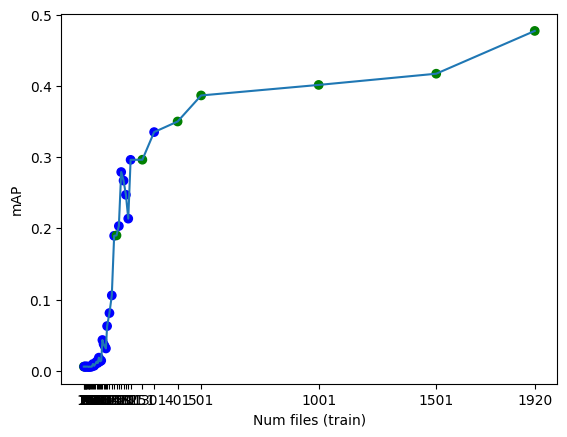

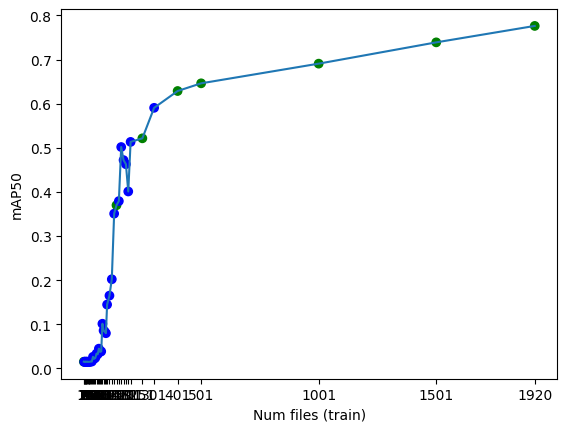

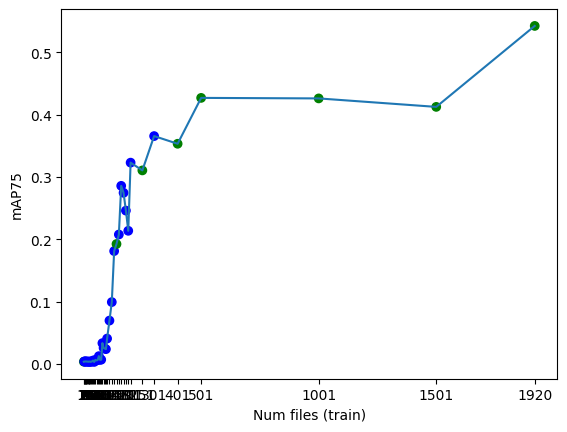

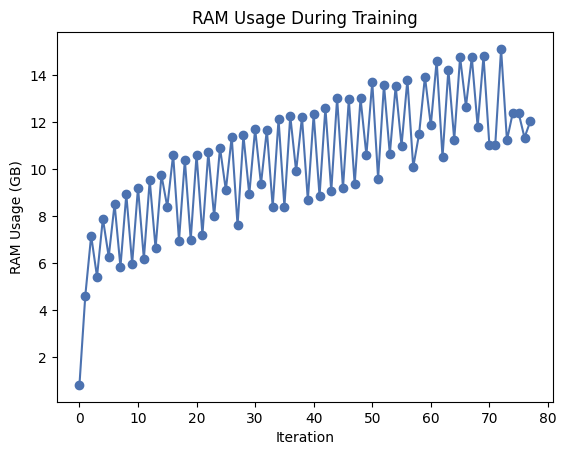

In [4]:
locale.getpreferredencoding = lambda: "UTF-8"

PATH_TO_MODEL = "/kaggle/working/yolov8m-seg.pt"
PATH_TO_YAML = "/kaggle/working/puddle-segmentation-8/data.yaml"
TRAIN_PERC = 0.8
TEST_PERC = 0.1
VAL_PERC = 0.1
KEEP_PERC = 1.0
PIECE_PERC = 0.05
ITERS = 5
FIB_FLAG = True
PREV_NUM = 50
THRESHOLD = 0.001

result_dict_base = dict()
result_dict_inc = dict()
color_dict_inc = dict()

exp_inc = YoloModel(PATH_TO_MODEL, PATH_TO_YAML, TRAIN_PERC, TEST_PERC, VAL_PERC)
# exp_inc.train_test_val_split(KEEP_PERC)
# cls_tl_dict, cls_fif_dict = exp_inc.take_piece(PIECE_PERC, FIB_FLAG)
exp_inc.increm_learning(KEEP_PERC, ITERS, PIECE_PERC, FIB_FLAG, PREV_NUM, THRESHOLD)
exp_inc.plot_ram_usage()

### Сравнение базового и инкрементального обучения

locale.getpreferredencoding = lambda: "UTF-8"

PATH_TO_MODEL = "/kaggle/working/yolov8m-seg.pt"
PATH_TO_YAML = "/kaggle/working/feet-14/data.yaml"
TRAIN_PERC = 0.8
TEST_PERC = 0.1
VAL_PERC = 0.1
KEEP_PERC = 1.0
PIECE_PERC = 0.05
ITERS = 5

result_dict_base = dict()
result_dict_inc = dict()
color_dict_inc = dict()

exp_base = YoloModel(PATH_TO_MODEL, PATH_TO_YAML, TRAIN_PERC, TEST_PERC, VAL_PERC)
result_dict_base = exp_base.base_learning(KEEP_PERC, PIECE_PERC, ITERS)
exp_base.plot_ram_usage()
del(exp_base)

exp_inc = YoloModel(PATH_TO_MODEL, PATH_TO_YAML, TRAIN_PERC, TEST_PERC, VAL_PERC, 1, 1)
result_dict_inc, color_dict_inc = exp_inc.increm_learning(KEEP_PERC, PIECE_PERC, ITERS)
exp_inc.plot_ram_usage()

import math 

map_base_list = [j[0] for j in result_dict_base.values()]
map_inc_list = [j[0] for j in result_dict_inc.values()]
mse = 0
for map_base, map_inc in zip(map_base_list, map_inc_list):
    dev = (map_base - map_inc)
    mse += dev**2
print(f"MSE = {mse}\nRMSE = {math.sqrt(mse)}")

metrics_names = ("mAP","mAP50", "mAP75")
for i, metric in enumerate(metrics_names):
    plt.plot(list(result_dict_base.keys()),
             [j[i] for j in result_dict_base.values()],
             marker='o',
             color="green",
             linestyle='-',
             zorder=0,
             label = "Базовое обучение")
    
    plt.scatter(list(result_dict_inc.keys()),
                [j[i] for j in result_dict_inc.values()],
                color=list(color_dict_inc.values()),
                zorder=1)
    plt.plot(list(result_dict_inc.keys()),
             [j[i] for j in result_dict_inc.values()],
             linestyle='-',
             label = "Инкрементальное обучение")
    
    plt.ylabel(metric)
    plt.xlabel("Keep percent (%)")
    plt.legend()
    plt.show()

num_folders = 1 / PIECE_PERC
for folder in range(int(num_folders)):
    dir_path = f"temp_{folder+1}/train/labels"
    print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
    dir_path = f"temp_{folder+1}/train/images"
    print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
    dir_path = f"temp_{folder+1}/valid/labels"
    print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
    dir_path = f"temp_{folder+1}/valid/images"
    print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]), '\n')
    
